In [1]:
import keras
from keras.models import Sequential
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
import pickle

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_OF.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
42373,winKen_wave_u_cm_np1_ri_bad_1_flow6.jpg,wave
42374,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42375,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42376,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave
42377,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame_OF/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 42378/42378 [03:14<00:00, 217.83it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(42378, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val_OF.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
8798,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8799,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8800,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8801,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8802,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame_OF/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 8803/8803 [00:55<00:00, 157.42it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(8803, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(train.nunique())
print(val.nunique())

image    21189
class       51
dtype: int64
image    8803
class      51
dtype: int64


In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(42378, 51)
(8803, 51)


In [10]:
base_model = DenseNet121(include_top=False, weights='imagenet')

In [11]:
print(base_model.output_shape)

(None, None, None, 1024)


In [12]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv2_block5_1_bn (BatchNormali (None, None, None, 1 512         conv2_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block5_1_relu (Activation (None, None, None, 1 0           conv2_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block5_2_conv (Conv2D)    (None, None, None, 3 36864       conv2_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block5_concat (Concatenat (None, None, None, 2 0           conv2_block4_concat[0][0]        
                                                                 conv2_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_bloc

conv3_block4_1_conv (Conv2D)    (None, None, None, 1 28672       conv3_block4_0_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_bn (BatchNormali (None, None, None, 1 512         conv3_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 3 36864       conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_concat (Concatenat (None, None, None, 2 0           conv3_block3_concat[0][0]        
                                                                 conv3_block4_2_conv[0][0]        
__________

__________________________________________________________________________________________________
conv3_block9_concat (Concatenat (None, None, None, 4 0           conv3_block8_concat[0][0]        
                                                                 conv3_block9_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block10_0_bn (BatchNormal (None, None, None, 4 1664        conv3_block9_concat[0][0]        
__________________________________________________________________________________________________
conv3_block10_0_relu (Activatio (None, None, None, 4 0           conv3_block10_0_bn[0][0]         
__________________________________________________________________________________________________
conv3_block10_1_conv (Conv2D)   (None, None, None, 1 53248       conv3_block10_0_relu[0][0]       
__________________________________________________________________________________________________
conv3_bloc

conv4_block2_2_conv (Conv2D)    (None, None, None, 3 36864       conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_concat (Concatenat (None, None, None, 3 0           conv4_block1_concat[0][0]        
                                                                 conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_0_bn (BatchNormali (None, None, None, 3 1280        conv4_block2_concat[0][0]        
__________________________________________________________________________________________________
conv4_block3_0_relu (Activation (None, None, None, 3 0           conv4_block3_0_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_1_conv (Conv2D)    (None, None, None, 1 40960       conv4_block3_0_relu[0][0]        
__________

conv4_block8_0_relu (Activation (None, None, None, 4 0           conv4_block8_0_bn[0][0]          
__________________________________________________________________________________________________
conv4_block8_1_conv (Conv2D)    (None, None, None, 1 61440       conv4_block8_0_relu[0][0]        
__________________________________________________________________________________________________
conv4_block8_1_bn (BatchNormali (None, None, None, 1 512         conv4_block8_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block8_1_relu (Activation (None, None, None, 1 0           conv4_block8_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block8_2_conv (Conv2D)    (None, None, None, 3 36864       conv4_block8_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block13_2_conv (Conv2D)   (None, None, None, 3 36864       conv4_block13_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block13_concat (Concatena (None, None, None, 6 0           conv4_block12_concat[0][0]       
                                                                 conv4_block13_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_0_bn (BatchNormal (None, None, None, 6 2688        conv4_block13_concat[0][0]       
__________________________________________________________________________________________________
conv4_block14_0_relu (Activatio (None, None, None, 6 0           conv4_block14_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block19_0_relu (Activatio (None, None, None, 8 0           conv4_block19_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block19_1_conv (Conv2D)   (None, None, None, 1 106496      conv4_block19_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block19_1_bn (BatchNormal (None, None, None, 1 512         conv4_block19_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block19_1_relu (Activatio (None, None, None, 1 0           conv4_block19_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block19_2_conv (Conv2D)   (None, None, None, 3 36864       conv4_block19_1_relu[0][0]       
__________

conv4_block24_1_relu (Activatio (None, None, None, 1 0           conv4_block24_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block24_2_conv (Conv2D)   (None, None, None, 3 36864       conv4_block24_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block24_concat (Concatena (None, None, None, 1 0           conv4_block23_concat[0][0]       
                                                                 conv4_block24_2_conv[0][0]       
__________________________________________________________________________________________________
pool4_bn (BatchNormalization)   (None, None, None, 1 4096        conv4_block24_concat[0][0]       
__________________________________________________________________________________________________
pool4_relu (Activation)         (None, None, None, 1 0           pool4_bn[0][0]                   
__________

__________________________________________________________________________________________________
conv5_block5_1_relu (Activation (None, None, None, 1 0           conv5_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block5_2_conv (Conv2D)    (None, None, None, 3 36864       conv5_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block5_concat (Concatenat (None, None, None, 6 0           conv5_block4_concat[0][0]        
                                                                 conv5_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block6_0_bn (BatchNormali (None, None, None, 6 2688        conv5_block5_concat[0][0]        
__________________________________________________________________________________________________
conv5_bloc

__________________________________________________________________________________________________
conv5_block11_0_bn (BatchNormal (None, None, None, 8 3328        conv5_block10_concat[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_relu (Activatio (None, None, None, 8 0           conv5_block11_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block11_1_conv (Conv2D)   (None, None, None, 1 106496      conv5_block11_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block11_1_bn (BatchNormal (None, None, None, 1 512         conv5_block11_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block11_1_relu (Activatio (None, None, None, 1 0           conv5_block11_1_bn[0][0]         
__________

conv5_block16_1_bn (BatchNormal (None, None, None, 1 512         conv5_block16_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block16_1_relu (Activatio (None, None, None, 1 0           conv5_block16_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block16_2_conv (Conv2D)   (None, None, None, 3 36864       conv5_block16_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block16_concat (Concatena (None, None, None, 1 0           conv5_block15_concat[0][0]       
                                                                 conv5_block16_2_conv[0][0]       
__________________________________________________________________________________________________
bn (BatchNormalization)         (None, None, None, 1 4096        conv5_block16_concat[0][0]       
__________

In [13]:
base_model.get_config()

{'name': 'densenet121',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'zero_padding2d_1',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'zero_padding2d_1',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1/conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1/conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform

In [14]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2-t1)

2020-09-02 23:36:55.844655
(42378, 7, 7, 1024)
6:57:30.158094


In [16]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(42378, 7*7*1024)

In [17]:
pickle_out = open('../Pickle/DenseNet121_X_train_OF.pickle',"wb")
pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()

In [18]:
pickle_in = open('../Pickle/DenseNet121_X_train_OF.pickle',"rb")
X_train = pickle.load(pickle_in)
print(X_train.shape)

(42378, 50176)


In [19]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4-t3)

2020-09-03 10:14:00.338864
(8803, 7, 7, 1024)
2:16:25.999141


In [20]:
X_test = X_test.reshape(8803, 7*7*1024)

In [21]:
# Save the model as a pickle in a file 
joblib.dump(X_test, '../Pickle/DenseNet121_X_test_OF.pkl')

['../Pickle/DenseNet121_X_test_OF.pkl']

In [22]:
# Load the model from the file 
X_test = joblib.load('../Pickle/DenseNet121_X_test_OF.pkl') 

In [23]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42378, 50176)
(8803, 50176)
(42378, 51)
(8803, 51)


In [24]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(50176,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [25]:
model.output_shape

(None, 51)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [27]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 50176),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [28]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightDenseNet121_OF.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [29]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [30]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-09-03 12:30:34.849711
Train on 42378 samples, validate on 8803 samples
Epoch 1/100


23424/42378 [===============>..............] - ETA: 9:42 - loss: 5.8211 - accuracy: 0.03 - ETA: 6:36 - loss: 9.3074 - accuracy: 0.01 - ETA: 5:37 - loss: 10.4362 - accuracy: 0.018 - ETA: 5:01 - loss: 10.7798 - accuracy: 0.019 - ETA: 4:39 - loss: 10.8506 - accuracy: 0.021 - ETA: 4:22 - loss: 10.5341 - accuracy: 0.026 - ETA: 4:11 - loss: 10.2608 - accuracy: 0.029 - ETA: 4:01 - loss: 9.9264 - accuracy: 0.027 - ETA: 3:53 - loss: 9.5862 - accuracy: 0.02 - ETA: 3:48 - loss: 9.2832 - accuracy: 0.02 - ETA: 3:43 - loss: 8.9439 - accuracy: 0.03 - ETA: 3:39 - loss: 8.6601 - accuracy: 0.03 - ETA: 3:35 - loss: 8.4301 - accuracy: 0.03 - ETA: 3:32 - loss: 8.2177 - accuracy: 0.02 - ETA: 3:29 - loss: 8.0019 - accuracy: 0.02 - ETA: 3:26 - loss: 7.7989 - accuracy: 0.02 - ETA: 3:24 - loss: 7.5999 - accuracy: 0.02 - ETA: 3:22 - loss: 7.4215 - accuracy: 0.02 - ETA: 3:20 - loss: 7.2542 - accuracy: 0.02 - ETA: 3:19 - loss: 7.1003 - accuracy: 0.02 - ETA: 3:18 - loss: 6.9674 - accuracy: 0.02 - ETA: 3:16 - loss: 

42378/42378 [==============================] - ETA: 1:26 - loss: 4.2620 - accuracy: 0.03 - ETA: 1:26 - loss: 4.2597 - accuracy: 0.03 - ETA: 1:25 - loss: 4.2571 - accuracy: 0.03 - ETA: 1:25 - loss: 4.2549 - accuracy: 0.03 - ETA: 1:24 - loss: 4.2523 - accuracy: 0.03 - ETA: 1:24 - loss: 4.2500 - accuracy: 0.04 - ETA: 1:23 - loss: 4.2484 - accuracy: 0.04 - ETA: 1:22 - loss: 4.2463 - accuracy: 0.03 - ETA: 1:22 - loss: 4.2433 - accuracy: 0.04 - ETA: 1:21 - loss: 4.2417 - accuracy: 0.04 - ETA: 1:21 - loss: 4.2396 - accuracy: 0.04 - ETA: 1:20 - loss: 4.2371 - accuracy: 0.04 - ETA: 1:19 - loss: 4.2350 - accuracy: 0.04 - ETA: 1:19 - loss: 4.2331 - accuracy: 0.04 - ETA: 1:18 - loss: 4.2309 - accuracy: 0.04 - ETA: 1:18 - loss: 4.2291 - accuracy: 0.04 - ETA: 1:17 - loss: 4.2273 - accuracy: 0.04 - ETA: 1:16 - loss: 4.2255 - accuracy: 0.04 - ETA: 1:16 - loss: 4.2236 - accuracy: 0.04 - ETA: 1:15 - loss: 4.2217 - accuracy: 0.04 - ETA: 1:14 - loss: 4.2199 - accuracy: 0.04 - ETA: 1:14 - loss: 4.2178 - ac

23808/42378 [===============>..............] - ETA: 3:09 - loss: 3.6868 - accuracy: 0.05 - ETA: 3:04 - loss: 3.7530 - accuracy: 0.05 - ETA: 3:05 - loss: 3.7562 - accuracy: 0.05 - ETA: 3:06 - loss: 3.7463 - accuracy: 0.06 - ETA: 3:06 - loss: 3.7518 - accuracy: 0.06 - ETA: 3:05 - loss: 3.7532 - accuracy: 0.05 - ETA: 3:04 - loss: 3.7542 - accuracy: 0.05 - ETA: 3:04 - loss: 3.7427 - accuracy: 0.05 - ETA: 3:04 - loss: 3.7492 - accuracy: 0.05 - ETA: 3:02 - loss: 3.7416 - accuracy: 0.06 - ETA: 3:01 - loss: 3.7452 - accuracy: 0.06 - ETA: 3:00 - loss: 3.7511 - accuracy: 0.05 - ETA: 3:00 - loss: 3.7530 - accuracy: 0.05 - ETA: 2:59 - loss: 3.7531 - accuracy: 0.05 - ETA: 2:58 - loss: 3.7554 - accuracy: 0.05 - ETA: 2:57 - loss: 3.7563 - accuracy: 0.05 - ETA: 2:57 - loss: 3.7561 - accuracy: 0.05 - ETA: 2:57 - loss: 3.7511 - accuracy: 0.05 - ETA: 2:56 - loss: 3.7504 - accuracy: 0.05 - ETA: 2:56 - loss: 3.7502 - accuracy: 0.05 - ETA: 2:55 - loss: 3.7515 - accuracy: 0.05 - ETA: 2:55 - loss: 3.7572 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.7372 - accuracy: 0.07 - ETA: 1:21 - loss: 3.7372 - accuracy: 0.07 - ETA: 1:21 - loss: 3.7368 - accuracy: 0.07 - ETA: 1:20 - loss: 3.7366 - accuracy: 0.07 - ETA: 1:20 - loss: 3.7360 - accuracy: 0.07 - ETA: 1:19 - loss: 3.7357 - accuracy: 0.07 - ETA: 1:19 - loss: 3.7356 - accuracy: 0.07 - ETA: 1:18 - loss: 3.7356 - accuracy: 0.07 - ETA: 1:18 - loss: 3.7353 - accuracy: 0.07 - ETA: 1:17 - loss: 3.7352 - accuracy: 0.07 - ETA: 1:17 - loss: 3.7348 - accuracy: 0.07 - ETA: 1:16 - loss: 3.7348 - accuracy: 0.07 - ETA: 1:15 - loss: 3.7343 - accuracy: 0.07 - ETA: 1:15 - loss: 3.7343 - accuracy: 0.07 - ETA: 1:14 - loss: 3.7342 - accuracy: 0.07 - ETA: 1:14 - loss: 3.7334 - accuracy: 0.07 - ETA: 1:13 - loss: 3.7339 - accuracy: 0.07 - ETA: 1:12 - loss: 3.7331 - accuracy: 0.07 - ETA: 1:12 - loss: 3.7319 - accuracy: 0.07 - ETA: 1:11 - loss: 3.7318 - accuracy: 0.07 - ETA: 1:11 - loss: 3.7315 - accuracy: 0.07 - ETA: 1:10 - loss: 3.7312 - ac

23808/42378 [===============>..............] - ETA: 3:02 - loss: 3.5649 - accuracy: 0.10 - ETA: 3:00 - loss: 3.6100 - accuracy: 0.09 - ETA: 2:59 - loss: 3.6094 - accuracy: 0.09 - ETA: 2:59 - loss: 3.6220 - accuracy: 0.09 - ETA: 3:02 - loss: 3.6332 - accuracy: 0.09 - ETA: 3:00 - loss: 3.6464 - accuracy: 0.09 - ETA: 3:00 - loss: 3.6539 - accuracy: 0.09 - ETA: 2:59 - loss: 3.6426 - accuracy: 0.09 - ETA: 2:58 - loss: 3.6291 - accuracy: 0.09 - ETA: 2:57 - loss: 3.6321 - accuracy: 0.09 - ETA: 2:57 - loss: 3.6319 - accuracy: 0.09 - ETA: 2:56 - loss: 3.6310 - accuracy: 0.09 - ETA: 2:55 - loss: 3.6258 - accuracy: 0.09 - ETA: 2:55 - loss: 3.6204 - accuracy: 0.09 - ETA: 2:55 - loss: 3.6224 - accuracy: 0.10 - ETA: 2:55 - loss: 3.6237 - accuracy: 0.10 - ETA: 2:54 - loss: 3.6272 - accuracy: 0.10 - ETA: 2:54 - loss: 3.6314 - accuracy: 0.09 - ETA: 2:53 - loss: 3.6332 - accuracy: 0.09 - ETA: 2:53 - loss: 3.6294 - accuracy: 0.09 - ETA: 2:52 - loss: 3.6337 - accuracy: 0.09 - ETA: 2:52 - loss: 3.6255 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.6140 - accuracy: 0.10 - ETA: 1:22 - loss: 3.6135 - accuracy: 0.10 - ETA: 1:21 - loss: 3.6133 - accuracy: 0.10 - ETA: 1:21 - loss: 3.6133 - accuracy: 0.10 - ETA: 1:20 - loss: 3.6125 - accuracy: 0.10 - ETA: 1:20 - loss: 3.6116 - accuracy: 0.10 - ETA: 1:19 - loss: 3.6112 - accuracy: 0.10 - ETA: 1:18 - loss: 3.6108 - accuracy: 0.10 - ETA: 1:18 - loss: 3.6107 - accuracy: 0.10 - ETA: 1:17 - loss: 3.6108 - accuracy: 0.10 - ETA: 1:17 - loss: 3.6099 - accuracy: 0.10 - ETA: 1:16 - loss: 3.6098 - accuracy: 0.10 - ETA: 1:16 - loss: 3.6087 - accuracy: 0.10 - ETA: 1:15 - loss: 3.6084 - accuracy: 0.10 - ETA: 1:14 - loss: 3.6079 - accuracy: 0.10 - ETA: 1:14 - loss: 3.6071 - accuracy: 0.10 - ETA: 1:13 - loss: 3.6074 - accuracy: 0.10 - ETA: 1:13 - loss: 3.6072 - accuracy: 0.10 - ETA: 1:12 - loss: 3.6064 - accuracy: 0.10 - ETA: 1:11 - loss: 3.6066 - accuracy: 0.10 - ETA: 1:11 - loss: 3.6061 - accuracy: 0.10 - ETA: 1:10 - loss: 3.6054 - ac

23808/42378 [===============>..............] - ETA: 3:11 - loss: 3.4628 - accuracy: 0.15 - ETA: 3:14 - loss: 3.4152 - accuracy: 0.16 - ETA: 3:13 - loss: 3.4568 - accuracy: 0.14 - ETA: 3:14 - loss: 3.4615 - accuracy: 0.14 - ETA: 3:11 - loss: 3.4708 - accuracy: 0.13 - ETA: 3:09 - loss: 3.4920 - accuracy: 0.13 - ETA: 3:07 - loss: 3.5113 - accuracy: 0.12 - ETA: 3:05 - loss: 3.5410 - accuracy: 0.11 - ETA: 3:04 - loss: 3.5458 - accuracy: 0.11 - ETA: 3:03 - loss: 3.5580 - accuracy: 0.11 - ETA: 3:01 - loss: 3.5397 - accuracy: 0.11 - ETA: 3:00 - loss: 3.5507 - accuracy: 0.11 - ETA: 3:01 - loss: 3.5561 - accuracy: 0.11 - ETA: 3:00 - loss: 3.5626 - accuracy: 0.11 - ETA: 3:00 - loss: 3.5599 - accuracy: 0.11 - ETA: 2:59 - loss: 3.5527 - accuracy: 0.11 - ETA: 2:58 - loss: 3.5475 - accuracy: 0.11 - ETA: 2:58 - loss: 3.5492 - accuracy: 0.11 - ETA: 2:57 - loss: 3.5433 - accuracy: 0.11 - ETA: 2:56 - loss: 3.5501 - accuracy: 0.11 - ETA: 2:55 - loss: 3.5492 - accuracy: 0.11 - ETA: 2:56 - loss: 3.5572 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.5264 - accuracy: 0.11 - ETA: 1:22 - loss: 3.5260 - accuracy: 0.11 - ETA: 1:21 - loss: 3.5264 - accuracy: 0.11 - ETA: 1:21 - loss: 3.5274 - accuracy: 0.11 - ETA: 1:20 - loss: 3.5266 - accuracy: 0.11 - ETA: 1:19 - loss: 3.5259 - accuracy: 0.11 - ETA: 1:19 - loss: 3.5256 - accuracy: 0.11 - ETA: 1:18 - loss: 3.5245 - accuracy: 0.11 - ETA: 1:18 - loss: 3.5253 - accuracy: 0.11 - ETA: 1:17 - loss: 3.5250 - accuracy: 0.11 - ETA: 1:17 - loss: 3.5244 - accuracy: 0.11 - ETA: 1:16 - loss: 3.5244 - accuracy: 0.11 - ETA: 1:15 - loss: 3.5250 - accuracy: 0.11 - ETA: 1:15 - loss: 3.5259 - accuracy: 0.11 - ETA: 1:14 - loss: 3.5256 - accuracy: 0.11 - ETA: 1:14 - loss: 3.5254 - accuracy: 0.11 - ETA: 1:13 - loss: 3.5252 - accuracy: 0.11 - ETA: 1:13 - loss: 3.5255 - accuracy: 0.11 - ETA: 1:12 - loss: 3.5256 - accuracy: 0.11 - ETA: 1:11 - loss: 3.5261 - accuracy: 0.11 - ETA: 1:11 - loss: 3.5253 - accuracy: 0.11 - ETA: 1:10 - loss: 3.5260 - ac

23808/42378 [===============>..............] - ETA: 3:17 - loss: 3.5676 - accuracy: 0.10 - ETA: 3:07 - loss: 3.4598 - accuracy: 0.12 - ETA: 3:05 - loss: 3.4784 - accuracy: 0.12 - ETA: 3:04 - loss: 3.4992 - accuracy: 0.11 - ETA: 3:02 - loss: 3.4475 - accuracy: 0.12 - ETA: 3:03 - loss: 3.4132 - accuracy: 0.13 - ETA: 3:04 - loss: 3.4162 - accuracy: 0.13 - ETA: 3:03 - loss: 3.4219 - accuracy: 0.13 - ETA: 3:03 - loss: 3.4123 - accuracy: 0.13 - ETA: 3:04 - loss: 3.4298 - accuracy: 0.13 - ETA: 3:05 - loss: 3.4281 - accuracy: 0.13 - ETA: 3:05 - loss: 3.4245 - accuracy: 0.13 - ETA: 3:04 - loss: 3.4271 - accuracy: 0.13 - ETA: 3:02 - loss: 3.4275 - accuracy: 0.13 - ETA: 3:02 - loss: 3.4172 - accuracy: 0.13 - ETA: 3:01 - loss: 3.4303 - accuracy: 0.12 - ETA: 3:00 - loss: 3.4345 - accuracy: 0.12 - ETA: 3:00 - loss: 3.4347 - accuracy: 0.12 - ETA: 2:59 - loss: 3.4415 - accuracy: 0.12 - ETA: 2:58 - loss: 3.4431 - accuracy: 0.12 - ETA: 2:57 - loss: 3.4503 - accuracy: 0.12 - ETA: 2:57 - loss: 3.4489 - ac

42378/42378 [==============================] - ETA: 1:23 - loss: 3.4797 - accuracy: 0.12 - ETA: 1:22 - loss: 3.4789 - accuracy: 0.12 - ETA: 1:22 - loss: 3.4787 - accuracy: 0.12 - ETA: 1:21 - loss: 3.4783 - accuracy: 0.12 - ETA: 1:21 - loss: 3.4776 - accuracy: 0.12 - ETA: 1:20 - loss: 3.4778 - accuracy: 0.12 - ETA: 1:20 - loss: 3.4780 - accuracy: 0.12 - ETA: 1:19 - loss: 3.4777 - accuracy: 0.12 - ETA: 1:18 - loss: 3.4772 - accuracy: 0.12 - ETA: 1:18 - loss: 3.4772 - accuracy: 0.12 - ETA: 1:17 - loss: 3.4763 - accuracy: 0.12 - ETA: 1:17 - loss: 3.4759 - accuracy: 0.12 - ETA: 1:16 - loss: 3.4765 - accuracy: 0.12 - ETA: 1:15 - loss: 3.4760 - accuracy: 0.12 - ETA: 1:15 - loss: 3.4757 - accuracy: 0.12 - ETA: 1:14 - loss: 3.4756 - accuracy: 0.12 - ETA: 1:14 - loss: 3.4751 - accuracy: 0.12 - ETA: 1:13 - loss: 3.4748 - accuracy: 0.12 - ETA: 1:13 - loss: 3.4736 - accuracy: 0.12 - ETA: 1:12 - loss: 3.4740 - accuracy: 0.12 - ETA: 1:11 - loss: 3.4738 - accuracy: 0.12 - ETA: 1:11 - loss: 3.4744 - ac

23808/42378 [===============>..............] - ETA: 3:43 - loss: 3.3875 - accuracy: 0.14 - ETA: 3:23 - loss: 3.4374 - accuracy: 0.14 - ETA: 3:20 - loss: 3.4788 - accuracy: 0.12 - ETA: 3:19 - loss: 3.4841 - accuracy: 0.11 - ETA: 3:20 - loss: 3.4507 - accuracy: 0.12 - ETA: 3:19 - loss: 3.4418 - accuracy: 0.12 - ETA: 3:19 - loss: 3.4169 - accuracy: 0.13 - ETA: 3:16 - loss: 3.4451 - accuracy: 0.12 - ETA: 3:13 - loss: 3.4497 - accuracy: 0.12 - ETA: 3:11 - loss: 3.4362 - accuracy: 0.12 - ETA: 3:09 - loss: 3.4198 - accuracy: 0.13 - ETA: 3:08 - loss: 3.4107 - accuracy: 0.13 - ETA: 3:06 - loss: 3.4144 - accuracy: 0.12 - ETA: 3:07 - loss: 3.4291 - accuracy: 0.12 - ETA: 3:06 - loss: 3.4301 - accuracy: 0.12 - ETA: 3:06 - loss: 3.4246 - accuracy: 0.13 - ETA: 3:06 - loss: 3.4304 - accuracy: 0.12 - ETA: 3:06 - loss: 3.4332 - accuracy: 0.12 - ETA: 3:04 - loss: 3.4307 - accuracy: 0.13 - ETA: 3:03 - loss: 3.4321 - accuracy: 0.13 - ETA: 3:02 - loss: 3.4296 - accuracy: 0.13 - ETA: 3:01 - loss: 3.4341 - ac

42378/42378 [==============================] - ETA: 1:23 - loss: 3.4581 - accuracy: 0.12 - ETA: 1:22 - loss: 3.4579 - accuracy: 0.12 - ETA: 1:21 - loss: 3.4577 - accuracy: 0.12 - ETA: 1:21 - loss: 3.4576 - accuracy: 0.12 - ETA: 1:20 - loss: 3.4582 - accuracy: 0.12 - ETA: 1:20 - loss: 3.4578 - accuracy: 0.12 - ETA: 1:19 - loss: 3.4572 - accuracy: 0.12 - ETA: 1:19 - loss: 3.4574 - accuracy: 0.12 - ETA: 1:18 - loss: 3.4563 - accuracy: 0.12 - ETA: 1:17 - loss: 3.4555 - accuracy: 0.12 - ETA: 1:17 - loss: 3.4549 - accuracy: 0.12 - ETA: 1:16 - loss: 3.4544 - accuracy: 0.12 - ETA: 1:16 - loss: 3.4551 - accuracy: 0.12 - ETA: 1:15 - loss: 3.4553 - accuracy: 0.12 - ETA: 1:14 - loss: 3.4546 - accuracy: 0.12 - ETA: 1:14 - loss: 3.4552 - accuracy: 0.12 - ETA: 1:13 - loss: 3.4548 - accuracy: 0.12 - ETA: 1:13 - loss: 3.4549 - accuracy: 0.12 - ETA: 1:12 - loss: 3.4553 - accuracy: 0.12 - ETA: 1:11 - loss: 3.4552 - accuracy: 0.12 - ETA: 1:11 - loss: 3.4559 - accuracy: 0.12 - ETA: 1:10 - loss: 3.4554 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 3.5380 - accuracy: 0.07 - ETA: 3:12 - loss: 3.4704 - accuracy: 0.10 - ETA: 3:09 - loss: 3.4426 - accuracy: 0.11 - ETA: 3:07 - loss: 3.4161 - accuracy: 0.13 - ETA: 3:06 - loss: 3.4273 - accuracy: 0.12 - ETA: 3:04 - loss: 3.4058 - accuracy: 0.12 - ETA: 3:02 - loss: 3.4182 - accuracy: 0.12 - ETA: 3:02 - loss: 3.4096 - accuracy: 0.13 - ETA: 3:00 - loss: 3.4083 - accuracy: 0.13 - ETA: 3:01 - loss: 3.3849 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3820 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3767 - accuracy: 0.14 - ETA: 2:59 - loss: 3.3766 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3789 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3834 - accuracy: 0.13 - ETA: 2:57 - loss: 3.3929 - accuracy: 0.13 - ETA: 2:57 - loss: 3.3907 - accuracy: 0.13 - ETA: 2:56 - loss: 3.3987 - accuracy: 0.13 - ETA: 2:56 - loss: 3.3910 - accuracy: 0.13 - ETA: 2:55 - loss: 3.3941 - accuracy: 0.13 - ETA: 2:55 - loss: 3.3960 - accuracy: 0.13 - ETA: 2:55 - loss: 3.3960 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.4215 - accuracy: 0.13 - ETA: 1:21 - loss: 3.4220 - accuracy: 0.13 - ETA: 1:21 - loss: 3.4206 - accuracy: 0.13 - ETA: 1:20 - loss: 3.4210 - accuracy: 0.13 - ETA: 1:20 - loss: 3.4208 - accuracy: 0.13 - ETA: 1:19 - loss: 3.4205 - accuracy: 0.13 - ETA: 1:19 - loss: 3.4204 - accuracy: 0.13 - ETA: 1:18 - loss: 3.4202 - accuracy: 0.13 - ETA: 1:18 - loss: 3.4199 - accuracy: 0.13 - ETA: 1:17 - loss: 3.4210 - accuracy: 0.13 - ETA: 1:16 - loss: 3.4205 - accuracy: 0.13 - ETA: 1:16 - loss: 3.4203 - accuracy: 0.13 - ETA: 1:15 - loss: 3.4200 - accuracy: 0.13 - ETA: 1:15 - loss: 3.4207 - accuracy: 0.13 - ETA: 1:14 - loss: 3.4200 - accuracy: 0.13 - ETA: 1:13 - loss: 3.4199 - accuracy: 0.13 - ETA: 1:13 - loss: 3.4192 - accuracy: 0.13 - ETA: 1:12 - loss: 3.4195 - accuracy: 0.13 - ETA: 1:12 - loss: 3.4188 - accuracy: 0.13 - ETA: 1:11 - loss: 3.4175 - accuracy: 0.13 - ETA: 1:10 - loss: 3.4178 - accuracy: 0.13 - ETA: 1:10 - loss: 3.4192 - ac

23808/42378 [===============>..............] - ETA: 2:58 - loss: 3.2347 - accuracy: 0.21 - ETA: 2:58 - loss: 3.3807 - accuracy: 0.16 - ETA: 3:05 - loss: 3.4156 - accuracy: 0.15 - ETA: 3:06 - loss: 3.4491 - accuracy: 0.14 - ETA: 3:05 - loss: 3.4361 - accuracy: 0.13 - ETA: 3:05 - loss: 3.4450 - accuracy: 0.13 - ETA: 3:03 - loss: 3.4259 - accuracy: 0.13 - ETA: 3:03 - loss: 3.4065 - accuracy: 0.13 - ETA: 3:01 - loss: 3.4022 - accuracy: 0.13 - ETA: 3:00 - loss: 3.4006 - accuracy: 0.13 - ETA: 2:59 - loss: 3.4223 - accuracy: 0.13 - ETA: 3:00 - loss: 3.4234 - accuracy: 0.13 - ETA: 2:59 - loss: 3.4142 - accuracy: 0.13 - ETA: 2:59 - loss: 3.4179 - accuracy: 0.14 - ETA: 2:58 - loss: 3.4222 - accuracy: 0.13 - ETA: 2:57 - loss: 3.4220 - accuracy: 0.13 - ETA: 2:58 - loss: 3.4237 - accuracy: 0.13 - ETA: 2:57 - loss: 3.4347 - accuracy: 0.13 - ETA: 2:56 - loss: 3.4333 - accuracy: 0.13 - ETA: 2:56 - loss: 3.4317 - accuracy: 0.13 - ETA: 2:55 - loss: 3.4302 - accuracy: 0.13 - ETA: 2:55 - loss: 3.4263 - ac

42378/42378 [==============================] - ETA: 1:43 - loss: 3.3962 - accuracy: 0.13 - ETA: 1:43 - loss: 3.3961 - accuracy: 0.13 - ETA: 1:42 - loss: 3.3959 - accuracy: 0.14 - ETA: 1:42 - loss: 3.3957 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3965 - accuracy: 0.13 - ETA: 1:41 - loss: 3.3963 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3979 - accuracy: 0.13 - ETA: 1:40 - loss: 3.3981 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3987 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3989 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3994 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3986 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3981 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3980 - accuracy: 0.13 - ETA: 1:36 - loss: 3.3982 - accuracy: 0.13 - ETA: 1:35 - loss: 3.3991 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3982 - accuracy: 0.13 - ETA: 1:34 - loss: 3.3988 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3985 - accuracy: 0.13 - ETA: 1:33 - loss: 3.3989 - accuracy: 0.13 - ETA: 1:32 - loss: 3.3989 - accuracy: 0.13 - ETA: 1:31 - loss: 3.3983 - ac

23808/42378 [===============>..............] - ETA: 5:25 - loss: 3.5221 - accuracy: 0.17 - ETA: 5:13 - loss: 3.4810 - accuracy: 0.14 - ETA: 5:08 - loss: 3.4331 - accuracy: 0.14 - ETA: 5:09 - loss: 3.5205 - accuracy: 0.14 - ETA: 5:10 - loss: 3.4988 - accuracy: 0.14 - ETA: 5:09 - loss: 3.4549 - accuracy: 0.14 - ETA: 5:11 - loss: 3.4546 - accuracy: 0.14 - ETA: 5:08 - loss: 3.4394 - accuracy: 0.14 - ETA: 5:04 - loss: 3.4244 - accuracy: 0.14 - ETA: 5:04 - loss: 3.4369 - accuracy: 0.14 - ETA: 5:03 - loss: 3.4298 - accuracy: 0.14 - ETA: 5:03 - loss: 3.4388 - accuracy: 0.14 - ETA: 5:03 - loss: 3.4397 - accuracy: 0.14 - ETA: 5:02 - loss: 3.4326 - accuracy: 0.14 - ETA: 5:03 - loss: 3.4264 - accuracy: 0.14 - ETA: 5:02 - loss: 3.4291 - accuracy: 0.13 - ETA: 5:02 - loss: 3.4201 - accuracy: 0.14 - ETA: 5:03 - loss: 3.4222 - accuracy: 0.13 - ETA: 5:02 - loss: 3.4153 - accuracy: 0.14 - ETA: 5:01 - loss: 3.4168 - accuracy: 0.14 - ETA: 4:59 - loss: 3.4157 - accuracy: 0.13 - ETA: 4:58 - loss: 3.4175 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 3.4095 - accuracy: 0.13 - ETA: 2:18 - loss: 3.4096 - accuracy: 0.13 - ETA: 2:17 - loss: 3.4101 - accuracy: 0.13 - ETA: 2:16 - loss: 3.4103 - accuracy: 0.13 - ETA: 2:15 - loss: 3.4104 - accuracy: 0.13 - ETA: 2:14 - loss: 3.4107 - accuracy: 0.13 - ETA: 2:13 - loss: 3.4108 - accuracy: 0.13 - ETA: 2:12 - loss: 3.4104 - accuracy: 0.13 - ETA: 2:11 - loss: 3.4107 - accuracy: 0.13 - ETA: 2:10 - loss: 3.4107 - accuracy: 0.13 - ETA: 2:09 - loss: 3.4112 - accuracy: 0.13 - ETA: 2:08 - loss: 3.4118 - accuracy: 0.13 - ETA: 2:07 - loss: 3.4105 - accuracy: 0.13 - ETA: 2:06 - loss: 3.4107 - accuracy: 0.13 - ETA: 2:05 - loss: 3.4114 - accuracy: 0.13 - ETA: 2:04 - loss: 3.4116 - accuracy: 0.13 - ETA: 2:03 - loss: 3.4123 - accuracy: 0.13 - ETA: 2:02 - loss: 3.4126 - accuracy: 0.13 - ETA: 2:01 - loss: 3.4127 - accuracy: 0.13 - ETA: 2:00 - loss: 3.4127 - accuracy: 0.13 - ETA: 1:59 - loss: 3.4138 - accuracy: 0.13 - ETA: 1:58 - loss: 3.4143 - ac

23808/42378 [===============>..............] - ETA: 5:02 - loss: 3.3267 - accuracy: 0.16 - ETA: 4:59 - loss: 3.4175 - accuracy: 0.15 - ETA: 5:03 - loss: 3.4460 - accuracy: 0.14 - ETA: 5:09 - loss: 3.3631 - accuracy: 0.15 - ETA: 5:09 - loss: 3.3826 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3783 - accuracy: 0.14 - ETA: 5:14 - loss: 3.3702 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3960 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3965 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3973 - accuracy: 0.14 - ETA: 5:12 - loss: 3.4095 - accuracy: 0.14 - ETA: 5:13 - loss: 3.3847 - accuracy: 0.14 - ETA: 5:13 - loss: 3.3805 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3860 - accuracy: 0.14 - ETA: 5:08 - loss: 3.3869 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3848 - accuracy: 0.14 - ETA: 5:04 - loss: 3.3892 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3791 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3733 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3694 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3713 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3751 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3557 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3541 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3537 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3536 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3529 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3536 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3541 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3537 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3543 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3551 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3550 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3557 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3549 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3549 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3550 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3549 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3551 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3539 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3537 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3537 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3541 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3547 - ac

23808/42378 [===============>..............] - ETA: 4:59 - loss: 3.4818 - accuracy: 0.13 - ETA: 5:08 - loss: 3.4318 - accuracy: 0.13 - ETA: 5:15 - loss: 3.4000 - accuracy: 0.13 - ETA: 5:11 - loss: 3.3757 - accuracy: 0.13 - ETA: 5:07 - loss: 3.3783 - accuracy: 0.13 - ETA: 5:04 - loss: 3.3931 - accuracy: 0.12 - ETA: 5:09 - loss: 3.3786 - accuracy: 0.13 - ETA: 5:07 - loss: 3.3661 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3698 - accuracy: 0.13 - ETA: 5:06 - loss: 3.3761 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3598 - accuracy: 0.13 - ETA: 5:06 - loss: 3.3546 - accuracy: 0.13 - ETA: 5:06 - loss: 3.3556 - accuracy: 0.13 - ETA: 5:06 - loss: 3.3580 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3571 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3491 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3408 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3351 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3412 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3391 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3365 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3417 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3358 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3363 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3367 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3363 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3369 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3371 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3372 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3370 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3370 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3373 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3371 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3374 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3382 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3380 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3384 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3387 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3397 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3405 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3404 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3404 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3399 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3401 - ac

23808/42378 [===============>..............] - ETA: 5:20 - loss: 3.3008 - accuracy: 0.16 - ETA: 5:05 - loss: 3.2905 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2657 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2968 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2989 - accuracy: 0.15 - ETA: 5:08 - loss: 3.3063 - accuracy: 0.15 - ETA: 5:07 - loss: 3.4041 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3995 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3772 - accuracy: 0.15 - ETA: 5:03 - loss: 3.3910 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3928 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3952 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3773 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3697 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3837 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3829 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3807 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3789 - accuracy: 0.14 - ETA: 4:57 - loss: 3.3697 - accuracy: 0.14 - ETA: 4:56 - loss: 3.3736 - accuracy: 0.14 - ETA: 4:55 - loss: 3.3737 - accuracy: 0.14 - ETA: 4:54 - loss: 3.3827 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.3407 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3406 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3391 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3391 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3387 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3392 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3395 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3396 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3397 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3411 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3413 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3421 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3421 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3413 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3416 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3419 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3420 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3419 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3422 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3434 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3447 - accuracy: 0.14 - ETA: 1:56 - loss: 3.3442 - ac

23808/42378 [===============>..............] - ETA: 5:25 - loss: 3.4879 - accuracy: 0.10 - ETA: 5:22 - loss: 3.4414 - accuracy: 0.13 - ETA: 5:15 - loss: 3.4089 - accuracy: 0.13 - ETA: 5:18 - loss: 3.3571 - accuracy: 0.14 - ETA: 5:15 - loss: 3.3639 - accuracy: 0.14 - ETA: 5:20 - loss: 3.3376 - accuracy: 0.14 - ETA: 5:19 - loss: 3.3308 - accuracy: 0.14 - ETA: 5:18 - loss: 3.3507 - accuracy: 0.14 - ETA: 5:16 - loss: 3.3556 - accuracy: 0.14 - ETA: 5:13 - loss: 3.3515 - accuracy: 0.14 - ETA: 5:12 - loss: 3.3365 - accuracy: 0.14 - ETA: 5:10 - loss: 3.3310 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3344 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3400 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3399 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3478 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3485 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3447 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3515 - accuracy: 0.14 - ETA: 4:56 - loss: 3.3536 - accuracy: 0.14 - ETA: 4:55 - loss: 3.3538 - accuracy: 0.14 - ETA: 4:55 - loss: 3.3520 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3427 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3418 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3414 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3419 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3417 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3416 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3418 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3410 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3414 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3410 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3411 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3415 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3417 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3414 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3415 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3420 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3429 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3433 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3445 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3444 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3442 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3439 - ac

23808/42378 [===============>..............] - ETA: 5:14 - loss: 3.2038 - accuracy: 0.14 - ETA: 5:22 - loss: 3.2048 - accuracy: 0.16 - ETA: 5:27 - loss: 3.2066 - accuracy: 0.16 - ETA: 5:26 - loss: 3.2631 - accuracy: 0.16 - ETA: 5:20 - loss: 3.2704 - accuracy: 0.16 - ETA: 5:16 - loss: 3.2787 - accuracy: 0.15 - ETA: 5:17 - loss: 3.3027 - accuracy: 0.15 - ETA: 5:17 - loss: 3.3055 - accuracy: 0.15 - ETA: 5:14 - loss: 3.3073 - accuracy: 0.15 - ETA: 5:14 - loss: 3.3131 - accuracy: 0.15 - ETA: 5:12 - loss: 3.3112 - accuracy: 0.15 - ETA: 5:11 - loss: 3.3052 - accuracy: 0.16 - ETA: 5:09 - loss: 3.3026 - accuracy: 0.15 - ETA: 5:07 - loss: 3.3031 - accuracy: 0.15 - ETA: 5:06 - loss: 3.3204 - accuracy: 0.15 - ETA: 5:06 - loss: 3.3246 - accuracy: 0.15 - ETA: 5:04 - loss: 3.3237 - accuracy: 0.15 - ETA: 5:03 - loss: 3.3406 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3483 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3586 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3646 - accuracy: 0.14 - ETA: 4:57 - loss: 3.3591 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3421 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3411 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3412 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3406 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3382 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3384 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3390 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3387 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3380 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3381 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3379 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3385 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3391 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3387 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3389 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3397 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3419 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3426 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3417 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3408 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3411 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3417 - ac

23808/42378 [===============>..............] - ETA: 5:53 - loss: 3.1279 - accuracy: 0.21 - ETA: 5:36 - loss: 3.2771 - accuracy: 0.18 - ETA: 5:26 - loss: 3.2686 - accuracy: 0.16 - ETA: 5:20 - loss: 3.2483 - accuracy: 0.16 - ETA: 5:14 - loss: 3.2806 - accuracy: 0.15 - ETA: 5:11 - loss: 3.3060 - accuracy: 0.14 - ETA: 5:10 - loss: 3.2953 - accuracy: 0.15 - ETA: 5:10 - loss: 3.2908 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2781 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2713 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2676 - accuracy: 0.16 - ETA: 5:06 - loss: 3.2776 - accuracy: 0.15 - ETA: 5:06 - loss: 3.2744 - accuracy: 0.15 - ETA: 5:04 - loss: 3.2741 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2730 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2761 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2734 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2760 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2789 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2845 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2862 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2957 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 3.3349 - accuracy: 0.14 - ETA: 2:18 - loss: 3.3349 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3341 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3349 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3339 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3336 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3343 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3350 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3354 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3352 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3351 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3356 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3356 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3355 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3347 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3346 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3350 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3346 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3343 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3341 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3340 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3343 - ac

23808/42378 [===============>..............] - ETA: 5:20 - loss: 3.4486 - accuracy: 0.12 - ETA: 5:24 - loss: 3.4414 - accuracy: 0.13 - ETA: 5:17 - loss: 3.4336 - accuracy: 0.12 - ETA: 5:13 - loss: 3.3907 - accuracy: 0.13 - ETA: 5:13 - loss: 3.4176 - accuracy: 0.12 - ETA: 5:09 - loss: 3.4164 - accuracy: 0.12 - ETA: 5:06 - loss: 3.4212 - accuracy: 0.12 - ETA: 5:02 - loss: 3.4210 - accuracy: 0.12 - ETA: 5:02 - loss: 3.4029 - accuracy: 0.12 - ETA: 5:02 - loss: 3.3819 - accuracy: 0.13 - ETA: 5:02 - loss: 3.3957 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3981 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3991 - accuracy: 0.13 - ETA: 5:02 - loss: 3.4100 - accuracy: 0.12 - ETA: 5:00 - loss: 3.4224 - accuracy: 0.12 - ETA: 4:59 - loss: 3.4191 - accuracy: 0.12 - ETA: 4:58 - loss: 3.4250 - accuracy: 0.12 - ETA: 4:56 - loss: 3.4254 - accuracy: 0.12 - ETA: 4:55 - loss: 3.4237 - accuracy: 0.12 - ETA: 4:55 - loss: 3.4259 - accuracy: 0.12 - ETA: 4:54 - loss: 3.4210 - accuracy: 0.12 - ETA: 4:52 - loss: 3.4198 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3429 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3438 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3441 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3434 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3432 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3430 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3425 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3433 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3438 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3438 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3438 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3437 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3433 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3431 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3436 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3428 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3429 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3428 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3430 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3434 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3429 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3425 - ac

23808/42378 [===============>..............] - ETA: 4:52 - loss: 3.4079 - accuracy: 0.11 - ETA: 4:48 - loss: 3.5184 - accuracy: 0.12 - ETA: 4:52 - loss: 3.5462 - accuracy: 0.12 - ETA: 4:57 - loss: 3.5113 - accuracy: 0.12 - ETA: 5:00 - loss: 3.4498 - accuracy: 0.13 - ETA: 5:04 - loss: 3.4277 - accuracy: 0.14 - ETA: 5:06 - loss: 3.4202 - accuracy: 0.13 - ETA: 5:04 - loss: 3.4327 - accuracy: 0.13 - ETA: 5:04 - loss: 3.4175 - accuracy: 0.13 - ETA: 5:04 - loss: 3.4182 - accuracy: 0.13 - ETA: 5:05 - loss: 3.4179 - accuracy: 0.13 - ETA: 5:02 - loss: 3.4237 - accuracy: 0.13 - ETA: 5:00 - loss: 3.4293 - accuracy: 0.13 - ETA: 5:00 - loss: 3.4335 - accuracy: 0.12 - ETA: 5:00 - loss: 3.4226 - accuracy: 0.13 - ETA: 4:58 - loss: 3.4196 - accuracy: 0.13 - ETA: 4:59 - loss: 3.4217 - accuracy: 0.13 - ETA: 4:59 - loss: 3.4198 - accuracy: 0.13 - ETA: 4:58 - loss: 3.4148 - accuracy: 0.13 - ETA: 4:57 - loss: 3.4184 - accuracy: 0.13 - ETA: 4:57 - loss: 3.4114 - accuracy: 0.13 - ETA: 4:55 - loss: 3.4136 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3425 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3419 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3416 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3411 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3413 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3416 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3421 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3409 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3403 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3400 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3388 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3397 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3393 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3398 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3384 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3386 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3383 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3383 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3392 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3384 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3398 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3392 - ac

23808/42378 [===============>..............] - ETA: 5:13 - loss: 3.0037 - accuracy: 0.21 - ETA: 5:13 - loss: 3.1393 - accuracy: 0.19 - ETA: 5:15 - loss: 3.2319 - accuracy: 0.16 - ETA: 5:11 - loss: 3.2759 - accuracy: 0.16 - ETA: 5:08 - loss: 3.3042 - accuracy: 0.15 - ETA: 5:10 - loss: 3.3214 - accuracy: 0.15 - ETA: 5:13 - loss: 3.3864 - accuracy: 0.14 - ETA: 5:14 - loss: 3.3963 - accuracy: 0.13 - ETA: 5:11 - loss: 3.4095 - accuracy: 0.13 - ETA: 5:10 - loss: 3.3946 - accuracy: 0.13 - ETA: 5:08 - loss: 3.4004 - accuracy: 0.13 - ETA: 5:07 - loss: 3.3921 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3878 - accuracy: 0.13 - ETA: 5:02 - loss: 3.3813 - accuracy: 0.13 - ETA: 5:00 - loss: 3.3806 - accuracy: 0.13 - ETA: 4:59 - loss: 3.3864 - accuracy: 0.13 - ETA: 5:00 - loss: 3.3848 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3812 - accuracy: 0.13 - ETA: 4:57 - loss: 3.3798 - accuracy: 0.13 - ETA: 4:57 - loss: 3.3755 - accuracy: 0.13 - ETA: 4:55 - loss: 3.3680 - accuracy: 0.13 - ETA: 4:55 - loss: 3.3730 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3532 - accuracy: 0.13 - ETA: 2:17 - loss: 3.3529 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3528 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3533 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3546 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3553 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3545 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3549 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3549 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3546 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3552 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3542 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3549 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3544 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3544 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3540 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3551 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3556 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3558 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3554 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3557 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3564 - ac

23808/42378 [===============>..............] - ETA: 5:45 - loss: 3.1384 - accuracy: 0.19 - ETA: 5:48 - loss: 3.2497 - accuracy: 0.17 - ETA: 5:35 - loss: 3.3530 - accuracy: 0.15 - ETA: 5:32 - loss: 3.3364 - accuracy: 0.14 - ETA: 5:24 - loss: 3.3468 - accuracy: 0.14 - ETA: 5:18 - loss: 3.3614 - accuracy: 0.14 - ETA: 5:14 - loss: 3.3590 - accuracy: 0.14 - ETA: 5:13 - loss: 3.3396 - accuracy: 0.14 - ETA: 5:12 - loss: 3.3441 - accuracy: 0.14 - ETA: 5:14 - loss: 3.3464 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3483 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3520 - accuracy: 0.14 - ETA: 5:09 - loss: 3.3544 - accuracy: 0.14 - ETA: 5:07 - loss: 3.3445 - accuracy: 0.14 - ETA: 5:05 - loss: 3.3379 - accuracy: 0.14 - ETA: 5:05 - loss: 3.3329 - accuracy: 0.14 - ETA: 5:05 - loss: 3.3257 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3319 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3395 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3383 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3383 - accuracy: 0.14 - ETA: 4:56 - loss: 3.3320 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3119 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3124 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3122 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3115 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3121 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3126 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3129 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3137 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3143 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3150 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3153 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3160 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3161 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3163 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3167 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3169 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3172 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3181 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3181 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3177 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3178 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3172 - ac

23808/42378 [===============>..............] - ETA: 4:51 - loss: 3.3097 - accuracy: 0.11 - ETA: 5:07 - loss: 3.3252 - accuracy: 0.12 - ETA: 5:07 - loss: 3.2769 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3250 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3047 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3179 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3051 - accuracy: 0.14 - ETA: 5:05 - loss: 3.2863 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2725 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2559 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2828 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2684 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2821 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2810 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2791 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2913 - accuracy: 0.14 - ETA: 4:55 - loss: 3.2829 - accuracy: 0.15 - ETA: 4:53 - loss: 3.2865 - accuracy: 0.15 - ETA: 4:52 - loss: 3.2921 - accuracy: 0.14 - ETA: 4:52 - loss: 3.3009 - accuracy: 0.14 - ETA: 4:51 - loss: 3.2966 - accuracy: 0.14 - ETA: 4:50 - loss: 3.2936 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3296 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3301 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3302 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3306 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3307 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3304 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3303 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3306 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3306 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3304 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3307 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3302 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3295 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3292 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3296 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3295 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3292 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3285 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3281 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3276 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3269 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3267 - ac

23808/42378 [===============>..............] - ETA: 5:21 - loss: 3.4014 - accuracy: 0.08 - ETA: 5:21 - loss: 3.3313 - accuracy: 0.12 - ETA: 5:17 - loss: 3.3461 - accuracy: 0.12 - ETA: 5:13 - loss: 3.3477 - accuracy: 0.11 - ETA: 5:15 - loss: 3.3293 - accuracy: 0.12 - ETA: 5:12 - loss: 3.3227 - accuracy: 0.13 - ETA: 5:14 - loss: 3.2881 - accuracy: 0.14 - ETA: 5:10 - loss: 3.3066 - accuracy: 0.13 - ETA: 5:11 - loss: 3.3172 - accuracy: 0.13 - ETA: 5:10 - loss: 3.3070 - accuracy: 0.13 - ETA: 5:07 - loss: 3.3245 - accuracy: 0.13 - ETA: 5:07 - loss: 3.3355 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3343 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3424 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3455 - accuracy: 0.13 - ETA: 5:02 - loss: 3.3422 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3478 - accuracy: 0.13 - ETA: 5:02 - loss: 3.3482 - accuracy: 0.13 - ETA: 5:01 - loss: 3.3420 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3375 - accuracy: 0.13 - ETA: 4:57 - loss: 3.3344 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3301 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3183 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3181 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3184 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3193 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3198 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3200 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3200 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3189 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3185 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3189 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3184 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3194 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3187 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3182 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3190 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3198 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3193 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3196 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3200 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3204 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3199 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3195 - ac

23808/42378 [===============>..............] - ETA: 4:57 - loss: 3.3215 - accuracy: 0.17 - ETA: 5:17 - loss: 3.3282 - accuracy: 0.16 - ETA: 5:23 - loss: 3.3085 - accuracy: 0.16 - ETA: 5:16 - loss: 3.3294 - accuracy: 0.15 - ETA: 5:15 - loss: 3.3226 - accuracy: 0.15 - ETA: 5:10 - loss: 3.3305 - accuracy: 0.14 - ETA: 5:09 - loss: 3.3167 - accuracy: 0.14 - ETA: 5:10 - loss: 3.3053 - accuracy: 0.15 - ETA: 5:09 - loss: 3.2954 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2827 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2774 - accuracy: 0.15 - ETA: 5:09 - loss: 3.2828 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2927 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2892 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2869 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2722 - accuracy: 0.15 - ETA: 5:04 - loss: 3.2745 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2854 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2801 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2801 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2733 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2687 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3261 - accuracy: 0.14 - ETA: 2:17 - loss: 3.3260 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3266 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3258 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3257 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3253 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3251 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3261 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3251 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3250 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3240 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3241 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3232 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3225 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3228 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3221 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3217 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3224 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3220 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3219 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3217 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3211 - ac

23808/42378 [===============>..............] - ETA: 5:17 - loss: 3.3486 - accuracy: 0.12 - ETA: 5:07 - loss: 3.2887 - accuracy: 0.13 - ETA: 5:02 - loss: 3.3240 - accuracy: 0.13 - ETA: 5:08 - loss: 3.3162 - accuracy: 0.14 - ETA: 5:04 - loss: 3.3215 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3138 - accuracy: 0.14 - ETA: 5:08 - loss: 3.2938 - accuracy: 0.14 - ETA: 5:05 - loss: 3.3004 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3157 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3098 - accuracy: 0.14 - ETA: 5:07 - loss: 3.3199 - accuracy: 0.14 - ETA: 5:07 - loss: 3.3144 - accuracy: 0.15 - ETA: 5:06 - loss: 3.3203 - accuracy: 0.15 - ETA: 5:05 - loss: 3.3229 - accuracy: 0.14 - ETA: 5:04 - loss: 3.3242 - accuracy: 0.14 - ETA: 5:04 - loss: 3.3198 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3142 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3137 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3019 - accuracy: 0.15 - ETA: 4:58 - loss: 3.3028 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3078 - accuracy: 0.15 - ETA: 4:56 - loss: 3.3158 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3101 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3099 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3099 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3105 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3104 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3106 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3100 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3096 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3095 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3091 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3092 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3088 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3093 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3085 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3097 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3100 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3099 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3100 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3099 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3105 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3103 - ac

23808/42378 [===============>..............] - ETA: 5:35 - loss: 3.2254 - accuracy: 0.13 - ETA: 5:38 - loss: 3.2170 - accuracy: 0.15 - ETA: 5:38 - loss: 3.2782 - accuracy: 0.14 - ETA: 5:32 - loss: 3.2793 - accuracy: 0.14 - ETA: 5:26 - loss: 3.2569 - accuracy: 0.15 - ETA: 5:19 - loss: 3.2497 - accuracy: 0.15 - ETA: 5:15 - loss: 3.2641 - accuracy: 0.15 - ETA: 5:15 - loss: 3.2342 - accuracy: 0.15 - ETA: 5:13 - loss: 3.2336 - accuracy: 0.15 - ETA: 5:12 - loss: 3.2267 - accuracy: 0.16 - ETA: 5:09 - loss: 3.2315 - accuracy: 0.16 - ETA: 5:06 - loss: 3.2300 - accuracy: 0.16 - ETA: 5:04 - loss: 3.2308 - accuracy: 0.16 - ETA: 5:01 - loss: 3.2192 - accuracy: 0.16 - ETA: 5:00 - loss: 3.2238 - accuracy: 0.16 - ETA: 4:58 - loss: 3.2276 - accuracy: 0.16 - ETA: 4:56 - loss: 3.2308 - accuracy: 0.16 - ETA: 4:54 - loss: 3.2366 - accuracy: 0.15 - ETA: 4:54 - loss: 3.2453 - accuracy: 0.15 - ETA: 4:52 - loss: 3.2488 - accuracy: 0.15 - ETA: 4:51 - loss: 3.2523 - accuracy: 0.15 - ETA: 4:49 - loss: 3.2562 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.2883 - accuracy: 0.14 - ETA: 2:16 - loss: 3.2889 - accuracy: 0.14 - ETA: 2:15 - loss: 3.2893 - accuracy: 0.14 - ETA: 2:14 - loss: 3.2893 - accuracy: 0.14 - ETA: 2:13 - loss: 3.2892 - accuracy: 0.14 - ETA: 2:13 - loss: 3.2892 - accuracy: 0.14 - ETA: 2:12 - loss: 3.2905 - accuracy: 0.14 - ETA: 2:11 - loss: 3.2898 - accuracy: 0.14 - ETA: 2:10 - loss: 3.2903 - accuracy: 0.14 - ETA: 2:09 - loss: 3.2907 - accuracy: 0.14 - ETA: 2:08 - loss: 3.2912 - accuracy: 0.14 - ETA: 2:07 - loss: 3.2904 - accuracy: 0.14 - ETA: 2:06 - loss: 3.2909 - accuracy: 0.14 - ETA: 2:05 - loss: 3.2910 - accuracy: 0.14 - ETA: 2:04 - loss: 3.2913 - accuracy: 0.14 - ETA: 2:03 - loss: 3.2915 - accuracy: 0.14 - ETA: 2:02 - loss: 3.2917 - accuracy: 0.14 - ETA: 2:01 - loss: 3.2924 - accuracy: 0.14 - ETA: 2:00 - loss: 3.2933 - accuracy: 0.14 - ETA: 1:59 - loss: 3.2936 - accuracy: 0.14 - ETA: 1:58 - loss: 3.2945 - accuracy: 0.14 - ETA: 1:58 - loss: 3.2950 - ac

23808/42378 [===============>..............] - ETA: 5:25 - loss: 3.4150 - accuracy: 0.13 - ETA: 5:28 - loss: 3.3086 - accuracy: 0.14 - ETA: 5:23 - loss: 3.2567 - accuracy: 0.14 - ETA: 5:21 - loss: 3.2531 - accuracy: 0.14 - ETA: 5:16 - loss: 3.2466 - accuracy: 0.15 - ETA: 5:13 - loss: 3.2509 - accuracy: 0.14 - ETA: 5:09 - loss: 3.2847 - accuracy: 0.13 - ETA: 5:10 - loss: 3.3037 - accuracy: 0.13 - ETA: 5:12 - loss: 3.2994 - accuracy: 0.13 - ETA: 5:12 - loss: 3.3160 - accuracy: 0.13 - ETA: 5:11 - loss: 3.3248 - accuracy: 0.13 - ETA: 5:10 - loss: 3.3311 - accuracy: 0.13 - ETA: 5:08 - loss: 3.3311 - accuracy: 0.13 - ETA: 5:10 - loss: 3.3233 - accuracy: 0.13 - ETA: 5:09 - loss: 3.3212 - accuracy: 0.13 - ETA: 5:09 - loss: 3.3182 - accuracy: 0.13 - ETA: 5:08 - loss: 3.3210 - accuracy: 0.13 - ETA: 5:06 - loss: 3.3202 - accuracy: 0.13 - ETA: 5:06 - loss: 3.3038 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3005 - accuracy: 0.13 - ETA: 5:03 - loss: 3.2997 - accuracy: 0.13 - ETA: 5:01 - loss: 3.3019 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3063 - accuracy: 0.14 - ETA: 2:16 - loss: 3.3056 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3046 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3045 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3044 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3042 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3043 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3043 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3038 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3038 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3046 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3056 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3058 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3059 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3071 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3069 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3060 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3053 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3050 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3058 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3050 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3046 - ac

23808/42378 [===============>..............] - ETA: 5:21 - loss: 3.0410 - accuracy: 0.17 - ETA: 5:17 - loss: 3.2380 - accuracy: 0.14 - ETA: 5:19 - loss: 3.2407 - accuracy: 0.15 - ETA: 5:13 - loss: 3.2548 - accuracy: 0.14 - ETA: 5:13 - loss: 3.2509 - accuracy: 0.14 - ETA: 5:11 - loss: 3.2747 - accuracy: 0.13 - ETA: 5:10 - loss: 3.2646 - accuracy: 0.14 - ETA: 5:10 - loss: 3.2459 - accuracy: 0.14 - ETA: 5:09 - loss: 3.2453 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2377 - accuracy: 0.15 - ETA: 5:06 - loss: 3.2551 - accuracy: 0.14 - ETA: 5:04 - loss: 3.2739 - accuracy: 0.14 - ETA: 5:02 - loss: 3.2833 - accuracy: 0.14 - ETA: 5:03 - loss: 3.2876 - accuracy: 0.14 - ETA: 5:02 - loss: 3.2845 - accuracy: 0.14 - ETA: 5:01 - loss: 3.2848 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3002 - accuracy: 0.14 - ETA: 4:57 - loss: 3.3017 - accuracy: 0.14 - ETA: 4:55 - loss: 3.2982 - accuracy: 0.14 - ETA: 4:54 - loss: 3.3045 - accuracy: 0.14 - ETA: 4:54 - loss: 3.2978 - accuracy: 0.14 - ETA: 4:54 - loss: 3.3055 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.2931 - accuracy: 0.14 - ETA: 2:16 - loss: 3.2931 - accuracy: 0.14 - ETA: 2:15 - loss: 3.2926 - accuracy: 0.14 - ETA: 2:14 - loss: 3.2928 - accuracy: 0.14 - ETA: 2:14 - loss: 3.2927 - accuracy: 0.14 - ETA: 2:13 - loss: 3.2925 - accuracy: 0.14 - ETA: 2:12 - loss: 3.2914 - accuracy: 0.14 - ETA: 2:11 - loss: 3.2915 - accuracy: 0.14 - ETA: 2:10 - loss: 3.2923 - accuracy: 0.14 - ETA: 2:09 - loss: 3.2922 - accuracy: 0.14 - ETA: 2:08 - loss: 3.2920 - accuracy: 0.14 - ETA: 2:07 - loss: 3.2929 - accuracy: 0.14 - ETA: 2:06 - loss: 3.2933 - accuracy: 0.14 - ETA: 2:05 - loss: 3.2937 - accuracy: 0.14 - ETA: 2:04 - loss: 3.2939 - accuracy: 0.14 - ETA: 2:03 - loss: 3.2939 - accuracy: 0.14 - ETA: 2:02 - loss: 3.2941 - accuracy: 0.14 - ETA: 2:01 - loss: 3.2941 - accuracy: 0.14 - ETA: 2:00 - loss: 3.2945 - accuracy: 0.14 - ETA: 1:59 - loss: 3.2934 - accuracy: 0.14 - ETA: 1:58 - loss: 3.2942 - accuracy: 0.14 - ETA: 1:57 - loss: 3.2943 - ac

23808/42378 [===============>..............] - ETA: 5:27 - loss: 3.3999 - accuracy: 0.15 - ETA: 5:34 - loss: 3.3464 - accuracy: 0.14 - ETA: 5:27 - loss: 3.3317 - accuracy: 0.13 - ETA: 5:18 - loss: 3.3241 - accuracy: 0.12 - ETA: 5:15 - loss: 3.2992 - accuracy: 0.14 - ETA: 5:14 - loss: 3.2737 - accuracy: 0.14 - ETA: 5:15 - loss: 3.2712 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3532 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3474 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3313 - accuracy: 0.15 - ETA: 5:10 - loss: 3.3405 - accuracy: 0.14 - ETA: 5:07 - loss: 3.3379 - accuracy: 0.14 - ETA: 5:05 - loss: 3.3363 - accuracy: 0.14 - ETA: 5:04 - loss: 3.3378 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3335 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3249 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3167 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3084 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3008 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3079 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3080 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3066 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2930 - accuracy: 0.14 - ETA: 2:17 - loss: 3.2930 - accuracy: 0.14 - ETA: 2:16 - loss: 3.2932 - accuracy: 0.14 - ETA: 2:15 - loss: 3.2925 - accuracy: 0.14 - ETA: 2:14 - loss: 3.2921 - accuracy: 0.14 - ETA: 2:13 - loss: 3.2919 - accuracy: 0.14 - ETA: 2:12 - loss: 3.2916 - accuracy: 0.14 - ETA: 2:11 - loss: 3.2916 - accuracy: 0.14 - ETA: 2:10 - loss: 3.2916 - accuracy: 0.14 - ETA: 2:09 - loss: 3.2907 - accuracy: 0.14 - ETA: 2:08 - loss: 3.2902 - accuracy: 0.14 - ETA: 2:07 - loss: 3.2904 - accuracy: 0.14 - ETA: 2:06 - loss: 3.2904 - accuracy: 0.14 - ETA: 2:05 - loss: 3.2911 - accuracy: 0.14 - ETA: 2:04 - loss: 3.2912 - accuracy: 0.14 - ETA: 2:03 - loss: 3.2910 - accuracy: 0.14 - ETA: 2:02 - loss: 3.2906 - accuracy: 0.14 - ETA: 2:01 - loss: 3.2904 - accuracy: 0.14 - ETA: 2:00 - loss: 3.2901 - accuracy: 0.14 - ETA: 1:59 - loss: 3.2899 - accuracy: 0.14 - ETA: 1:58 - loss: 3.2899 - accuracy: 0.14 - ETA: 1:58 - loss: 3.2892 - ac

23808/42378 [===============>..............] - ETA: 5:38 - loss: 3.2167 - accuracy: 0.13 - ETA: 5:33 - loss: 3.3976 - accuracy: 0.11 - ETA: 5:21 - loss: 3.3731 - accuracy: 0.11 - ETA: 5:19 - loss: 3.3436 - accuracy: 0.13 - ETA: 5:11 - loss: 3.3401 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3142 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3210 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3162 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3142 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3319 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3352 - accuracy: 0.13 - ETA: 4:59 - loss: 3.3183 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3088 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3085 - accuracy: 0.15 - ETA: 4:58 - loss: 3.3126 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3175 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3133 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3099 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3085 - accuracy: 0.15 - ETA: 4:56 - loss: 3.3133 - accuracy: 0.15 - ETA: 4:56 - loss: 3.3157 - accuracy: 0.15 - ETA: 4:55 - loss: 3.3158 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2838 - accuracy: 0.15 - ETA: 2:17 - loss: 3.2839 - accuracy: 0.15 - ETA: 2:16 - loss: 3.2847 - accuracy: 0.15 - ETA: 2:15 - loss: 3.2847 - accuracy: 0.15 - ETA: 2:14 - loss: 3.2846 - accuracy: 0.15 - ETA: 2:13 - loss: 3.2849 - accuracy: 0.15 - ETA: 2:12 - loss: 3.2858 - accuracy: 0.15 - ETA: 2:11 - loss: 3.2856 - accuracy: 0.15 - ETA: 2:10 - loss: 3.2849 - accuracy: 0.15 - ETA: 2:09 - loss: 3.2849 - accuracy: 0.15 - ETA: 2:08 - loss: 3.2854 - accuracy: 0.15 - ETA: 2:07 - loss: 3.2855 - accuracy: 0.15 - ETA: 2:06 - loss: 3.2864 - accuracy: 0.15 - ETA: 2:05 - loss: 3.2866 - accuracy: 0.15 - ETA: 2:04 - loss: 3.2866 - accuracy: 0.15 - ETA: 2:03 - loss: 3.2863 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2860 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2852 - accuracy: 0.15 - ETA: 2:01 - loss: 3.2849 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2849 - accuracy: 0.15 - ETA: 1:59 - loss: 3.2847 - accuracy: 0.15 - ETA: 1:58 - loss: 3.2844 - ac

23808/42378 [===============>..............] - ETA: 5:06 - loss: 2.9524 - accuracy: 0.25 - ETA: 5:09 - loss: 3.1106 - accuracy: 0.20 - ETA: 5:06 - loss: 3.1598 - accuracy: 0.19 - ETA: 5:03 - loss: 3.1625 - accuracy: 0.19 - ETA: 5:10 - loss: 3.1769 - accuracy: 0.17 - ETA: 5:10 - loss: 3.1943 - accuracy: 0.17 - ETA: 5:13 - loss: 3.2129 - accuracy: 0.16 - ETA: 5:12 - loss: 3.2041 - accuracy: 0.16 - ETA: 5:13 - loss: 3.2140 - accuracy: 0.16 - ETA: 5:13 - loss: 3.2138 - accuracy: 0.16 - ETA: 5:11 - loss: 3.2283 - accuracy: 0.16 - ETA: 5:09 - loss: 3.2385 - accuracy: 0.16 - ETA: 5:10 - loss: 3.2432 - accuracy: 0.16 - ETA: 5:07 - loss: 3.2360 - accuracy: 0.16 - ETA: 5:05 - loss: 3.2421 - accuracy: 0.16 - ETA: 5:04 - loss: 3.2225 - accuracy: 0.16 - ETA: 5:02 - loss: 3.2356 - accuracy: 0.16 - ETA: 5:01 - loss: 3.2478 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2596 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2595 - accuracy: 0.16 - ETA: 4:58 - loss: 3.2493 - accuracy: 0.16 - ETA: 4:56 - loss: 3.2447 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.2651 - accuracy: 0.15 - ETA: 2:16 - loss: 3.2650 - accuracy: 0.15 - ETA: 2:15 - loss: 3.2650 - accuracy: 0.15 - ETA: 2:14 - loss: 3.2650 - accuracy: 0.15 - ETA: 2:14 - loss: 3.2647 - accuracy: 0.15 - ETA: 2:13 - loss: 3.2649 - accuracy: 0.15 - ETA: 2:12 - loss: 3.2649 - accuracy: 0.15 - ETA: 2:11 - loss: 3.2653 - accuracy: 0.15 - ETA: 2:10 - loss: 3.2646 - accuracy: 0.15 - ETA: 2:09 - loss: 3.2644 - accuracy: 0.15 - ETA: 2:08 - loss: 3.2645 - accuracy: 0.15 - ETA: 2:07 - loss: 3.2636 - accuracy: 0.15 - ETA: 2:06 - loss: 3.2631 - accuracy: 0.15 - ETA: 2:05 - loss: 3.2628 - accuracy: 0.15 - ETA: 2:04 - loss: 3.2625 - accuracy: 0.15 - ETA: 2:03 - loss: 3.2621 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2631 - accuracy: 0.15 - ETA: 2:01 - loss: 3.2644 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2648 - accuracy: 0.15 - ETA: 1:59 - loss: 3.2643 - accuracy: 0.15 - ETA: 1:58 - loss: 3.2643 - accuracy: 0.15 - ETA: 1:57 - loss: 3.2645 - ac

23808/42378 [===============>..............] - ETA: 5:24 - loss: 3.3429 - accuracy: 0.11 - ETA: 5:31 - loss: 3.3172 - accuracy: 0.14 - ETA: 5:21 - loss: 3.3067 - accuracy: 0.14 - ETA: 5:21 - loss: 3.2689 - accuracy: 0.15 - ETA: 5:23 - loss: 3.2386 - accuracy: 0.16 - ETA: 5:16 - loss: 3.2294 - accuracy: 0.16 - ETA: 5:15 - loss: 3.2479 - accuracy: 0.16 - ETA: 5:13 - loss: 3.2736 - accuracy: 0.15 - ETA: 5:11 - loss: 3.2859 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2908 - accuracy: 0.15 - ETA: 5:04 - loss: 3.2892 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2884 - accuracy: 0.15 - ETA: 5:00 - loss: 3.3046 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2945 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2857 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2855 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2794 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2797 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2704 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2670 - accuracy: 0.15 - ETA: 4:55 - loss: 3.2689 - accuracy: 0.15 - ETA: 4:53 - loss: 3.2791 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2972 - accuracy: 0.14 - ETA: 2:17 - loss: 3.2977 - accuracy: 0.14 - ETA: 2:16 - loss: 3.2978 - accuracy: 0.14 - ETA: 2:15 - loss: 3.2980 - accuracy: 0.14 - ETA: 2:14 - loss: 3.2991 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3001 - accuracy: 0.14 - ETA: 2:12 - loss: 3.2994 - accuracy: 0.14 - ETA: 2:11 - loss: 3.2993 - accuracy: 0.14 - ETA: 2:10 - loss: 3.2992 - accuracy: 0.14 - ETA: 2:09 - loss: 3.2996 - accuracy: 0.14 - ETA: 2:08 - loss: 3.2999 - accuracy: 0.14 - ETA: 2:07 - loss: 3.2996 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3000 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3003 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3008 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3006 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3010 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3003 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3010 - accuracy: 0.14 - ETA: 2:00 - loss: 3.2999 - accuracy: 0.14 - ETA: 1:59 - loss: 3.2997 - accuracy: 0.14 - ETA: 1:58 - loss: 3.2994 - ac

23808/42378 [===============>..............] - ETA: 5:16 - loss: 3.4183 - accuracy: 0.10 - ETA: 5:09 - loss: 3.3842 - accuracy: 0.11 - ETA: 4:58 - loss: 3.3191 - accuracy: 0.12 - ETA: 4:57 - loss: 3.3322 - accuracy: 0.12 - ETA: 4:59 - loss: 3.3423 - accuracy: 0.12 - ETA: 5:02 - loss: 3.3239 - accuracy: 0.12 - ETA: 5:03 - loss: 3.3307 - accuracy: 0.12 - ETA: 5:04 - loss: 3.3072 - accuracy: 0.12 - ETA: 5:04 - loss: 3.3291 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3072 - accuracy: 0.13 - ETA: 5:03 - loss: 3.2995 - accuracy: 0.13 - ETA: 5:04 - loss: 3.2859 - accuracy: 0.14 - ETA: 5:03 - loss: 3.2961 - accuracy: 0.13 - ETA: 5:04 - loss: 3.2815 - accuracy: 0.14 - ETA: 5:02 - loss: 3.2923 - accuracy: 0.14 - ETA: 5:00 - loss: 3.2804 - accuracy: 0.14 - ETA: 5:00 - loss: 3.2811 - accuracy: 0.14 - ETA: 4:59 - loss: 3.2823 - accuracy: 0.14 - ETA: 4:57 - loss: 3.2734 - accuracy: 0.14 - ETA: 4:55 - loss: 3.2816 - accuracy: 0.14 - ETA: 4:53 - loss: 3.2815 - accuracy: 0.14 - ETA: 4:53 - loss: 3.2798 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2931 - accuracy: 0.15 - ETA: 2:17 - loss: 3.2924 - accuracy: 0.15 - ETA: 2:16 - loss: 3.2924 - accuracy: 0.15 - ETA: 2:15 - loss: 3.2929 - accuracy: 0.15 - ETA: 2:14 - loss: 3.2923 - accuracy: 0.15 - ETA: 2:13 - loss: 3.2925 - accuracy: 0.15 - ETA: 2:12 - loss: 3.2914 - accuracy: 0.15 - ETA: 2:11 - loss: 3.2919 - accuracy: 0.15 - ETA: 2:10 - loss: 3.2915 - accuracy: 0.15 - ETA: 2:09 - loss: 3.2915 - accuracy: 0.15 - ETA: 2:08 - loss: 3.2917 - accuracy: 0.15 - ETA: 2:07 - loss: 3.2912 - accuracy: 0.15 - ETA: 2:06 - loss: 3.2911 - accuracy: 0.15 - ETA: 2:05 - loss: 3.2913 - accuracy: 0.15 - ETA: 2:04 - loss: 3.2918 - accuracy: 0.15 - ETA: 2:03 - loss: 3.2915 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2928 - accuracy: 0.15 - ETA: 2:01 - loss: 3.2919 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2921 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2920 - accuracy: 0.15 - ETA: 1:59 - loss: 3.2921 - accuracy: 0.15 - ETA: 1:58 - loss: 3.2915 - ac

23808/42378 [===============>..............] - ETA: 5:05 - loss: 3.1993 - accuracy: 0.15 - ETA: 5:15 - loss: 3.3008 - accuracy: 0.15 - ETA: 5:10 - loss: 3.3432 - accuracy: 0.13 - ETA: 5:10 - loss: 3.2917 - accuracy: 0.15 - ETA: 5:10 - loss: 3.2646 - accuracy: 0.15 - ETA: 5:10 - loss: 3.2619 - accuracy: 0.15 - ETA: 5:12 - loss: 3.2693 - accuracy: 0.15 - ETA: 5:14 - loss: 3.2592 - accuracy: 0.16 - ETA: 5:12 - loss: 3.2678 - accuracy: 0.15 - ETA: 5:11 - loss: 3.2527 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2529 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2754 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2753 - accuracy: 0.15 - ETA: 5:06 - loss: 3.2674 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2626 - accuracy: 0.15 - ETA: 5:04 - loss: 3.2603 - accuracy: 0.15 - ETA: 5:04 - loss: 3.2722 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2751 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2701 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2785 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2724 - accuracy: 0.15 - ETA: 4:56 - loss: 3.2736 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2754 - accuracy: 0.15 - ETA: 2:17 - loss: 3.2752 - accuracy: 0.15 - ETA: 2:16 - loss: 3.2748 - accuracy: 0.15 - ETA: 2:15 - loss: 3.2752 - accuracy: 0.15 - ETA: 2:14 - loss: 3.2747 - accuracy: 0.15 - ETA: 2:13 - loss: 3.2743 - accuracy: 0.15 - ETA: 2:12 - loss: 3.2744 - accuracy: 0.15 - ETA: 2:11 - loss: 3.2742 - accuracy: 0.15 - ETA: 2:10 - loss: 3.2741 - accuracy: 0.15 - ETA: 2:09 - loss: 3.2729 - accuracy: 0.15 - ETA: 2:08 - loss: 3.2731 - accuracy: 0.15 - ETA: 2:07 - loss: 3.2734 - accuracy: 0.15 - ETA: 2:06 - loss: 3.2744 - accuracy: 0.15 - ETA: 2:05 - loss: 3.2745 - accuracy: 0.15 - ETA: 2:04 - loss: 3.2749 - accuracy: 0.15 - ETA: 2:03 - loss: 3.2754 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2752 - accuracy: 0.15 - ETA: 2:01 - loss: 3.2747 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2743 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2734 - accuracy: 0.15 - ETA: 1:59 - loss: 3.2735 - accuracy: 0.15 - ETA: 1:58 - loss: 3.2737 - ac

23808/42378 [===============>..............] - ETA: 5:18 - loss: 3.1628 - accuracy: 0.22 - ETA: 5:11 - loss: 3.1916 - accuracy: 0.19 - ETA: 5:07 - loss: 3.3072 - accuracy: 0.15 - ETA: 5:04 - loss: 3.2588 - accuracy: 0.16 - ETA: 5:03 - loss: 3.2826 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2496 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2461 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2391 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2519 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2563 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2476 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2447 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2449 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2416 - accuracy: 0.15 - ETA: 4:56 - loss: 3.2425 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2332 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2352 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2331 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2415 - accuracy: 0.15 - ETA: 4:56 - loss: 3.2371 - accuracy: 0.15 - ETA: 4:55 - loss: 3.2313 - accuracy: 0.15 - ETA: 4:54 - loss: 3.2274 - ac

42378/42378 [==============================] - ETA: 2:13 - loss: 3.2700 - accuracy: 0.15 - ETA: 2:12 - loss: 3.2706 - accuracy: 0.15 - ETA: 2:12 - loss: 3.2717 - accuracy: 0.15 - ETA: 2:11 - loss: 3.2712 - accuracy: 0.15 - ETA: 2:10 - loss: 3.2701 - accuracy: 0.15 - ETA: 2:09 - loss: 3.2698 - accuracy: 0.15 - ETA: 2:08 - loss: 3.2705 - accuracy: 0.15 - ETA: 2:07 - loss: 3.2696 - accuracy: 0.15 - ETA: 2:06 - loss: 3.2689 - accuracy: 0.15 - ETA: 2:05 - loss: 3.2687 - accuracy: 0.15 - ETA: 2:04 - loss: 3.2692 - accuracy: 0.15 - ETA: 2:03 - loss: 3.2695 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2691 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2695 - accuracy: 0.15 - ETA: 2:01 - loss: 3.2699 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2694 - accuracy: 0.15 - ETA: 1:59 - loss: 3.2687 - accuracy: 0.15 - ETA: 1:58 - loss: 3.2689 - accuracy: 0.15 - ETA: 1:57 - loss: 3.2689 - accuracy: 0.15 - ETA: 1:56 - loss: 3.2693 - accuracy: 0.15 - ETA: 1:55 - loss: 3.2688 - accuracy: 0.15 - ETA: 1:54 - loss: 3.2686 - ac

23808/42378 [===============>..............] - ETA: 5:11 - loss: 3.3037 - accuracy: 0.12 - ETA: 5:00 - loss: 3.3413 - accuracy: 0.11 - ETA: 5:01 - loss: 3.3136 - accuracy: 0.13 - ETA: 5:00 - loss: 3.2871 - accuracy: 0.14 - ETA: 5:01 - loss: 3.2760 - accuracy: 0.14 - ETA: 5:02 - loss: 3.2652 - accuracy: 0.14 - ETA: 5:00 - loss: 3.2589 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2271 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2338 - accuracy: 0.15 - ETA: 5:06 - loss: 3.2316 - accuracy: 0.16 - ETA: 5:07 - loss: 3.2310 - accuracy: 0.15 - ETA: 5:09 - loss: 3.2432 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2580 - accuracy: 0.15 - ETA: 5:06 - loss: 3.2511 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2431 - accuracy: 0.15 - ETA: 5:04 - loss: 3.2296 - accuracy: 0.16 - ETA: 5:03 - loss: 3.2364 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2400 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2440 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2294 - accuracy: 0.16 - ETA: 4:57 - loss: 3.2278 - accuracy: 0.16 - ETA: 4:56 - loss: 3.2286 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2991 - accuracy: 0.15 - ETA: 2:17 - loss: 3.2990 - accuracy: 0.15 - ETA: 2:16 - loss: 3.2997 - accuracy: 0.15 - ETA: 2:15 - loss: 3.3000 - accuracy: 0.15 - ETA: 2:14 - loss: 3.3000 - accuracy: 0.15 - ETA: 2:13 - loss: 3.2999 - accuracy: 0.15 - ETA: 2:12 - loss: 3.3004 - accuracy: 0.15 - ETA: 2:11 - loss: 3.3001 - accuracy: 0.15 - ETA: 2:10 - loss: 3.3001 - accuracy: 0.15 - ETA: 2:09 - loss: 3.2999 - accuracy: 0.15 - ETA: 2:09 - loss: 3.3002 - accuracy: 0.15 - ETA: 2:08 - loss: 3.3001 - accuracy: 0.15 - ETA: 2:07 - loss: 3.3011 - accuracy: 0.15 - ETA: 2:06 - loss: 3.3014 - accuracy: 0.15 - ETA: 2:05 - loss: 3.3017 - accuracy: 0.15 - ETA: 2:04 - loss: 3.3017 - accuracy: 0.15 - ETA: 2:03 - loss: 3.3016 - accuracy: 0.15 - ETA: 2:02 - loss: 3.3018 - accuracy: 0.15 - ETA: 2:01 - loss: 3.3017 - accuracy: 0.15 - ETA: 2:00 - loss: 3.3018 - accuracy: 0.15 - ETA: 1:59 - loss: 3.3019 - accuracy: 0.15 - ETA: 1:58 - loss: 3.3018 - ac

23808/42378 [===============>..............] - ETA: 5:27 - loss: 3.3937 - accuracy: 0.12 - ETA: 5:13 - loss: 3.2180 - accuracy: 0.15 - ETA: 5:22 - loss: 3.2127 - accuracy: 0.15 - ETA: 5:19 - loss: 3.2220 - accuracy: 0.16 - ETA: 5:13 - loss: 3.2315 - accuracy: 0.16 - ETA: 5:11 - loss: 3.2232 - accuracy: 0.16 - ETA: 5:10 - loss: 3.2257 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2304 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2196 - accuracy: 0.16 - ETA: 5:04 - loss: 3.2291 - accuracy: 0.16 - ETA: 5:02 - loss: 3.2213 - accuracy: 0.16 - ETA: 5:01 - loss: 3.2055 - accuracy: 0.16 - ETA: 5:01 - loss: 3.2197 - accuracy: 0.16 - ETA: 5:01 - loss: 3.2308 - accuracy: 0.16 - ETA: 5:00 - loss: 3.2337 - accuracy: 0.16 - ETA: 5:00 - loss: 3.2479 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2414 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2460 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2447 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2622 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2648 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2711 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3037 - accuracy: 0.15 - ETA: 2:16 - loss: 3.3034 - accuracy: 0.15 - ETA: 2:15 - loss: 3.3030 - accuracy: 0.15 - ETA: 2:14 - loss: 3.3029 - accuracy: 0.15 - ETA: 2:13 - loss: 3.3020 - accuracy: 0.15 - ETA: 2:12 - loss: 3.3011 - accuracy: 0.15 - ETA: 2:11 - loss: 3.3007 - accuracy: 0.15 - ETA: 2:10 - loss: 3.3009 - accuracy: 0.15 - ETA: 2:09 - loss: 3.3003 - accuracy: 0.15 - ETA: 2:08 - loss: 3.2992 - accuracy: 0.15 - ETA: 2:08 - loss: 3.2981 - accuracy: 0.15 - ETA: 2:07 - loss: 3.2980 - accuracy: 0.15 - ETA: 2:06 - loss: 3.2978 - accuracy: 0.15 - ETA: 2:05 - loss: 3.2963 - accuracy: 0.15 - ETA: 2:04 - loss: 3.2960 - accuracy: 0.15 - ETA: 2:03 - loss: 3.2965 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2960 - accuracy: 0.15 - ETA: 2:01 - loss: 3.2953 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2953 - accuracy: 0.15 - ETA: 1:59 - loss: 3.2950 - accuracy: 0.15 - ETA: 1:58 - loss: 3.2946 - accuracy: 0.15 - ETA: 1:57 - loss: 3.2947 - ac

23808/42378 [===============>..............] - ETA: 5:20 - loss: 3.1743 - accuracy: 0.14 - ETA: 5:20 - loss: 3.1742 - accuracy: 0.14 - ETA: 5:19 - loss: 3.2288 - accuracy: 0.13 - ETA: 5:17 - loss: 3.1979 - accuracy: 0.15 - ETA: 5:14 - loss: 3.2132 - accuracy: 0.15 - ETA: 5:09 - loss: 3.2254 - accuracy: 0.15 - ETA: 5:10 - loss: 3.2240 - accuracy: 0.15 - ETA: 5:09 - loss: 3.2227 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2237 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2196 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2310 - accuracy: 0.15 - ETA: 5:09 - loss: 3.2405 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2511 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2472 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2516 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2595 - accuracy: 0.15 - ETA: 5:04 - loss: 3.2600 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2614 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2608 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2599 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2607 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2453 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2805 - accuracy: 0.14 - ETA: 2:17 - loss: 3.2804 - accuracy: 0.14 - ETA: 2:16 - loss: 3.2799 - accuracy: 0.14 - ETA: 2:15 - loss: 3.2803 - accuracy: 0.14 - ETA: 2:14 - loss: 3.2803 - accuracy: 0.14 - ETA: 2:13 - loss: 3.2808 - accuracy: 0.14 - ETA: 2:12 - loss: 3.2805 - accuracy: 0.14 - ETA: 2:11 - loss: 3.2814 - accuracy: 0.14 - ETA: 2:10 - loss: 3.2807 - accuracy: 0.14 - ETA: 2:09 - loss: 3.2818 - accuracy: 0.14 - ETA: 2:08 - loss: 3.2818 - accuracy: 0.14 - ETA: 2:07 - loss: 3.2813 - accuracy: 0.14 - ETA: 2:06 - loss: 3.2821 - accuracy: 0.14 - ETA: 2:05 - loss: 3.2811 - accuracy: 0.14 - ETA: 2:04 - loss: 3.2803 - accuracy: 0.14 - ETA: 2:04 - loss: 3.2797 - accuracy: 0.14 - ETA: 2:03 - loss: 3.2799 - accuracy: 0.14 - ETA: 2:02 - loss: 3.2791 - accuracy: 0.14 - ETA: 2:01 - loss: 3.2787 - accuracy: 0.14 - ETA: 2:00 - loss: 3.2785 - accuracy: 0.14 - ETA: 1:59 - loss: 3.2791 - accuracy: 0.14 - ETA: 1:58 - loss: 3.2789 - ac

23808/42378 [===============>..............] - ETA: 5:04 - loss: 3.0706 - accuracy: 0.18 - ETA: 5:10 - loss: 3.1832 - accuracy: 0.16 - ETA: 5:12 - loss: 3.2203 - accuracy: 0.16 - ETA: 5:14 - loss: 3.1959 - accuracy: 0.16 - ETA: 5:11 - loss: 3.2099 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2218 - accuracy: 0.16 - ETA: 5:11 - loss: 3.2403 - accuracy: 0.16 - ETA: 5:10 - loss: 3.2334 - accuracy: 0.15 - ETA: 5:12 - loss: 3.2219 - accuracy: 0.15 - ETA: 5:11 - loss: 3.2266 - accuracy: 0.15 - ETA: 5:11 - loss: 3.2354 - accuracy: 0.15 - ETA: 5:11 - loss: 3.2370 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2454 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2529 - accuracy: 0.15 - ETA: 5:06 - loss: 3.2622 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2612 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2561 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2532 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2509 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2405 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2401 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2417 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.2345 - accuracy: 0.16 - ETA: 2:16 - loss: 3.2350 - accuracy: 0.16 - ETA: 2:15 - loss: 3.2346 - accuracy: 0.16 - ETA: 2:14 - loss: 3.2347 - accuracy: 0.16 - ETA: 2:13 - loss: 3.2349 - accuracy: 0.16 - ETA: 2:12 - loss: 3.2349 - accuracy: 0.16 - ETA: 2:11 - loss: 3.2355 - accuracy: 0.16 - ETA: 2:10 - loss: 3.2366 - accuracy: 0.16 - ETA: 2:10 - loss: 3.2374 - accuracy: 0.16 - ETA: 2:09 - loss: 3.2379 - accuracy: 0.16 - ETA: 2:08 - loss: 3.2379 - accuracy: 0.16 - ETA: 2:07 - loss: 3.2376 - accuracy: 0.16 - ETA: 2:06 - loss: 3.2373 - accuracy: 0.16 - ETA: 2:05 - loss: 3.2368 - accuracy: 0.16 - ETA: 2:04 - loss: 3.2363 - accuracy: 0.16 - ETA: 2:03 - loss: 3.2360 - accuracy: 0.16 - ETA: 2:02 - loss: 3.2363 - accuracy: 0.16 - ETA: 2:01 - loss: 3.2366 - accuracy: 0.16 - ETA: 2:00 - loss: 3.2359 - accuracy: 0.16 - ETA: 1:59 - loss: 3.2366 - accuracy: 0.16 - ETA: 1:58 - loss: 3.2372 - accuracy: 0.16 - ETA: 1:57 - loss: 3.2376 - ac

23808/42378 [===============>..............] - ETA: 5:27 - loss: 3.2231 - accuracy: 0.16 - ETA: 5:23 - loss: 3.2559 - accuracy: 0.15 - ETA: 5:24 - loss: 3.2918 - accuracy: 0.17 - ETA: 5:25 - loss: 3.3326 - accuracy: 0.16 - ETA: 5:19 - loss: 3.3558 - accuracy: 0.15 - ETA: 5:16 - loss: 3.3619 - accuracy: 0.15 - ETA: 5:14 - loss: 3.3686 - accuracy: 0.15 - ETA: 5:11 - loss: 3.3398 - accuracy: 0.15 - ETA: 5:07 - loss: 3.3424 - accuracy: 0.15 - ETA: 5:03 - loss: 3.3432 - accuracy: 0.15 - ETA: 5:03 - loss: 3.3444 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3485 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3603 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3546 - accuracy: 0.15 - ETA: 4:58 - loss: 3.3533 - accuracy: 0.15 - ETA: 4:58 - loss: 3.3569 - accuracy: 0.15 - ETA: 4:58 - loss: 3.3488 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3542 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3479 - accuracy: 0.15 - ETA: 4:56 - loss: 3.3461 - accuracy: 0.15 - ETA: 4:54 - loss: 3.3531 - accuracy: 0.15 - ETA: 4:54 - loss: 3.3512 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.3203 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3200 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3199 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3193 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3186 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3189 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3194 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3190 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3183 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3173 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3174 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3168 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3165 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3168 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3172 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3173 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3166 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3165 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3167 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3155 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3152 - accuracy: 0.15 - ETA: 1:56 - loss: 3.3150 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 3.3809 - accuracy: 0.10 - ETA: 5:13 - loss: 3.3873 - accuracy: 0.10 - ETA: 5:08 - loss: 3.3708 - accuracy: 0.11 - ETA: 5:04 - loss: 3.3835 - accuracy: 0.11 - ETA: 5:04 - loss: 3.3583 - accuracy: 0.12 - ETA: 5:03 - loss: 3.3140 - accuracy: 0.13 - ETA: 5:01 - loss: 3.3181 - accuracy: 0.13 - ETA: 4:57 - loss: 3.3120 - accuracy: 0.14 - ETA: 4:57 - loss: 3.3096 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3040 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3011 - accuracy: 0.14 - ETA: 5:00 - loss: 3.2899 - accuracy: 0.14 - ETA: 4:58 - loss: 3.2914 - accuracy: 0.14 - ETA: 4:58 - loss: 3.2826 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2886 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2787 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2742 - accuracy: 0.15 - ETA: 4:56 - loss: 3.2647 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2657 - accuracy: 0.15 - ETA: 4:55 - loss: 3.2701 - accuracy: 0.15 - ETA: 4:53 - loss: 3.2711 - accuracy: 0.15 - ETA: 4:53 - loss: 3.2843 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.2995 - accuracy: 0.14 - ETA: 2:15 - loss: 3.3000 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3004 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3012 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3027 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3022 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3028 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3037 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3040 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3045 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3040 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3040 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3038 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3037 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3032 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3032 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3030 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3032 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3032 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3023 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3024 - accuracy: 0.14 - ETA: 1:56 - loss: 3.3018 - ac

23808/42378 [===============>..............] - ETA: 5:32 - loss: 3.2908 - accuracy: 0.14 - ETA: 5:20 - loss: 3.3207 - accuracy: 0.14 - ETA: 5:09 - loss: 3.3065 - accuracy: 0.14 - ETA: 5:11 - loss: 3.3051 - accuracy: 0.14 - ETA: 5:12 - loss: 3.2513 - accuracy: 0.15 - ETA: 5:09 - loss: 3.2474 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2644 - accuracy: 0.14 - ETA: 5:06 - loss: 3.2789 - accuracy: 0.14 - ETA: 5:05 - loss: 3.2594 - accuracy: 0.14 - ETA: 5:05 - loss: 3.2400 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2356 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2444 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2400 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2369 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2426 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2513 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2492 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2505 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2609 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2627 - accuracy: 0.15 - ETA: 4:56 - loss: 3.2574 - accuracy: 0.15 - ETA: 4:54 - loss: 3.2680 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.2786 - accuracy: 0.15 - ETA: 2:15 - loss: 3.2786 - accuracy: 0.15 - ETA: 2:14 - loss: 3.2794 - accuracy: 0.15 - ETA: 2:13 - loss: 3.2788 - accuracy: 0.15 - ETA: 2:12 - loss: 3.2778 - accuracy: 0.15 - ETA: 2:11 - loss: 3.2766 - accuracy: 0.15 - ETA: 2:10 - loss: 3.2767 - accuracy: 0.15 - ETA: 2:09 - loss: 3.2766 - accuracy: 0.15 - ETA: 2:08 - loss: 3.2757 - accuracy: 0.15 - ETA: 2:07 - loss: 3.2752 - accuracy: 0.15 - ETA: 2:07 - loss: 3.2744 - accuracy: 0.15 - ETA: 2:06 - loss: 3.2748 - accuracy: 0.15 - ETA: 2:05 - loss: 3.2753 - accuracy: 0.15 - ETA: 2:04 - loss: 3.2746 - accuracy: 0.15 - ETA: 2:03 - loss: 3.2749 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2760 - accuracy: 0.15 - ETA: 2:01 - loss: 3.2760 - accuracy: 0.15 - ETA: 2:00 - loss: 3.2762 - accuracy: 0.15 - ETA: 1:59 - loss: 3.2760 - accuracy: 0.15 - ETA: 1:58 - loss: 3.2754 - accuracy: 0.15 - ETA: 1:57 - loss: 3.2757 - accuracy: 0.15 - ETA: 1:56 - loss: 3.2758 - ac

23808/42378 [===============>..............] - ETA: 5:07 - loss: 3.1391 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2497 - accuracy: 0.14 - ETA: 5:03 - loss: 3.2545 - accuracy: 0.13 - ETA: 5:03 - loss: 3.2611 - accuracy: 0.13 - ETA: 5:06 - loss: 3.2573 - accuracy: 0.14 - ETA: 5:04 - loss: 3.2643 - accuracy: 0.14 - ETA: 5:00 - loss: 3.2441 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2467 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2573 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2786 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2812 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2838 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2729 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2817 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2890 - accuracy: 0.15 - ETA: 4:56 - loss: 3.2851 - accuracy: 0.15 - ETA: 4:56 - loss: 3.2901 - accuracy: 0.15 - ETA: 4:54 - loss: 3.2888 - accuracy: 0.15 - ETA: 4:52 - loss: 3.2911 - accuracy: 0.15 - ETA: 4:51 - loss: 3.2930 - accuracy: 0.15 - ETA: 4:48 - loss: 3.2895 - accuracy: 0.15 - ETA: 4:48 - loss: 3.2869 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3780 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3783 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3792 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3789 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3784 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3776 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3763 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3757 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3756 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3755 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3748 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3746 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3749 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3752 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3743 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3751 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3745 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3742 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3758 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3744 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3735 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3738 - ac

23808/42378 [===============>..............] - ETA: 4:54 - loss: 3.2856 - accuracy: 0.16 - ETA: 5:05 - loss: 3.2245 - accuracy: 0.17 - ETA: 5:07 - loss: 3.2306 - accuracy: 0.17 - ETA: 5:05 - loss: 3.2620 - accuracy: 0.15 - ETA: 5:07 - loss: 3.2414 - accuracy: 0.16 - ETA: 5:04 - loss: 3.2491 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2510 - accuracy: 0.16 - ETA: 5:09 - loss: 3.2460 - accuracy: 0.16 - ETA: 5:10 - loss: 3.2511 - accuracy: 0.15 - ETA: 5:12 - loss: 3.2296 - accuracy: 0.16 - ETA: 5:10 - loss: 3.2158 - accuracy: 0.16 - ETA: 5:10 - loss: 3.2343 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2273 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2263 - accuracy: 0.16 - ETA: 5:06 - loss: 3.2202 - accuracy: 0.16 - ETA: 5:03 - loss: 3.2279 - accuracy: 0.16 - ETA: 5:00 - loss: 3.2200 - accuracy: 0.16 - ETA: 4:59 - loss: 3.2182 - accuracy: 0.16 - ETA: 4:58 - loss: 3.2210 - accuracy: 0.16 - ETA: 4:57 - loss: 3.2194 - accuracy: 0.16 - ETA: 4:56 - loss: 3.2282 - accuracy: 0.16 - ETA: 4:55 - loss: 3.2247 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.2519 - accuracy: 0.16 - ETA: 2:15 - loss: 3.2522 - accuracy: 0.16 - ETA: 2:14 - loss: 3.2535 - accuracy: 0.16 - ETA: 2:13 - loss: 3.2548 - accuracy: 0.16 - ETA: 2:12 - loss: 3.2549 - accuracy: 0.16 - ETA: 2:11 - loss: 3.2556 - accuracy: 0.16 - ETA: 2:10 - loss: 3.2548 - accuracy: 0.16 - ETA: 2:09 - loss: 3.2551 - accuracy: 0.16 - ETA: 2:08 - loss: 3.2554 - accuracy: 0.16 - ETA: 2:08 - loss: 3.2549 - accuracy: 0.16 - ETA: 2:07 - loss: 3.2551 - accuracy: 0.16 - ETA: 2:06 - loss: 3.2547 - accuracy: 0.16 - ETA: 2:05 - loss: 3.2550 - accuracy: 0.16 - ETA: 2:04 - loss: 3.2553 - accuracy: 0.16 - ETA: 2:03 - loss: 3.2552 - accuracy: 0.16 - ETA: 2:02 - loss: 3.2553 - accuracy: 0.16 - ETA: 2:01 - loss: 3.2549 - accuracy: 0.16 - ETA: 2:00 - loss: 3.2543 - accuracy: 0.16 - ETA: 1:59 - loss: 3.2541 - accuracy: 0.16 - ETA: 1:58 - loss: 3.2551 - accuracy: 0.16 - ETA: 1:57 - loss: 3.2544 - accuracy: 0.16 - ETA: 1:56 - loss: 3.2539 - ac

23808/42378 [===============>..............] - ETA: 5:03 - loss: 3.1740 - accuracy: 0.20 - ETA: 5:04 - loss: 3.2629 - accuracy: 0.17 - ETA: 5:11 - loss: 3.2749 - accuracy: 0.16 - ETA: 5:12 - loss: 3.3497 - accuracy: 0.16 - ETA: 5:05 - loss: 3.3390 - accuracy: 0.15 - ETA: 5:02 - loss: 3.3125 - accuracy: 0.15 - ETA: 5:03 - loss: 3.3122 - accuracy: 0.14 - ETA: 5:03 - loss: 3.2997 - accuracy: 0.14 - ETA: 5:03 - loss: 3.2908 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2841 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2821 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2904 - accuracy: 0.15 - ETA: 4:57 - loss: 3.2820 - accuracy: 0.15 - ETA: 4:52 - loss: 3.2858 - accuracy: 0.15 - ETA: 4:49 - loss: 3.2743 - accuracy: 0.15 - ETA: 4:50 - loss: 3.2694 - accuracy: 0.15 - ETA: 4:50 - loss: 3.2762 - accuracy: 0.15 - ETA: 4:51 - loss: 3.2755 - accuracy: 0.15 - ETA: 4:52 - loss: 3.2780 - accuracy: 0.15 - ETA: 4:51 - loss: 3.2745 - accuracy: 0.15 - ETA: 4:51 - loss: 3.2698 - accuracy: 0.15 - ETA: 4:50 - loss: 3.2663 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 3.2442 - accuracy: 0.16 - ETA: 2:18 - loss: 3.2437 - accuracy: 0.16 - ETA: 2:17 - loss: 3.2434 - accuracy: 0.16 - ETA: 2:16 - loss: 3.2431 - accuracy: 0.16 - ETA: 2:15 - loss: 3.2427 - accuracy: 0.16 - ETA: 2:14 - loss: 3.2434 - accuracy: 0.16 - ETA: 2:13 - loss: 3.2438 - accuracy: 0.16 - ETA: 2:12 - loss: 3.2423 - accuracy: 0.16 - ETA: 2:11 - loss: 3.2434 - accuracy: 0.16 - ETA: 2:10 - loss: 3.2433 - accuracy: 0.16 - ETA: 2:09 - loss: 3.2433 - accuracy: 0.16 - ETA: 2:08 - loss: 3.2447 - accuracy: 0.16 - ETA: 2:07 - loss: 3.2441 - accuracy: 0.16 - ETA: 2:06 - loss: 3.2451 - accuracy: 0.16 - ETA: 2:05 - loss: 3.2449 - accuracy: 0.16 - ETA: 2:04 - loss: 3.2457 - accuracy: 0.16 - ETA: 2:03 - loss: 3.2458 - accuracy: 0.16 - ETA: 2:02 - loss: 3.2462 - accuracy: 0.16 - ETA: 2:01 - loss: 3.2475 - accuracy: 0.16 - ETA: 2:00 - loss: 3.2475 - accuracy: 0.16 - ETA: 1:59 - loss: 3.2480 - accuracy: 0.16 - ETA: 1:58 - loss: 3.2484 - ac

23808/42378 [===============>..............] - ETA: 5:33 - loss: 3.2780 - accuracy: 0.15 - ETA: 5:27 - loss: 3.2973 - accuracy: 0.18 - ETA: 5:18 - loss: 3.3411 - accuracy: 0.17 - ETA: 5:12 - loss: 3.3154 - accuracy: 0.17 - ETA: 5:07 - loss: 3.3464 - accuracy: 0.16 - ETA: 5:07 - loss: 3.3231 - accuracy: 0.16 - ETA: 5:06 - loss: 3.3131 - accuracy: 0.16 - ETA: 5:07 - loss: 3.3061 - accuracy: 0.17 - ETA: 5:08 - loss: 3.3343 - accuracy: 0.16 - ETA: 5:09 - loss: 3.3449 - accuracy: 0.15 - ETA: 5:11 - loss: 3.3319 - accuracy: 0.15 - ETA: 5:12 - loss: 3.3208 - accuracy: 0.15 - ETA: 5:12 - loss: 3.3145 - accuracy: 0.15 - ETA: 5:10 - loss: 3.3194 - accuracy: 0.15 - ETA: 5:07 - loss: 3.3155 - accuracy: 0.15 - ETA: 5:06 - loss: 3.3154 - accuracy: 0.15 - ETA: 5:05 - loss: 3.3111 - accuracy: 0.15 - ETA: 5:03 - loss: 3.3139 - accuracy: 0.15 - ETA: 5:03 - loss: 3.3085 - accuracy: 0.15 - ETA: 5:01 - loss: 3.3056 - accuracy: 0.15 - ETA: 5:00 - loss: 3.3094 - accuracy: 0.15 - ETA: 4:59 - loss: 3.3061 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 3.3701 - accuracy: 0.13 - ETA: 2:18 - loss: 3.3710 - accuracy: 0.13 - ETA: 2:17 - loss: 3.3704 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3700 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3700 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3687 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3686 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3679 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3685 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3675 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3672 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3678 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3671 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3670 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3666 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3665 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3667 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3671 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3679 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3680 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3680 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3693 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 3.3235 - accuracy: 0.14 - ETA: 4:59 - loss: 3.2603 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2743 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2864 - accuracy: 0.16 - ETA: 5:03 - loss: 3.2899 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2512 - accuracy: 0.16 - ETA: 5:11 - loss: 3.2537 - accuracy: 0.16 - ETA: 5:08 - loss: 3.2403 - accuracy: 0.17 - ETA: 5:07 - loss: 3.2409 - accuracy: 0.16 - ETA: 5:07 - loss: 3.2529 - accuracy: 0.16 - ETA: 5:07 - loss: 3.2508 - accuracy: 0.15 - ETA: 5:05 - loss: 3.2551 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2591 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2735 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2754 - accuracy: 0.15 - ETA: 5:03 - loss: 3.2822 - accuracy: 0.15 - ETA: 5:02 - loss: 3.2895 - accuracy: 0.15 - ETA: 5:01 - loss: 3.2897 - accuracy: 0.15 - ETA: 5:00 - loss: 3.2873 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2922 - accuracy: 0.15 - ETA: 4:59 - loss: 3.2916 - accuracy: 0.15 - ETA: 4:58 - loss: 3.2949 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2988 - accuracy: 0.15 - ETA: 2:18 - loss: 3.2989 - accuracy: 0.15 - ETA: 2:17 - loss: 3.2996 - accuracy: 0.15 - ETA: 2:16 - loss: 3.3007 - accuracy: 0.15 - ETA: 2:15 - loss: 3.3010 - accuracy: 0.15 - ETA: 2:14 - loss: 3.3009 - accuracy: 0.15 - ETA: 2:13 - loss: 3.3010 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3000 - accuracy: 0.15 - ETA: 2:11 - loss: 3.3003 - accuracy: 0.15 - ETA: 2:10 - loss: 3.3012 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3016 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3017 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3012 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3005 - accuracy: 0.15 - ETA: 2:05 - loss: 3.2998 - accuracy: 0.15 - ETA: 2:04 - loss: 3.2997 - accuracy: 0.15 - ETA: 2:03 - loss: 3.2990 - accuracy: 0.15 - ETA: 2:02 - loss: 3.2997 - accuracy: 0.15 - ETA: 2:01 - loss: 3.3010 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3014 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3019 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3024 - ac

23808/42378 [===============>..............] - ETA: 3:41 - loss: 3.3881 - accuracy: 0.13 - ETA: 3:42 - loss: 3.2912 - accuracy: 0.16 - ETA: 3:36 - loss: 3.3636 - accuracy: 0.14 - ETA: 3:34 - loss: 3.3293 - accuracy: 0.14 - ETA: 3:31 - loss: 3.3009 - accuracy: 0.14 - ETA: 3:30 - loss: 3.2909 - accuracy: 0.14 - ETA: 3:30 - loss: 3.2589 - accuracy: 0.15 - ETA: 3:29 - loss: 3.2659 - accuracy: 0.15 - ETA: 3:26 - loss: 3.2544 - accuracy: 0.15 - ETA: 3:23 - loss: 3.2520 - accuracy: 0.15 - ETA: 3:20 - loss: 3.2476 - accuracy: 0.15 - ETA: 3:18 - loss: 3.2540 - accuracy: 0.15 - ETA: 3:16 - loss: 3.2355 - accuracy: 0.16 - ETA: 3:14 - loss: 3.2331 - accuracy: 0.16 - ETA: 3:12 - loss: 3.2412 - accuracy: 0.15 - ETA: 3:11 - loss: 3.2476 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2503 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2526 - accuracy: 0.15 - ETA: 3:07 - loss: 3.2478 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2468 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2542 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2587 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 3.3073 - accuracy: 0.14 - ETA: 1:24 - loss: 3.3066 - accuracy: 0.14 - ETA: 1:24 - loss: 3.3066 - accuracy: 0.14 - ETA: 1:23 - loss: 3.3054 - accuracy: 0.14 - ETA: 1:23 - loss: 3.3054 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3045 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3038 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3038 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3040 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3046 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3045 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3039 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3038 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3037 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3042 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3037 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3030 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3040 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3048 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3053 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3050 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3055 - ac

23808/42378 [===============>..............] - ETA: 3:32 - loss: 3.2316 - accuracy: 0.16 - ETA: 3:23 - loss: 3.3422 - accuracy: 0.15 - ETA: 3:22 - loss: 3.3358 - accuracy: 0.15 - ETA: 3:21 - loss: 3.3406 - accuracy: 0.14 - ETA: 3:19 - loss: 3.3572 - accuracy: 0.15 - ETA: 3:17 - loss: 3.3212 - accuracy: 0.15 - ETA: 3:16 - loss: 3.3414 - accuracy: 0.14 - ETA: 3:15 - loss: 3.3140 - accuracy: 0.14 - ETA: 3:13 - loss: 3.3005 - accuracy: 0.14 - ETA: 3:13 - loss: 3.2925 - accuracy: 0.14 - ETA: 3:14 - loss: 3.3057 - accuracy: 0.14 - ETA: 3:15 - loss: 3.3007 - accuracy: 0.14 - ETA: 3:19 - loss: 3.3096 - accuracy: 0.13 - ETA: 3:23 - loss: 3.3208 - accuracy: 0.13 - ETA: 3:23 - loss: 3.3207 - accuracy: 0.13 - ETA: 3:27 - loss: 3.3339 - accuracy: 0.13 - ETA: 3:27 - loss: 3.3327 - accuracy: 0.13 - ETA: 3:27 - loss: 3.3255 - accuracy: 0.13 - ETA: 3:26 - loss: 3.3215 - accuracy: 0.13 - ETA: 3:26 - loss: 3.3212 - accuracy: 0.13 - ETA: 3:24 - loss: 3.3177 - accuracy: 0.13 - ETA: 3:22 - loss: 3.3091 - ac

42378/42378 [==============================] - ETA: 1:51 - loss: 3.3159 - accuracy: 0.14 - ETA: 1:51 - loss: 3.3153 - accuracy: 0.14 - ETA: 1:50 - loss: 3.3161 - accuracy: 0.14 - ETA: 1:49 - loss: 3.3155 - accuracy: 0.14 - ETA: 1:48 - loss: 3.3157 - accuracy: 0.14 - ETA: 1:47 - loss: 3.3155 - accuracy: 0.14 - ETA: 1:47 - loss: 3.3145 - accuracy: 0.14 - ETA: 1:46 - loss: 3.3137 - accuracy: 0.14 - ETA: 1:45 - loss: 3.3135 - accuracy: 0.14 - ETA: 1:44 - loss: 3.3142 - accuracy: 0.14 - ETA: 1:43 - loss: 3.3138 - accuracy: 0.14 - ETA: 1:43 - loss: 3.3142 - accuracy: 0.14 - ETA: 1:42 - loss: 3.3143 - accuracy: 0.14 - ETA: 1:41 - loss: 3.3138 - accuracy: 0.14 - ETA: 1:40 - loss: 3.3134 - accuracy: 0.14 - ETA: 1:40 - loss: 3.3138 - accuracy: 0.14 - ETA: 1:39 - loss: 3.3132 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3126 - accuracy: 0.14 - ETA: 1:37 - loss: 3.3122 - accuracy: 0.14 - ETA: 1:37 - loss: 3.3121 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3121 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3110 - ac

23808/42378 [===============>..............] - ETA: 3:20 - loss: 3.3362 - accuracy: 0.14 - ETA: 3:10 - loss: 3.2097 - accuracy: 0.17 - ETA: 3:07 - loss: 3.2316 - accuracy: 0.16 - ETA: 3:06 - loss: 3.2463 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2503 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2631 - accuracy: 0.14 - ETA: 3:06 - loss: 3.2757 - accuracy: 0.14 - ETA: 3:06 - loss: 3.2974 - accuracy: 0.14 - ETA: 3:08 - loss: 3.3085 - accuracy: 0.14 - ETA: 3:07 - loss: 3.2797 - accuracy: 0.15 - ETA: 3:07 - loss: 3.2824 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2803 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2842 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2836 - accuracy: 0.15 - ETA: 3:02 - loss: 3.3005 - accuracy: 0.15 - ETA: 3:01 - loss: 3.3017 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2874 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2929 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2871 - accuracy: 0.15 - ETA: 3:03 - loss: 3.3040 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2933 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2873 - ac

42378/42378 [==============================] - ETA: 1:46 - loss: 3.2703 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2697 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2697 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2688 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2683 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2691 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2687 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2686 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2686 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2687 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2681 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2682 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2683 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2678 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2679 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2678 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2675 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2682 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2672 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2676 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2684 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2692 - ac

23808/42378 [===============>..............] - ETA: 4:04 - loss: 3.1530 - accuracy: 0.16 - ETA: 4:09 - loss: 3.1586 - accuracy: 0.16 - ETA: 4:08 - loss: 3.2552 - accuracy: 0.13 - ETA: 4:13 - loss: 3.2688 - accuracy: 0.13 - ETA: 4:14 - loss: 3.2608 - accuracy: 0.13 - ETA: 4:12 - loss: 3.2598 - accuracy: 0.13 - ETA: 4:10 - loss: 3.2778 - accuracy: 0.13 - ETA: 4:07 - loss: 3.2657 - accuracy: 0.13 - ETA: 4:05 - loss: 3.2623 - accuracy: 0.13 - ETA: 4:04 - loss: 3.2531 - accuracy: 0.13 - ETA: 4:03 - loss: 3.2519 - accuracy: 0.14 - ETA: 4:04 - loss: 3.2340 - accuracy: 0.14 - ETA: 4:04 - loss: 3.2309 - accuracy: 0.15 - ETA: 4:05 - loss: 3.2446 - accuracy: 0.14 - ETA: 4:21 - loss: 3.2570 - accuracy: 0.14 - ETA: 4:38 - loss: 3.2508 - accuracy: 0.14 - ETA: 4:40 - loss: 3.2560 - accuracy: 0.14 - ETA: 4:38 - loss: 3.2500 - accuracy: 0.14 - ETA: 4:36 - loss: 3.2469 - accuracy: 0.14 - ETA: 4:33 - loss: 3.2461 - accuracy: 0.14 - ETA: 4:30 - loss: 3.2471 - accuracy: 0.14 - ETA: 4:27 - loss: 3.2421 - ac

42378/42378 [==============================] - ETA: 1:54 - loss: 3.2622 - accuracy: 0.15 - ETA: 1:53 - loss: 3.2626 - accuracy: 0.15 - ETA: 1:52 - loss: 3.2625 - accuracy: 0.15 - ETA: 1:51 - loss: 3.2625 - accuracy: 0.15 - ETA: 1:50 - loss: 3.2627 - accuracy: 0.15 - ETA: 1:50 - loss: 3.2629 - accuracy: 0.15 - ETA: 1:49 - loss: 3.2635 - accuracy: 0.15 - ETA: 1:48 - loss: 3.2636 - accuracy: 0.15 - ETA: 1:47 - loss: 3.2635 - accuracy: 0.15 - ETA: 1:46 - loss: 3.2635 - accuracy: 0.15 - ETA: 1:46 - loss: 3.2645 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2648 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2650 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2647 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2650 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2646 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2638 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2645 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2636 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2634 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2631 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2635 - ac

23808/42378 [===============>..............] - ETA: 4:20 - loss: 3.4107 - accuracy: 0.14 - ETA: 4:20 - loss: 3.3507 - accuracy: 0.14 - ETA: 4:19 - loss: 3.2891 - accuracy: 0.15 - ETA: 4:18 - loss: 3.2947 - accuracy: 0.15 - ETA: 4:13 - loss: 3.2978 - accuracy: 0.15 - ETA: 4:12 - loss: 3.3022 - accuracy: 0.15 - ETA: 4:10 - loss: 3.3032 - accuracy: 0.15 - ETA: 4:10 - loss: 3.3013 - accuracy: 0.15 - ETA: 4:11 - loss: 3.3055 - accuracy: 0.14 - ETA: 4:13 - loss: 3.3108 - accuracy: 0.14 - ETA: 4:12 - loss: 3.3272 - accuracy: 0.14 - ETA: 4:10 - loss: 3.3330 - accuracy: 0.14 - ETA: 4:08 - loss: 3.3324 - accuracy: 0.14 - ETA: 4:06 - loss: 3.3407 - accuracy: 0.13 - ETA: 4:04 - loss: 3.3453 - accuracy: 0.14 - ETA: 4:03 - loss: 3.3461 - accuracy: 0.13 - ETA: 4:01 - loss: 3.3496 - accuracy: 0.13 - ETA: 3:59 - loss: 3.3590 - accuracy: 0.13 - ETA: 3:58 - loss: 3.3583 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3607 - accuracy: 0.13 - ETA: 3:57 - loss: 3.3727 - accuracy: 0.13 - ETA: 3:55 - loss: 3.3781 - ac

42378/42378 [==============================] - ETA: 1:54 - loss: 3.2790 - accuracy: 0.15 - ETA: 1:53 - loss: 3.2796 - accuracy: 0.15 - ETA: 1:52 - loss: 3.2793 - accuracy: 0.15 - ETA: 1:51 - loss: 3.2785 - accuracy: 0.15 - ETA: 1:50 - loss: 3.2785 - accuracy: 0.15 - ETA: 1:50 - loss: 3.2777 - accuracy: 0.15 - ETA: 1:49 - loss: 3.2776 - accuracy: 0.15 - ETA: 1:48 - loss: 3.2774 - accuracy: 0.15 - ETA: 1:47 - loss: 3.2778 - accuracy: 0.15 - ETA: 1:47 - loss: 3.2777 - accuracy: 0.15 - ETA: 1:46 - loss: 3.2774 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2777 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2784 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2782 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2788 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2780 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2782 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2789 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2780 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2782 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2784 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2791 - ac

23808/42378 [===============>..............] - ETA: 4:29 - loss: 3.3793 - accuracy: 0.10 - ETA: 4:16 - loss: 3.3655 - accuracy: 0.10 - ETA: 4:10 - loss: 3.3494 - accuracy: 0.11 - ETA: 4:08 - loss: 3.3278 - accuracy: 0.12 - ETA: 4:07 - loss: 3.3031 - accuracy: 0.13 - ETA: 4:09 - loss: 3.3122 - accuracy: 0.13 - ETA: 4:10 - loss: 3.2930 - accuracy: 0.13 - ETA: 4:08 - loss: 3.2727 - accuracy: 0.13 - ETA: 4:06 - loss: 3.2781 - accuracy: 0.14 - ETA: 4:05 - loss: 3.2688 - accuracy: 0.14 - ETA: 4:04 - loss: 3.2849 - accuracy: 0.14 - ETA: 4:05 - loss: 3.2756 - accuracy: 0.14 - ETA: 4:06 - loss: 3.2858 - accuracy: 0.14 - ETA: 4:06 - loss: 3.2708 - accuracy: 0.14 - ETA: 4:04 - loss: 3.2733 - accuracy: 0.14 - ETA: 4:03 - loss: 3.2725 - accuracy: 0.14 - ETA: 4:02 - loss: 3.2570 - accuracy: 0.15 - ETA: 4:02 - loss: 3.2647 - accuracy: 0.15 - ETA: 4:01 - loss: 3.2690 - accuracy: 0.15 - ETA: 4:00 - loss: 3.2693 - accuracy: 0.15 - ETA: 3:59 - loss: 3.2778 - accuracy: 0.15 - ETA: 3:58 - loss: 3.2812 - ac

42378/42378 [==============================] - ETA: 1:53 - loss: 3.2929 - accuracy: 0.15 - ETA: 1:53 - loss: 3.2925 - accuracy: 0.15 - ETA: 1:52 - loss: 3.2927 - accuracy: 0.15 - ETA: 1:51 - loss: 3.2940 - accuracy: 0.15 - ETA: 1:50 - loss: 3.2941 - accuracy: 0.15 - ETA: 1:49 - loss: 3.2936 - accuracy: 0.15 - ETA: 1:48 - loss: 3.2932 - accuracy: 0.15 - ETA: 1:48 - loss: 3.2933 - accuracy: 0.15 - ETA: 1:47 - loss: 3.2928 - accuracy: 0.15 - ETA: 1:46 - loss: 3.2928 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2933 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2932 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2940 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2945 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2947 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2944 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2949 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2949 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2939 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2934 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2936 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2940 - ac

23808/42378 [===============>..............] - ETA: 4:09 - loss: 3.2302 - accuracy: 0.17 - ETA: 4:00 - loss: 3.1981 - accuracy: 0.19 - ETA: 3:59 - loss: 3.2461 - accuracy: 0.16 - ETA: 3:59 - loss: 3.2338 - accuracy: 0.16 - ETA: 3:59 - loss: 3.2470 - accuracy: 0.16 - ETA: 3:59 - loss: 3.2329 - accuracy: 0.17 - ETA: 4:39 - loss: 3.2299 - accuracy: 0.17 - ETA: 4:35 - loss: 3.2354 - accuracy: 0.17 - ETA: 4:33 - loss: 3.2648 - accuracy: 0.16 - ETA: 4:32 - loss: 3.2647 - accuracy: 0.16 - ETA: 4:29 - loss: 3.2727 - accuracy: 0.15 - ETA: 4:26 - loss: 3.2814 - accuracy: 0.15 - ETA: 4:24 - loss: 3.2820 - accuracy: 0.15 - ETA: 4:20 - loss: 3.2831 - accuracy: 0.15 - ETA: 4:18 - loss: 3.2857 - accuracy: 0.15 - ETA: 4:15 - loss: 3.2808 - accuracy: 0.15 - ETA: 4:13 - loss: 3.2827 - accuracy: 0.15 - ETA: 4:11 - loss: 3.2890 - accuracy: 0.15 - ETA: 4:08 - loss: 3.2953 - accuracy: 0.15 - ETA: 4:06 - loss: 3.3000 - accuracy: 0.15 - ETA: 4:04 - loss: 3.2986 - accuracy: 0.15 - ETA: 4:03 - loss: 3.3056 - ac

42378/42378 [==============================] - ETA: 1:38 - loss: 3.2907 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2904 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2902 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2899 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2893 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2890 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2889 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2881 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2882 - accuracy: 0.15 - ETA: 1:31 - loss: 3.2880 - accuracy: 0.15 - ETA: 1:30 - loss: 3.2887 - accuracy: 0.15 - ETA: 1:30 - loss: 3.2890 - accuracy: 0.15 - ETA: 1:29 - loss: 3.2885 - accuracy: 0.15 - ETA: 1:28 - loss: 3.2884 - accuracy: 0.15 - ETA: 1:27 - loss: 3.2880 - accuracy: 0.15 - ETA: 1:27 - loss: 3.2881 - accuracy: 0.15 - ETA: 1:26 - loss: 3.2876 - accuracy: 0.15 - ETA: 1:25 - loss: 3.2879 - accuracy: 0.15 - ETA: 1:25 - loss: 3.2876 - accuracy: 0.15 - ETA: 1:24 - loss: 3.2880 - accuracy: 0.15 - ETA: 1:23 - loss: 3.2871 - accuracy: 0.15 - ETA: 1:22 - loss: 3.2870 - ac

23808/42378 [===============>..............] - ETA: 3:17 - loss: 3.3446 - accuracy: 0.11 - ETA: 3:08 - loss: 3.4221 - accuracy: 0.10 - ETA: 3:06 - loss: 3.3837 - accuracy: 0.12 - ETA: 3:08 - loss: 3.3609 - accuracy: 0.13 - ETA: 3:06 - loss: 3.3317 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3421 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3508 - accuracy: 0.13 - ETA: 3:03 - loss: 3.3552 - accuracy: 0.13 - ETA: 3:02 - loss: 3.3595 - accuracy: 0.12 - ETA: 3:01 - loss: 3.3524 - accuracy: 0.13 - ETA: 3:00 - loss: 3.3427 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3278 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3238 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3300 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3233 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3217 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3160 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3152 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3261 - accuracy: 0.13 - ETA: 2:57 - loss: 3.3329 - accuracy: 0.13 - ETA: 2:56 - loss: 3.3190 - accuracy: 0.14 - ETA: 2:55 - loss: 3.3215 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.3574 - accuracy: 0.13 - ETA: 1:21 - loss: 3.3568 - accuracy: 0.13 - ETA: 1:21 - loss: 3.3573 - accuracy: 0.13 - ETA: 1:20 - loss: 3.3572 - accuracy: 0.13 - ETA: 1:20 - loss: 3.3563 - accuracy: 0.13 - ETA: 1:19 - loss: 3.3562 - accuracy: 0.13 - ETA: 1:18 - loss: 3.3564 - accuracy: 0.13 - ETA: 1:18 - loss: 3.3562 - accuracy: 0.13 - ETA: 1:17 - loss: 3.3562 - accuracy: 0.13 - ETA: 1:17 - loss: 3.3566 - accuracy: 0.13 - ETA: 1:16 - loss: 3.3573 - accuracy: 0.13 - ETA: 1:15 - loss: 3.3564 - accuracy: 0.13 - ETA: 1:15 - loss: 3.3554 - accuracy: 0.13 - ETA: 1:14 - loss: 3.3549 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3538 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3533 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3533 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3520 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3524 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3522 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3518 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3516 - ac

23808/42378 [===============>..............] - ETA: 3:16 - loss: 3.2327 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1965 - accuracy: 0.16 - ETA: 3:09 - loss: 3.2515 - accuracy: 0.14 - ETA: 3:06 - loss: 3.2575 - accuracy: 0.14 - ETA: 3:07 - loss: 3.2779 - accuracy: 0.14 - ETA: 3:04 - loss: 3.2988 - accuracy: 0.14 - ETA: 3:03 - loss: 3.2881 - accuracy: 0.14 - ETA: 3:02 - loss: 3.2663 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2543 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2638 - accuracy: 0.14 - ETA: 2:59 - loss: 3.2714 - accuracy: 0.14 - ETA: 2:59 - loss: 3.2689 - accuracy: 0.14 - ETA: 2:58 - loss: 3.2713 - accuracy: 0.14 - ETA: 2:58 - loss: 3.2896 - accuracy: 0.14 - ETA: 2:57 - loss: 3.2932 - accuracy: 0.14 - ETA: 2:56 - loss: 3.2936 - accuracy: 0.14 - ETA: 2:56 - loss: 3.2917 - accuracy: 0.14 - ETA: 2:55 - loss: 3.2887 - accuracy: 0.14 - ETA: 2:54 - loss: 3.2978 - accuracy: 0.14 - ETA: 2:54 - loss: 3.2902 - accuracy: 0.14 - ETA: 2:54 - loss: 3.2865 - accuracy: 0.14 - ETA: 2:53 - loss: 3.2853 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.2952 - accuracy: 0.14 - ETA: 1:21 - loss: 3.2948 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2953 - accuracy: 0.14 - ETA: 1:19 - loss: 3.2958 - accuracy: 0.14 - ETA: 1:19 - loss: 3.2964 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2962 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2967 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2970 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2971 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2966 - accuracy: 0.14 - ETA: 1:15 - loss: 3.2969 - accuracy: 0.14 - ETA: 1:15 - loss: 3.2969 - accuracy: 0.14 - ETA: 1:14 - loss: 3.2971 - accuracy: 0.14 - ETA: 1:14 - loss: 3.2973 - accuracy: 0.14 - ETA: 1:13 - loss: 3.2972 - accuracy: 0.14 - ETA: 1:13 - loss: 3.2968 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2972 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2969 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2959 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2969 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2963 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2965 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 3.3736 - accuracy: 0.15 - ETA: 3:11 - loss: 3.3489 - accuracy: 0.16 - ETA: 3:10 - loss: 3.3603 - accuracy: 0.15 - ETA: 3:07 - loss: 3.3246 - accuracy: 0.15 - ETA: 3:05 - loss: 3.3026 - accuracy: 0.15 - ETA: 3:07 - loss: 3.3219 - accuracy: 0.15 - ETA: 3:06 - loss: 3.3126 - accuracy: 0.15 - ETA: 3:04 - loss: 3.3067 - accuracy: 0.14 - ETA: 3:03 - loss: 3.3303 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3197 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3120 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3051 - accuracy: 0.14 - ETA: 3:01 - loss: 3.2915 - accuracy: 0.14 - ETA: 3:01 - loss: 3.2885 - accuracy: 0.14 - ETA: 3:01 - loss: 3.2974 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3002 - accuracy: 0.13 - ETA: 3:00 - loss: 3.2984 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3159 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3067 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3168 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3179 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3224 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 3.3081 - accuracy: 0.14 - ETA: 1:25 - loss: 3.3082 - accuracy: 0.14 - ETA: 1:25 - loss: 3.3087 - accuracy: 0.14 - ETA: 1:25 - loss: 3.3090 - accuracy: 0.14 - ETA: 1:24 - loss: 3.3087 - accuracy: 0.14 - ETA: 1:24 - loss: 3.3094 - accuracy: 0.14 - ETA: 1:24 - loss: 3.3095 - accuracy: 0.14 - ETA: 1:23 - loss: 3.3094 - accuracy: 0.14 - ETA: 1:23 - loss: 3.3094 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3106 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3097 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3101 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3100 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3096 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3098 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3102 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3108 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3103 - ac

23808/42378 [===============>..............] - ETA: 5:02 - loss: 3.0925 - accuracy: 0.18 - ETA: 4:53 - loss: 3.1605 - accuracy: 0.15 - ETA: 4:49 - loss: 3.2287 - accuracy: 0.14 - ETA: 4:55 - loss: 3.2731 - accuracy: 0.13 - ETA: 4:55 - loss: 3.2529 - accuracy: 0.14 - ETA: 4:54 - loss: 3.2415 - accuracy: 0.15 - ETA: 4:53 - loss: 3.2543 - accuracy: 0.14 - ETA: 4:53 - loss: 3.2557 - accuracy: 0.14 - ETA: 4:53 - loss: 3.2532 - accuracy: 0.14 - ETA: 4:51 - loss: 3.2650 - accuracy: 0.14 - ETA: 4:48 - loss: 3.2580 - accuracy: 0.14 - ETA: 4:46 - loss: 3.2606 - accuracy: 0.15 - ETA: 4:44 - loss: 3.2654 - accuracy: 0.15 - ETA: 4:43 - loss: 3.2762 - accuracy: 0.14 - ETA: 4:42 - loss: 3.2806 - accuracy: 0.14 - ETA: 4:40 - loss: 3.2783 - accuracy: 0.14 - ETA: 4:38 - loss: 3.2878 - accuracy: 0.14 - ETA: 4:37 - loss: 3.3014 - accuracy: 0.14 - ETA: 4:37 - loss: 3.3095 - accuracy: 0.14 - ETA: 4:37 - loss: 3.3086 - accuracy: 0.14 - ETA: 4:36 - loss: 3.3093 - accuracy: 0.14 - ETA: 4:36 - loss: 3.3129 - ac

42378/42378 [==============================] - ETA: 2:07 - loss: 3.3580 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3585 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3582 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3589 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3589 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3592 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3592 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3590 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3590 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3596 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3604 - accuracy: 0.13 - ETA: 1:56 - loss: 3.3602 - accuracy: 0.13 - ETA: 1:55 - loss: 3.3603 - accuracy: 0.13 - ETA: 1:55 - loss: 3.3617 - accuracy: 0.13 - ETA: 1:54 - loss: 3.3618 - accuracy: 0.13 - ETA: 1:53 - loss: 3.3614 - accuracy: 0.13 - ETA: 1:52 - loss: 3.3605 - accuracy: 0.13 - ETA: 1:51 - loss: 3.3607 - accuracy: 0.13 - ETA: 1:50 - loss: 3.3612 - accuracy: 0.13 - ETA: 1:49 - loss: 3.3612 - accuracy: 0.13 - ETA: 1:48 - loss: 3.3613 - accuracy: 0.13 - ETA: 1:47 - loss: 3.3613 - ac

23808/42378 [===============>..............] - ETA: 4:21 - loss: 3.1588 - accuracy: 0.17 - ETA: 4:13 - loss: 3.1939 - accuracy: 0.14 - ETA: 4:19 - loss: 3.2697 - accuracy: 0.13 - ETA: 4:18 - loss: 3.2695 - accuracy: 0.13 - ETA: 4:18 - loss: 3.2600 - accuracy: 0.13 - ETA: 4:17 - loss: 3.2620 - accuracy: 0.14 - ETA: 4:14 - loss: 3.2690 - accuracy: 0.14 - ETA: 4:11 - loss: 3.2697 - accuracy: 0.14 - ETA: 4:10 - loss: 3.2692 - accuracy: 0.15 - ETA: 4:10 - loss: 3.2461 - accuracy: 0.16 - ETA: 4:11 - loss: 3.2557 - accuracy: 0.16 - ETA: 4:11 - loss: 3.2429 - accuracy: 0.16 - ETA: 4:11 - loss: 3.2288 - accuracy: 0.16 - ETA: 4:11 - loss: 3.2382 - accuracy: 0.16 - ETA: 4:11 - loss: 3.2365 - accuracy: 0.16 - ETA: 4:10 - loss: 3.2385 - accuracy: 0.16 - ETA: 4:09 - loss: 3.2474 - accuracy: 0.16 - ETA: 4:08 - loss: 3.2515 - accuracy: 0.16 - ETA: 4:07 - loss: 3.2456 - accuracy: 0.16 - ETA: 4:05 - loss: 3.2388 - accuracy: 0.16 - ETA: 4:04 - loss: 3.2393 - accuracy: 0.16 - ETA: 4:02 - loss: 3.2446 - ac

42378/42378 [==============================] - ETA: 1:56 - loss: 3.2686 - accuracy: 0.15 - ETA: 1:55 - loss: 3.2681 - accuracy: 0.15 - ETA: 1:55 - loss: 3.2679 - accuracy: 0.15 - ETA: 1:54 - loss: 3.2689 - accuracy: 0.15 - ETA: 1:53 - loss: 3.2692 - accuracy: 0.15 - ETA: 1:52 - loss: 3.2709 - accuracy: 0.15 - ETA: 1:51 - loss: 3.2713 - accuracy: 0.15 - ETA: 1:51 - loss: 3.2721 - accuracy: 0.15 - ETA: 1:50 - loss: 3.2723 - accuracy: 0.15 - ETA: 1:49 - loss: 3.2728 - accuracy: 0.15 - ETA: 1:48 - loss: 3.2734 - accuracy: 0.15 - ETA: 1:47 - loss: 3.2730 - accuracy: 0.15 - ETA: 1:46 - loss: 3.2734 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2745 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2755 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2758 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2758 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2759 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2759 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2760 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2763 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2764 - ac

23808/42378 [===============>..............] - ETA: 4:35 - loss: 3.4732 - accuracy: 0.10 - ETA: 4:34 - loss: 3.3485 - accuracy: 0.14 - ETA: 4:31 - loss: 3.3160 - accuracy: 0.14 - ETA: 4:24 - loss: 3.3360 - accuracy: 0.13 - ETA: 4:19 - loss: 3.2858 - accuracy: 0.14 - ETA: 4:16 - loss: 3.2780 - accuracy: 0.14 - ETA: 4:13 - loss: 3.2800 - accuracy: 0.14 - ETA: 4:12 - loss: 3.2942 - accuracy: 0.14 - ETA: 4:10 - loss: 3.3097 - accuracy: 0.14 - ETA: 4:09 - loss: 3.3104 - accuracy: 0.14 - ETA: 4:08 - loss: 3.3167 - accuracy: 0.14 - ETA: 4:06 - loss: 3.3349 - accuracy: 0.14 - ETA: 4:05 - loss: 3.3266 - accuracy: 0.14 - ETA: 4:06 - loss: 3.3361 - accuracy: 0.14 - ETA: 4:05 - loss: 3.3362 - accuracy: 0.14 - ETA: 4:05 - loss: 3.3404 - accuracy: 0.14 - ETA: 4:04 - loss: 3.3359 - accuracy: 0.14 - ETA: 4:03 - loss: 3.3363 - accuracy: 0.14 - ETA: 4:03 - loss: 3.3357 - accuracy: 0.14 - ETA: 4:02 - loss: 3.3363 - accuracy: 0.14 - ETA: 4:02 - loss: 3.3266 - accuracy: 0.14 - ETA: 4:02 - loss: 3.3234 - ac

42378/42378 [==============================] - ETA: 1:48 - loss: 3.2867 - accuracy: 0.15 - ETA: 1:47 - loss: 3.2865 - accuracy: 0.15 - ETA: 1:46 - loss: 3.2872 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2872 - accuracy: 0.15 - ETA: 1:45 - loss: 3.2874 - accuracy: 0.15 - ETA: 1:44 - loss: 3.2867 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2864 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2865 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2868 - accuracy: 0.15 - ETA: 1:41 - loss: 3.2864 - accuracy: 0.15 - ETA: 1:40 - loss: 3.2866 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2865 - accuracy: 0.15 - ETA: 1:39 - loss: 3.2862 - accuracy: 0.15 - ETA: 1:38 - loss: 3.2850 - accuracy: 0.15 - ETA: 1:37 - loss: 3.2853 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2850 - accuracy: 0.15 - ETA: 1:36 - loss: 3.2858 - accuracy: 0.15 - ETA: 1:35 - loss: 3.2862 - accuracy: 0.15 - ETA: 1:34 - loss: 3.2859 - accuracy: 0.15 - ETA: 1:33 - loss: 3.2854 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2851 - accuracy: 0.15 - ETA: 1:32 - loss: 3.2852 - ac

23808/42378 [===============>..............] - ETA: 4:01 - loss: 3.2387 - accuracy: 0.20 - ETA: 3:52 - loss: 3.2967 - accuracy: 0.17 - ETA: 3:44 - loss: 3.2126 - accuracy: 0.17 - ETA: 3:41 - loss: 3.2198 - accuracy: 0.17 - ETA: 3:39 - loss: 3.2445 - accuracy: 0.16 - ETA: 3:37 - loss: 3.2369 - accuracy: 0.17 - ETA: 3:36 - loss: 3.2215 - accuracy: 0.17 - ETA: 3:35 - loss: 3.2243 - accuracy: 0.17 - ETA: 3:34 - loss: 3.3352 - accuracy: 0.17 - ETA: 3:34 - loss: 3.3239 - accuracy: 0.17 - ETA: 3:34 - loss: 3.3426 - accuracy: 0.16 - ETA: 3:34 - loss: 3.3387 - accuracy: 0.16 - ETA: 3:33 - loss: 3.3519 - accuracy: 0.16 - ETA: 3:32 - loss: 3.3435 - accuracy: 0.16 - ETA: 3:31 - loss: 3.3296 - accuracy: 0.16 - ETA: 3:32 - loss: 3.3334 - accuracy: 0.15 - ETA: 3:31 - loss: 3.3287 - accuracy: 0.15 - ETA: 3:30 - loss: 3.3246 - accuracy: 0.15 - ETA: 3:29 - loss: 3.3265 - accuracy: 0.15 - ETA: 3:28 - loss: 3.3142 - accuracy: 0.15 - ETA: 3:27 - loss: 3.3230 - accuracy: 0.15 - ETA: 3:28 - loss: 3.3264 - ac

42378/42378 [==============================] - ETA: 1:36 - loss: 3.3329 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3320 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3323 - accuracy: 0.14 - ETA: 1:34 - loss: 3.3319 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3319 - accuracy: 0.14 - ETA: 1:33 - loss: 3.3322 - accuracy: 0.14 - ETA: 1:32 - loss: 3.3313 - accuracy: 0.14 - ETA: 1:31 - loss: 3.3319 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3328 - accuracy: 0.14 - ETA: 1:30 - loss: 3.3328 - accuracy: 0.14 - ETA: 1:29 - loss: 3.3325 - accuracy: 0.14 - ETA: 1:28 - loss: 3.3316 - accuracy: 0.14 - ETA: 1:27 - loss: 3.3312 - accuracy: 0.14 - ETA: 1:27 - loss: 3.3312 - accuracy: 0.14 - ETA: 1:26 - loss: 3.3307 - accuracy: 0.14 - ETA: 1:25 - loss: 3.3308 - accuracy: 0.14 - ETA: 1:25 - loss: 3.3311 - accuracy: 0.14 - ETA: 1:24 - loss: 3.3306 - accuracy: 0.14 - ETA: 1:23 - loss: 3.3308 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3299 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3293 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3288 - ac

23808/42378 [===============>..............] - ETA: 3:22 - loss: 3.2097 - accuracy: 0.16 - ETA: 3:14 - loss: 3.3125 - accuracy: 0.15 - ETA: 3:15 - loss: 3.2397 - accuracy: 0.15 - ETA: 3:17 - loss: 3.3015 - accuracy: 0.13 - ETA: 3:15 - loss: 3.2712 - accuracy: 0.14 - ETA: 3:13 - loss: 3.2605 - accuracy: 0.14 - ETA: 3:11 - loss: 3.2771 - accuracy: 0.14 - ETA: 3:09 - loss: 3.2825 - accuracy: 0.14 - ETA: 3:08 - loss: 3.3008 - accuracy: 0.14 - ETA: 3:06 - loss: 3.2867 - accuracy: 0.15 - ETA: 3:05 - loss: 3.3022 - accuracy: 0.14 - ETA: 3:03 - loss: 3.2966 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3175 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3230 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3198 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3152 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3155 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3049 - accuracy: 0.13 - ETA: 2:57 - loss: 3.2933 - accuracy: 0.14 - ETA: 2:56 - loss: 3.2875 - accuracy: 0.14 - ETA: 2:55 - loss: 3.2863 - accuracy: 0.15 - ETA: 2:54 - loss: 3.2843 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.3140 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3145 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3151 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3151 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3142 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3149 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3141 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3142 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3130 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3119 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3113 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3103 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3114 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3114 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3110 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3100 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3092 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3086 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3084 - ac

23808/42378 [===============>..............] - ETA: 3:24 - loss: 3.2723 - accuracy: 0.10 - ETA: 3:12 - loss: 3.3982 - accuracy: 0.10 - ETA: 3:08 - loss: 3.3126 - accuracy: 0.11 - ETA: 3:08 - loss: 3.2901 - accuracy: 0.12 - ETA: 3:08 - loss: 3.3062 - accuracy: 0.12 - ETA: 3:11 - loss: 3.2942 - accuracy: 0.12 - ETA: 3:11 - loss: 3.2887 - accuracy: 0.12 - ETA: 3:10 - loss: 3.2898 - accuracy: 0.12 - ETA: 3:08 - loss: 3.2801 - accuracy: 0.12 - ETA: 3:07 - loss: 3.2755 - accuracy: 0.13 - ETA: 3:05 - loss: 3.2646 - accuracy: 0.13 - ETA: 3:04 - loss: 3.2723 - accuracy: 0.13 - ETA: 3:04 - loss: 3.2836 - accuracy: 0.13 - ETA: 3:05 - loss: 3.2674 - accuracy: 0.13 - ETA: 3:05 - loss: 3.2645 - accuracy: 0.14 - ETA: 3:03 - loss: 3.2606 - accuracy: 0.14 - ETA: 3:02 - loss: 3.2643 - accuracy: 0.14 - ETA: 3:01 - loss: 3.2664 - accuracy: 0.14 - ETA: 3:00 - loss: 3.2735 - accuracy: 0.13 - ETA: 2:59 - loss: 3.2756 - accuracy: 0.13 - ETA: 2:58 - loss: 3.2706 - accuracy: 0.14 - ETA: 2:57 - loss: 3.2699 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.2901 - accuracy: 0.14 - ETA: 1:21 - loss: 3.2901 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2894 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2896 - accuracy: 0.14 - ETA: 1:19 - loss: 3.2889 - accuracy: 0.14 - ETA: 1:19 - loss: 3.2883 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2890 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2879 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2874 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2875 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2883 - accuracy: 0.14 - ETA: 1:15 - loss: 3.2881 - accuracy: 0.14 - ETA: 1:15 - loss: 3.2883 - accuracy: 0.14 - ETA: 1:14 - loss: 3.2883 - accuracy: 0.14 - ETA: 1:13 - loss: 3.2886 - accuracy: 0.14 - ETA: 1:13 - loss: 3.2873 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2873 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2873 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2868 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2865 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2868 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2872 - ac

23808/42378 [===============>..............] - ETA: 3:18 - loss: 3.3934 - accuracy: 0.14 - ETA: 3:08 - loss: 3.4075 - accuracy: 0.14 - ETA: 3:06 - loss: 3.4181 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3967 - accuracy: 0.13 - ETA: 3:06 - loss: 3.3721 - accuracy: 0.13 - ETA: 3:06 - loss: 3.3498 - accuracy: 0.14 - ETA: 3:04 - loss: 3.3608 - accuracy: 0.13 - ETA: 3:02 - loss: 3.3695 - accuracy: 0.13 - ETA: 3:02 - loss: 3.3641 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3724 - accuracy: 0.13 - ETA: 3:01 - loss: 3.3600 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3629 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3567 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3668 - accuracy: 0.13 - ETA: 2:57 - loss: 3.3664 - accuracy: 0.13 - ETA: 2:56 - loss: 3.3693 - accuracy: 0.13 - ETA: 2:55 - loss: 3.3716 - accuracy: 0.13 - ETA: 2:55 - loss: 3.3648 - accuracy: 0.13 - ETA: 2:54 - loss: 3.3641 - accuracy: 0.13 - ETA: 2:53 - loss: 3.3639 - accuracy: 0.13 - ETA: 2:53 - loss: 3.3662 - accuracy: 0.13 - ETA: 2:52 - loss: 3.3620 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.3220 - accuracy: 0.14 - ETA: 1:23 - loss: 3.3217 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3217 - accuracy: 0.14 - ETA: 1:22 - loss: 3.3223 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3225 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3227 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3230 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3229 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3222 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3218 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3214 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3206 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3204 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3199 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3187 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3188 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3188 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3189 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3186 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3187 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3193 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3187 - ac

23808/42378 [===============>..............] - ETA: 5:09 - loss: 3.3447 - accuracy: 0.16 - ETA: 4:59 - loss: 3.3275 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3341 - accuracy: 0.13 - ETA: 5:09 - loss: 3.3362 - accuracy: 0.12 - ETA: 5:05 - loss: 3.3363 - accuracy: 0.12 - ETA: 5:05 - loss: 3.3298 - accuracy: 0.12 - ETA: 5:07 - loss: 3.3146 - accuracy: 0.12 - ETA: 5:04 - loss: 3.3237 - accuracy: 0.12 - ETA: 5:04 - loss: 3.3067 - accuracy: 0.12 - ETA: 5:06 - loss: 3.2949 - accuracy: 0.12 - ETA: 5:05 - loss: 3.2801 - accuracy: 0.13 - ETA: 5:02 - loss: 3.2803 - accuracy: 0.13 - ETA: 5:01 - loss: 3.2619 - accuracy: 0.14 - ETA: 4:59 - loss: 3.2602 - accuracy: 0.14 - ETA: 4:58 - loss: 3.2606 - accuracy: 0.14 - ETA: 4:57 - loss: 3.2608 - accuracy: 0.14 - ETA: 4:57 - loss: 3.2572 - accuracy: 0.14 - ETA: 4:57 - loss: 3.2484 - accuracy: 0.14 - ETA: 4:56 - loss: 3.2449 - accuracy: 0.14 - ETA: 4:54 - loss: 3.2441 - accuracy: 0.14 - ETA: 4:53 - loss: 3.2552 - accuracy: 0.14 - ETA: 4:52 - loss: 3.2579 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.2825 - accuracy: 0.14 - ETA: 2:17 - loss: 3.2818 - accuracy: 0.15 - ETA: 2:16 - loss: 3.2819 - accuracy: 0.15 - ETA: 2:15 - loss: 3.2820 - accuracy: 0.15 - ETA: 2:14 - loss: 3.2828 - accuracy: 0.15 - ETA: 2:12 - loss: 3.2851 - accuracy: 0.14 - ETA: 2:11 - loss: 3.2863 - accuracy: 0.14 - ETA: 2:10 - loss: 3.2877 - accuracy: 0.14 - ETA: 2:09 - loss: 3.2896 - accuracy: 0.14 - ETA: 2:08 - loss: 3.2900 - accuracy: 0.14 - ETA: 2:07 - loss: 3.2902 - accuracy: 0.14 - ETA: 2:06 - loss: 3.2902 - accuracy: 0.14 - ETA: 2:04 - loss: 3.2901 - accuracy: 0.14 - ETA: 2:03 - loss: 3.2899 - accuracy: 0.14 - ETA: 2:02 - loss: 3.2892 - accuracy: 0.14 - ETA: 2:01 - loss: 3.2895 - accuracy: 0.14 - ETA: 2:00 - loss: 3.2901 - accuracy: 0.14 - ETA: 1:58 - loss: 3.2893 - accuracy: 0.14 - ETA: 1:57 - loss: 3.2890 - accuracy: 0.14 - ETA: 1:56 - loss: 3.2888 - accuracy: 0.15 - ETA: 1:55 - loss: 3.2884 - accuracy: 0.14 - ETA: 1:54 - loss: 3.2891 - ac

23808/42378 [===============>..............] - ETA: 3:15 - loss: 3.3743 - accuracy: 0.12 - ETA: 3:09 - loss: 3.2995 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3318 - accuracy: 0.11 - ETA: 3:02 - loss: 3.3296 - accuracy: 0.12 - ETA: 3:02 - loss: 3.2965 - accuracy: 0.12 - ETA: 3:02 - loss: 3.2824 - accuracy: 0.13 - ETA: 3:02 - loss: 3.2837 - accuracy: 0.13 - ETA: 3:03 - loss: 3.2909 - accuracy: 0.13 - ETA: 3:02 - loss: 3.2972 - accuracy: 0.13 - ETA: 3:01 - loss: 3.2963 - accuracy: 0.13 - ETA: 3:00 - loss: 3.2988 - accuracy: 0.13 - ETA: 2:59 - loss: 3.2947 - accuracy: 0.14 - ETA: 2:59 - loss: 3.2907 - accuracy: 0.14 - ETA: 3:00 - loss: 3.2804 - accuracy: 0.14 - ETA: 3:00 - loss: 3.2682 - accuracy: 0.14 - ETA: 3:00 - loss: 3.2680 - accuracy: 0.14 - ETA: 2:59 - loss: 3.2694 - accuracy: 0.14 - ETA: 2:58 - loss: 3.2621 - accuracy: 0.14 - ETA: 2:57 - loss: 3.2522 - accuracy: 0.14 - ETA: 2:57 - loss: 3.2523 - accuracy: 0.14 - ETA: 2:56 - loss: 3.2609 - accuracy: 0.14 - ETA: 2:55 - loss: 3.2617 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.2909 - accuracy: 0.14 - ETA: 1:21 - loss: 3.2921 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2930 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2938 - accuracy: 0.14 - ETA: 1:19 - loss: 3.2951 - accuracy: 0.14 - ETA: 1:19 - loss: 3.2952 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2967 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2970 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2971 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2981 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2987 - accuracy: 0.14 - ETA: 1:15 - loss: 3.2996 - accuracy: 0.14 - ETA: 1:15 - loss: 3.2997 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3004 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3012 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3013 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3017 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3018 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3028 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3030 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3029 - accuracy: 0.14 - ETA: 1:09 - loss: 3.3034 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 3.2507 - accuracy: 0.20 - ETA: 3:12 - loss: 3.3297 - accuracy: 0.18 - ETA: 3:08 - loss: 3.2803 - accuracy: 0.19 - ETA: 3:05 - loss: 3.3093 - accuracy: 0.17 - ETA: 3:04 - loss: 3.3098 - accuracy: 0.16 - ETA: 3:04 - loss: 3.3298 - accuracy: 0.15 - ETA: 3:03 - loss: 3.3380 - accuracy: 0.15 - ETA: 3:02 - loss: 3.3274 - accuracy: 0.15 - ETA: 3:01 - loss: 3.3178 - accuracy: 0.15 - ETA: 3:00 - loss: 3.3294 - accuracy: 0.14 - ETA: 2:59 - loss: 3.3282 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3268 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3446 - accuracy: 0.14 - ETA: 2:57 - loss: 3.3377 - accuracy: 0.14 - ETA: 2:57 - loss: 3.3344 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3350 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3294 - accuracy: 0.14 - ETA: 2:55 - loss: 3.3283 - accuracy: 0.14 - ETA: 2:55 - loss: 3.3315 - accuracy: 0.14 - ETA: 2:54 - loss: 3.3348 - accuracy: 0.14 - ETA: 2:53 - loss: 3.3398 - accuracy: 0.14 - ETA: 2:52 - loss: 3.3351 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.3429 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3441 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3446 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3436 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3456 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3459 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3466 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3471 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3471 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3470 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3468 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3466 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3462 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3460 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3470 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3476 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3480 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3475 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3474 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3474 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3475 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3481 - ac

23808/42378 [===============>..............] - ETA: 3:17 - loss: 3.2917 - accuracy: 0.13 - ETA: 3:08 - loss: 3.2866 - accuracy: 0.15 - ETA: 3:05 - loss: 3.3971 - accuracy: 0.15 - ETA: 3:03 - loss: 3.3410 - accuracy: 0.15 - ETA: 3:02 - loss: 3.3478 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3267 - accuracy: 0.15 - ETA: 3:02 - loss: 3.3196 - accuracy: 0.15 - ETA: 3:01 - loss: 3.3250 - accuracy: 0.15 - ETA: 3:00 - loss: 3.3056 - accuracy: 0.15 - ETA: 2:59 - loss: 3.3036 - accuracy: 0.15 - ETA: 2:58 - loss: 3.3097 - accuracy: 0.15 - ETA: 2:58 - loss: 3.3058 - accuracy: 0.15 - ETA: 2:58 - loss: 3.2963 - accuracy: 0.15 - ETA: 3:00 - loss: 3.3011 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2997 - accuracy: 0.15 - ETA: 3:00 - loss: 3.3090 - accuracy: 0.15 - ETA: 3:00 - loss: 3.3100 - accuracy: 0.15 - ETA: 2:59 - loss: 3.3052 - accuracy: 0.15 - ETA: 2:58 - loss: 3.3086 - accuracy: 0.15 - ETA: 2:57 - loss: 3.3020 - accuracy: 0.15 - ETA: 2:57 - loss: 3.3049 - accuracy: 0.15 - ETA: 2:56 - loss: 3.3041 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.3059 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3056 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3053 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3047 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3048 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3048 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3045 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3042 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3043 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3043 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3046 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3047 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3050 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3053 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3041 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3033 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3038 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3036 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3040 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3039 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3041 - accuracy: 0.14 - ETA: 1:09 - loss: 3.3056 - ac

23808/42378 [===============>..............] - ETA: 3:11 - loss: 3.0838 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1568 - accuracy: 0.17 - ETA: 3:03 - loss: 3.2066 - accuracy: 0.17 - ETA: 3:02 - loss: 3.2554 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2596 - accuracy: 0.16 - ETA: 3:00 - loss: 3.2716 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2895 - accuracy: 0.14 - ETA: 2:59 - loss: 3.3040 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3151 - accuracy: 0.13 - ETA: 2:58 - loss: 3.2997 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3060 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3192 - accuracy: 0.14 - ETA: 2:57 - loss: 3.3183 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3167 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3158 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3103 - accuracy: 0.14 - ETA: 2:55 - loss: 3.3081 - accuracy: 0.14 - ETA: 2:55 - loss: 3.3046 - accuracy: 0.14 - ETA: 2:54 - loss: 3.3001 - accuracy: 0.14 - ETA: 2:54 - loss: 3.2962 - accuracy: 0.14 - ETA: 2:53 - loss: 3.2934 - accuracy: 0.15 - ETA: 2:52 - loss: 3.2953 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.2769 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2773 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2774 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2771 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2784 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2790 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2793 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2792 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2785 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2792 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2794 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2803 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2813 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2823 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2829 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2847 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2848 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2845 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2843 - accuracy: 0.15 - ETA: 1:10 - loss: 3.2841 - accuracy: 0.15 - ETA: 1:10 - loss: 3.2844 - accuracy: 0.15 - ETA: 1:09 - loss: 3.2834 - ac

23808/42378 [===============>..............] - ETA: 3:21 - loss: 3.2141 - accuracy: 0.14 - ETA: 3:12 - loss: 3.2753 - accuracy: 0.12 - ETA: 3:05 - loss: 3.2920 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3249 - accuracy: 0.12 - ETA: 3:04 - loss: 3.2991 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3191 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3082 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3170 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3156 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3209 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3105 - accuracy: 0.14 - ETA: 3:01 - loss: 3.2918 - accuracy: 0.14 - ETA: 3:01 - loss: 3.2930 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2877 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2854 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2821 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2866 - accuracy: 0.15 - ETA: 2:58 - loss: 3.2858 - accuracy: 0.15 - ETA: 2:57 - loss: 3.2867 - accuracy: 0.15 - ETA: 2:56 - loss: 3.2841 - accuracy: 0.15 - ETA: 2:56 - loss: 3.2735 - accuracy: 0.15 - ETA: 2:55 - loss: 3.2765 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.3403 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3412 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3410 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3411 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3421 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3425 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3425 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3425 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3424 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3422 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3429 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3436 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3443 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3449 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3453 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3451 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3461 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3463 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3468 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3472 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3478 - accuracy: 0.14 - ETA: 1:09 - loss: 3.3477 - ac

23808/42378 [===============>..............] - ETA: 3:22 - loss: 3.3407 - accuracy: 0.17 - ETA: 3:08 - loss: 3.4158 - accuracy: 0.15 - ETA: 3:04 - loss: 3.3345 - accuracy: 0.14 - ETA: 3:04 - loss: 3.3562 - accuracy: 0.14 - ETA: 3:04 - loss: 3.3335 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3648 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3476 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3207 - accuracy: 0.14 - ETA: 2:59 - loss: 3.3188 - accuracy: 0.15 - ETA: 2:58 - loss: 3.3132 - accuracy: 0.15 - ETA: 2:58 - loss: 3.3031 - accuracy: 0.15 - ETA: 2:57 - loss: 3.3016 - accuracy: 0.15 - ETA: 2:56 - loss: 3.3022 - accuracy: 0.15 - ETA: 2:57 - loss: 3.3007 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3010 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3055 - accuracy: 0.14 - ETA: 2:55 - loss: 3.3092 - accuracy: 0.14 - ETA: 2:54 - loss: 3.3138 - accuracy: 0.14 - ETA: 2:54 - loss: 3.3182 - accuracy: 0.14 - ETA: 2:53 - loss: 3.3249 - accuracy: 0.14 - ETA: 2:53 - loss: 3.3345 - accuracy: 0.14 - ETA: 2:52 - loss: 3.3316 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.2919 - accuracy: 0.14 - ETA: 1:21 - loss: 3.2912 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2906 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2900 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2901 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2909 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2909 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2906 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2914 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2909 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2901 - accuracy: 0.14 - ETA: 1:15 - loss: 3.2904 - accuracy: 0.14 - ETA: 1:14 - loss: 3.2908 - accuracy: 0.14 - ETA: 1:14 - loss: 3.2909 - accuracy: 0.14 - ETA: 1:13 - loss: 3.2919 - accuracy: 0.14 - ETA: 1:13 - loss: 3.2923 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2919 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2919 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2921 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2919 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2936 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2942 - ac

23808/42378 [===============>..............] - ETA: 3:42 - loss: 3.1244 - accuracy: 0.14 - ETA: 3:19 - loss: 3.1986 - accuracy: 0.15 - ETA: 3:10 - loss: 3.2715 - accuracy: 0.14 - ETA: 3:11 - loss: 3.2883 - accuracy: 0.14 - ETA: 3:12 - loss: 3.3178 - accuracy: 0.14 - ETA: 3:09 - loss: 3.2984 - accuracy: 0.14 - ETA: 3:07 - loss: 3.3001 - accuracy: 0.15 - ETA: 3:05 - loss: 3.3010 - accuracy: 0.14 - ETA: 3:04 - loss: 3.3247 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3218 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3288 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3225 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3183 - accuracy: 0.14 - ETA: 3:04 - loss: 3.3100 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3204 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3115 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3286 - accuracy: 0.14 - ETA: 2:59 - loss: 3.3249 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3193 - accuracy: 0.14 - ETA: 2:57 - loss: 3.3129 - accuracy: 0.14 - ETA: 2:57 - loss: 3.3064 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3054 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.3092 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3091 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3098 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3104 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3101 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3102 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3099 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3092 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3088 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3089 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3087 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3087 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3087 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3079 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3073 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3077 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3078 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3075 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3075 - accuracy: 0.14 - ETA: 1:09 - loss: 3.3083 - ac

23808/42378 [===============>..............] - ETA: 3:17 - loss: 3.5156 - accuracy: 0.13 - ETA: 3:07 - loss: 3.3262 - accuracy: 0.14 - ETA: 3:08 - loss: 3.3237 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2902 - accuracy: 0.16 - ETA: 3:03 - loss: 3.3248 - accuracy: 0.15 - ETA: 3:02 - loss: 3.2908 - accuracy: 0.16 - ETA: 3:01 - loss: 3.3069 - accuracy: 0.16 - ETA: 3:00 - loss: 3.3024 - accuracy: 0.16 - ETA: 2:59 - loss: 3.3043 - accuracy: 0.16 - ETA: 2:58 - loss: 3.2987 - accuracy: 0.16 - ETA: 2:57 - loss: 3.3008 - accuracy: 0.16 - ETA: 2:57 - loss: 3.3076 - accuracy: 0.15 - ETA: 2:56 - loss: 3.2946 - accuracy: 0.16 - ETA: 2:56 - loss: 3.2906 - accuracy: 0.16 - ETA: 2:56 - loss: 3.2844 - accuracy: 0.16 - ETA: 2:55 - loss: 3.2954 - accuracy: 0.16 - ETA: 2:54 - loss: 3.2925 - accuracy: 0.15 - ETA: 2:54 - loss: 3.3001 - accuracy: 0.15 - ETA: 2:53 - loss: 3.2985 - accuracy: 0.15 - ETA: 2:53 - loss: 3.3051 - accuracy: 0.15 - ETA: 2:52 - loss: 3.3070 - accuracy: 0.15 - ETA: 2:52 - loss: 3.3051 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.2817 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2818 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2825 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2818 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2827 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2831 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2831 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2837 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2832 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2832 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2832 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2832 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2823 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2823 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2847 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2844 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2827 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2825 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2825 - accuracy: 0.15 - ETA: 1:10 - loss: 3.2821 - accuracy: 0.15 - ETA: 1:10 - loss: 3.2817 - accuracy: 0.15 - ETA: 1:09 - loss: 3.2813 - ac

23808/42378 [===============>..............] - ETA: 3:26 - loss: 3.3769 - accuracy: 0.17 - ETA: 3:11 - loss: 3.3495 - accuracy: 0.14 - ETA: 3:06 - loss: 3.3497 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3534 - accuracy: 0.13 - ETA: 3:05 - loss: 3.3174 - accuracy: 0.13 - ETA: 3:03 - loss: 3.3170 - accuracy: 0.13 - ETA: 3:02 - loss: 3.3261 - accuracy: 0.13 - ETA: 3:00 - loss: 3.3434 - accuracy: 0.13 - ETA: 3:00 - loss: 3.3819 - accuracy: 0.13 - ETA: 3:01 - loss: 3.3677 - accuracy: 0.13 - ETA: 3:02 - loss: 3.3651 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3730 - accuracy: 0.13 - ETA: 3:02 - loss: 3.3740 - accuracy: 0.13 - ETA: 3:01 - loss: 3.3740 - accuracy: 0.13 - ETA: 3:00 - loss: 3.3729 - accuracy: 0.13 - ETA: 2:59 - loss: 3.3699 - accuracy: 0.13 - ETA: 2:58 - loss: 3.3549 - accuracy: 0.14 - ETA: 2:57 - loss: 3.3580 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3583 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3504 - accuracy: 0.14 - ETA: 2:55 - loss: 3.3527 - accuracy: 0.14 - ETA: 2:55 - loss: 3.3581 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.3174 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3179 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3174 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3166 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3172 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3169 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3155 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3155 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3148 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3148 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3146 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3147 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3137 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3134 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3135 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3133 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3135 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3127 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3130 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3119 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3119 - accuracy: 0.14 - ETA: 1:09 - loss: 3.3115 - ac

23808/42378 [===============>..............] - ETA: 3:20 - loss: 3.3692 - accuracy: 0.12 - ETA: 3:12 - loss: 3.2370 - accuracy: 0.15 - ETA: 3:08 - loss: 3.2719 - accuracy: 0.15 - ETA: 3:07 - loss: 3.3235 - accuracy: 0.14 - ETA: 3:04 - loss: 3.3024 - accuracy: 0.15 - ETA: 3:03 - loss: 3.3121 - accuracy: 0.15 - ETA: 3:02 - loss: 3.3106 - accuracy: 0.15 - ETA: 3:01 - loss: 3.3024 - accuracy: 0.14 - ETA: 3:01 - loss: 3.2953 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2916 - accuracy: 0.15 - ETA: 3:03 - loss: 3.3040 - accuracy: 0.15 - ETA: 3:02 - loss: 3.2740 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2537 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2501 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2525 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2452 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2442 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2448 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2470 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2473 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2432 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2583 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.2714 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2720 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2719 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2719 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2718 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2729 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2726 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2729 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2735 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2741 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2741 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2738 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2740 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2741 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2734 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2728 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2733 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2740 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2741 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2748 - accuracy: 0.15 - ETA: 1:10 - loss: 3.2741 - accuracy: 0.15 - ETA: 1:09 - loss: 3.2735 - ac

23808/42378 [===============>..............] - ETA: 3:19 - loss: 3.0815 - accuracy: 0.19 - ETA: 3:08 - loss: 3.1842 - accuracy: 0.16 - ETA: 3:11 - loss: 3.2421 - accuracy: 0.15 - ETA: 3:07 - loss: 3.2557 - accuracy: 0.14 - ETA: 3:06 - loss: 3.2637 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2870 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3024 - accuracy: 0.14 - ETA: 3:03 - loss: 3.2611 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2707 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2699 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2686 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2603 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2405 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2396 - accuracy: 0.16 - ETA: 3:02 - loss: 3.2401 - accuracy: 0.16 - ETA: 3:01 - loss: 3.2476 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2571 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2616 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2612 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2659 - accuracy: 0.15 - ETA: 2:58 - loss: 3.2714 - accuracy: 0.15 - ETA: 2:57 - loss: 3.2688 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.2828 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2829 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2822 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2829 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2826 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2827 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2822 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2826 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2819 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2820 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2827 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2822 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2814 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2812 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2812 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2813 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2820 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2827 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2820 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2818 - accuracy: 0.15 - ETA: 1:10 - loss: 3.2829 - accuracy: 0.15 - ETA: 1:09 - loss: 3.2831 - ac

23808/42378 [===============>..............] - ETA: 3:22 - loss: 3.4392 - accuracy: 0.14 - ETA: 3:12 - loss: 3.2739 - accuracy: 0.16 - ETA: 3:09 - loss: 3.2614 - accuracy: 0.16 - ETA: 3:06 - loss: 3.2660 - accuracy: 0.16 - ETA: 3:06 - loss: 3.2689 - accuracy: 0.16 - ETA: 3:08 - loss: 3.2702 - accuracy: 0.16 - ETA: 3:07 - loss: 3.3096 - accuracy: 0.15 - ETA: 3:06 - loss: 3.3241 - accuracy: 0.14 - ETA: 3:07 - loss: 3.3248 - accuracy: 0.14 - ETA: 3:06 - loss: 3.3313 - accuracy: 0.13 - ETA: 3:06 - loss: 3.3211 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3023 - accuracy: 0.15 - ETA: 3:04 - loss: 3.3059 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2956 - accuracy: 0.15 - ETA: 3:02 - loss: 3.2869 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2897 - accuracy: 0.15 - ETA: 3:00 - loss: 3.3101 - accuracy: 0.14 - ETA: 2:59 - loss: 3.3318 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3344 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3422 - accuracy: 0.14 - ETA: 2:57 - loss: 3.3491 - accuracy: 0.14 - ETA: 2:56 - loss: 3.3445 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.2595 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2590 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2601 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2598 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2590 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2594 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2602 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2605 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2603 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2621 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2626 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2623 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2626 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2637 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2628 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2628 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2623 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2629 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2640 - accuracy: 0.15 - ETA: 1:11 - loss: 3.2639 - accuracy: 0.15 - ETA: 1:10 - loss: 3.2639 - accuracy: 0.15 - ETA: 1:09 - loss: 3.2643 - ac

23808/42378 [===============>..............] - ETA: 3:27 - loss: 3.3221 - accuracy: 0.14 - ETA: 3:20 - loss: 3.3166 - accuracy: 0.14 - ETA: 3:17 - loss: 3.3019 - accuracy: 0.15 - ETA: 3:13 - loss: 3.2942 - accuracy: 0.15 - ETA: 3:12 - loss: 3.2749 - accuracy: 0.16 - ETA: 3:10 - loss: 3.2635 - accuracy: 0.16 - ETA: 3:10 - loss: 3.2794 - accuracy: 0.15 - ETA: 3:11 - loss: 3.2995 - accuracy: 0.15 - ETA: 3:11 - loss: 3.3059 - accuracy: 0.14 - ETA: 3:10 - loss: 3.3103 - accuracy: 0.14 - ETA: 3:10 - loss: 3.3175 - accuracy: 0.14 - ETA: 3:09 - loss: 3.3223 - accuracy: 0.14 - ETA: 3:07 - loss: 3.3235 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3265 - accuracy: 0.14 - ETA: 3:04 - loss: 3.3305 - accuracy: 0.14 - ETA: 3:03 - loss: 3.3255 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3145 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3096 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3135 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3124 - accuracy: 0.14 - ETA: 2:59 - loss: 3.3148 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3172 - ac

42378/42378 [==============================] - ETA: 1:22 - loss: 3.3207 - accuracy: 0.14 - ETA: 1:21 - loss: 3.3210 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3206 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3197 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3209 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3219 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3215 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3213 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3201 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3206 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3202 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3206 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3195 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3191 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3187 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3184 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3181 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3186 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3187 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3180 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3178 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3176 - ac

23808/42378 [===============>..............] - ETA: 3:37 - loss: 3.3795 - accuracy: 0.17 - ETA: 3:17 - loss: 3.3667 - accuracy: 0.14 - ETA: 3:08 - loss: 3.3733 - accuracy: 0.14 - ETA: 3:05 - loss: 3.4036 - accuracy: 0.14 - ETA: 3:03 - loss: 3.4070 - accuracy: 0.13 - ETA: 3:03 - loss: 3.4008 - accuracy: 0.13 - ETA: 3:02 - loss: 3.3848 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3676 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3587 - accuracy: 0.14 - ETA: 3:01 - loss: 3.3447 - accuracy: 0.14 - ETA: 3:00 - loss: 3.3580 - accuracy: 0.14 - ETA: 2:59 - loss: 3.3414 - accuracy: 0.14 - ETA: 2:58 - loss: 3.3387 - accuracy: 0.14 - ETA: 2:57 - loss: 3.3329 - accuracy: 0.15 - ETA: 2:56 - loss: 3.3235 - accuracy: 0.15 - ETA: 2:56 - loss: 3.3236 - accuracy: 0.15 - ETA: 2:55 - loss: 3.3182 - accuracy: 0.15 - ETA: 2:55 - loss: 3.3178 - accuracy: 0.15 - ETA: 2:54 - loss: 3.3246 - accuracy: 0.15 - ETA: 2:53 - loss: 3.3179 - accuracy: 0.15 - ETA: 2:53 - loss: 3.3178 - accuracy: 0.15 - ETA: 2:53 - loss: 3.3167 - ac

42378/42378 [==============================] - ETA: 1:21 - loss: 3.3560 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3550 - accuracy: 0.14 - ETA: 1:20 - loss: 3.3554 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3552 - accuracy: 0.14 - ETA: 1:19 - loss: 3.3553 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3542 - accuracy: 0.14 - ETA: 1:18 - loss: 3.3543 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3542 - accuracy: 0.14 - ETA: 1:17 - loss: 3.3533 - accuracy: 0.14 - ETA: 1:16 - loss: 3.3545 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3542 - accuracy: 0.14 - ETA: 1:15 - loss: 3.3535 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3535 - accuracy: 0.14 - ETA: 1:14 - loss: 3.3535 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3539 - accuracy: 0.14 - ETA: 1:13 - loss: 3.3532 - accuracy: 0.14 - ETA: 1:12 - loss: 3.3527 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3521 - accuracy: 0.14 - ETA: 1:11 - loss: 3.3522 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3518 - accuracy: 0.14 - ETA: 1:10 - loss: 3.3519 - accuracy: 0.14 - ETA: 1:09 - loss: 3.3520 - ac

23808/42378 [===============>..............] - ETA: 3:43 - loss: 3.2325 - accuracy: 0.13 - ETA: 3:39 - loss: 3.2293 - accuracy: 0.16 - ETA: 3:38 - loss: 3.2723 - accuracy: 0.15 - ETA: 3:46 - loss: 3.3059 - accuracy: 0.15 - ETA: 4:01 - loss: 3.3072 - accuracy: 0.15 - ETA: 4:09 - loss: 3.2994 - accuracy: 0.15 - ETA: 4:14 - loss: 3.3094 - accuracy: 0.14 - ETA: 4:17 - loss: 3.3073 - accuracy: 0.15 - ETA: 4:21 - loss: 3.3082 - accuracy: 0.15 - ETA: 4:25 - loss: 3.3037 - accuracy: 0.15 - ETA: 4:27 - loss: 3.3081 - accuracy: 0.15 - ETA: 4:27 - loss: 3.3013 - accuracy: 0.15 - ETA: 4:29 - loss: 3.2988 - accuracy: 0.15 - ETA: 4:30 - loss: 3.3027 - accuracy: 0.15 - ETA: 4:32 - loss: 3.4944 - accuracy: 0.15 - ETA: 4:33 - loss: 3.4884 - accuracy: 0.15 - ETA: 4:33 - loss: 3.4737 - accuracy: 0.15 - ETA: 4:34 - loss: 3.4662 - accuracy: 0.15 - ETA: 4:35 - loss: 3.4620 - accuracy: 0.15 - ETA: 4:35 - loss: 3.4612 - accuracy: 0.14 - ETA: 4:35 - loss: 3.4562 - accuracy: 0.14 - ETA: 4:34 - loss: 3.4396 - ac

42378/42378 [==============================] - ETA: 2:15 - loss: 3.3519 - accuracy: 0.14 - ETA: 2:14 - loss: 3.3519 - accuracy: 0.14 - ETA: 2:13 - loss: 3.3519 - accuracy: 0.14 - ETA: 2:12 - loss: 3.3519 - accuracy: 0.14 - ETA: 2:11 - loss: 3.3517 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3513 - accuracy: 0.14 - ETA: 2:10 - loss: 3.3506 - accuracy: 0.14 - ETA: 2:09 - loss: 3.3512 - accuracy: 0.14 - ETA: 2:08 - loss: 3.3512 - accuracy: 0.14 - ETA: 2:07 - loss: 3.3510 - accuracy: 0.14 - ETA: 2:06 - loss: 3.3509 - accuracy: 0.14 - ETA: 2:05 - loss: 3.3510 - accuracy: 0.14 - ETA: 2:04 - loss: 3.3522 - accuracy: 0.14 - ETA: 2:03 - loss: 3.3523 - accuracy: 0.14 - ETA: 2:02 - loss: 3.3519 - accuracy: 0.14 - ETA: 2:01 - loss: 3.3517 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3517 - accuracy: 0.14 - ETA: 2:00 - loss: 3.3518 - accuracy: 0.14 - ETA: 1:59 - loss: 3.3519 - accuracy: 0.14 - ETA: 1:58 - loss: 3.3519 - accuracy: 0.14 - ETA: 1:57 - loss: 3.3536 - accuracy: 0.14 - ETA: 1:56 - loss: 3.3534 - ac

23808/42378 [===============>..............] - ETA: 4:51 - loss: 3.3531 - accuracy: 0.15 - ETA: 4:53 - loss: 3.2756 - accuracy: 0.16 - ETA: 4:54 - loss: 3.2770 - accuracy: 0.17 - ETA: 5:06 - loss: 3.3083 - accuracy: 0.16 - ETA: 5:01 - loss: 3.3379 - accuracy: 0.15 - ETA: 5:00 - loss: 3.3417 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3206 - accuracy: 0.15 - ETA: 5:00 - loss: 3.3033 - accuracy: 0.15 - ETA: 5:02 - loss: 3.3143 - accuracy: 0.15 - ETA: 4:59 - loss: 3.3145 - accuracy: 0.15 - ETA: 4:58 - loss: 3.3091 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3247 - accuracy: 0.15 - ETA: 4:57 - loss: 3.3325 - accuracy: 0.14 - ETA: 4:57 - loss: 3.3380 - accuracy: 0.15 - ETA: 4:58 - loss: 3.3400 - accuracy: 0.14 - ETA: 4:57 - loss: 3.3431 - accuracy: 0.14 - ETA: 4:56 - loss: 3.3474 - accuracy: 0.14 - ETA: 4:54 - loss: 3.3436 - accuracy: 0.14 - ETA: 4:52 - loss: 3.3435 - accuracy: 0.14 - ETA: 4:50 - loss: 3.3506 - accuracy: 0.14 - ETA: 4:49 - loss: 3.3583 - accuracy: 0.13 - ETA: 4:49 - loss: 3.3604 - ac

42378/42378 [==============================] - ETA: 2:15 - loss: 3.3623 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3622 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3631 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3633 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3641 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3644 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3649 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3658 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3652 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3655 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3667 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3665 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3661 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3662 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3656 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3664 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3672 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3663 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3661 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3650 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3649 - accuracy: 0.13 - ETA: 1:56 - loss: 3.3661 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 3.4587 - accuracy: 0.09 - ETA: 5:06 - loss: 3.4396 - accuracy: 0.09 - ETA: 5:13 - loss: 3.4545 - accuracy: 0.09 - ETA: 5:15 - loss: 3.4122 - accuracy: 0.11 - ETA: 5:15 - loss: 3.4002 - accuracy: 0.12 - ETA: 5:11 - loss: 3.3987 - accuracy: 0.12 - ETA: 5:10 - loss: 3.3820 - accuracy: 0.13 - ETA: 5:09 - loss: 3.3736 - accuracy: 0.13 - ETA: 5:05 - loss: 3.3808 - accuracy: 0.13 - ETA: 5:04 - loss: 3.3919 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3919 - accuracy: 0.13 - ETA: 5:04 - loss: 3.3718 - accuracy: 0.13 - ETA: 5:04 - loss: 3.3679 - accuracy: 0.13 - ETA: 5:02 - loss: 3.3660 - accuracy: 0.13 - ETA: 5:00 - loss: 3.3590 - accuracy: 0.13 - ETA: 4:59 - loss: 3.3538 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3597 - accuracy: 0.13 - ETA: 4:54 - loss: 3.3591 - accuracy: 0.13 - ETA: 4:53 - loss: 3.3579 - accuracy: 0.13 - ETA: 4:53 - loss: 3.3584 - accuracy: 0.13 - ETA: 4:52 - loss: 3.3689 - accuracy: 0.13 - ETA: 4:50 - loss: 3.3654 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.3701 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3709 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3711 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3712 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3715 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3700 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3701 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3698 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3701 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3695 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3694 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3702 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3701 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3704 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3708 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3710 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3720 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3722 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3724 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3718 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3719 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3725 - ac

23808/42378 [===============>..............] - ETA: 5:08 - loss: 3.4617 - accuracy: 0.11 - ETA: 5:04 - loss: 3.4077 - accuracy: 0.11 - ETA: 5:07 - loss: 3.4761 - accuracy: 0.10 - ETA: 5:11 - loss: 3.4502 - accuracy: 0.10 - ETA: 5:11 - loss: 3.4465 - accuracy: 0.11 - ETA: 5:10 - loss: 3.4847 - accuracy: 0.10 - ETA: 5:10 - loss: 3.4632 - accuracy: 0.11 - ETA: 5:10 - loss: 3.4514 - accuracy: 0.11 - ETA: 5:09 - loss: 3.4478 - accuracy: 0.11 - ETA: 5:05 - loss: 3.4279 - accuracy: 0.11 - ETA: 5:03 - loss: 3.4133 - accuracy: 0.11 - ETA: 5:02 - loss: 3.4157 - accuracy: 0.11 - ETA: 5:03 - loss: 3.4122 - accuracy: 0.12 - ETA: 5:01 - loss: 3.4099 - accuracy: 0.12 - ETA: 5:00 - loss: 3.4171 - accuracy: 0.12 - ETA: 4:59 - loss: 3.4233 - accuracy: 0.12 - ETA: 4:58 - loss: 3.4107 - accuracy: 0.12 - ETA: 4:58 - loss: 3.4081 - accuracy: 0.12 - ETA: 4:57 - loss: 3.4030 - accuracy: 0.12 - ETA: 4:56 - loss: 3.4023 - accuracy: 0.12 - ETA: 4:56 - loss: 3.4106 - accuracy: 0.12 - ETA: 4:54 - loss: 3.4164 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3564 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3564 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3555 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3549 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3543 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3533 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3536 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3534 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3528 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3521 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3512 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3504 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3507 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3506 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3504 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3498 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3506 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3516 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3534 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3548 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3556 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3566 - ac

23808/42378 [===============>..............] - ETA: 5:22 - loss: 3.3255 - accuracy: 0.12 - ETA: 5:23 - loss: 3.2895 - accuracy: 0.12 - ETA: 4:57 - loss: 3.2946 - accuracy: 0.12 - ETA: 4:53 - loss: 3.2901 - accuracy: 0.14 - ETA: 4:55 - loss: 3.3344 - accuracy: 0.13 - ETA: 4:52 - loss: 3.3597 - accuracy: 0.12 - ETA: 4:53 - loss: 3.3456 - accuracy: 0.13 - ETA: 4:50 - loss: 3.3412 - accuracy: 0.13 - ETA: 4:52 - loss: 3.3477 - accuracy: 0.13 - ETA: 4:53 - loss: 3.3301 - accuracy: 0.13 - ETA: 4:54 - loss: 3.3373 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3525 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3591 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3658 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3624 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3633 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3612 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3651 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3567 - accuracy: 0.13 - ETA: 4:55 - loss: 3.3576 - accuracy: 0.13 - ETA: 4:54 - loss: 3.3430 - accuracy: 0.13 - ETA: 4:52 - loss: 3.3402 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3394 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3400 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3404 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3404 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3402 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3396 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3390 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3388 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3387 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3387 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3391 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3393 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3392 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3396 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3390 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3386 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3372 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3381 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3383 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3373 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3366 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3359 - ac

23808/42378 [===============>..............] - ETA: 5:03 - loss: 3.4594 - accuracy: 0.16 - ETA: 5:16 - loss: 3.4365 - accuracy: 0.13 - ETA: 5:23 - loss: 3.4012 - accuracy: 0.13 - ETA: 5:25 - loss: 3.4056 - accuracy: 0.13 - ETA: 5:20 - loss: 3.4169 - accuracy: 0.13 - ETA: 5:18 - loss: 3.3957 - accuracy: 0.13 - ETA: 5:17 - loss: 3.4107 - accuracy: 0.13 - ETA: 5:16 - loss: 3.4088 - accuracy: 0.13 - ETA: 5:13 - loss: 3.4041 - accuracy: 0.13 - ETA: 5:11 - loss: 3.4021 - accuracy: 0.12 - ETA: 5:07 - loss: 3.4045 - accuracy: 0.12 - ETA: 5:07 - loss: 3.3952 - accuracy: 0.12 - ETA: 5:04 - loss: 3.3850 - accuracy: 0.12 - ETA: 5:03 - loss: 3.3909 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3962 - accuracy: 0.12 - ETA: 5:01 - loss: 3.3990 - accuracy: 0.12 - ETA: 4:59 - loss: 3.4003 - accuracy: 0.12 - ETA: 4:57 - loss: 3.3935 - accuracy: 0.12 - ETA: 4:57 - loss: 3.3807 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3811 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3857 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3914 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.4422 - accuracy: 0.12 - ETA: 2:16 - loss: 3.4425 - accuracy: 0.12 - ETA: 2:15 - loss: 3.4417 - accuracy: 0.12 - ETA: 2:14 - loss: 3.4419 - accuracy: 0.12 - ETA: 2:13 - loss: 3.4416 - accuracy: 0.12 - ETA: 2:12 - loss: 3.4407 - accuracy: 0.12 - ETA: 2:11 - loss: 3.4409 - accuracy: 0.12 - ETA: 2:10 - loss: 3.4414 - accuracy: 0.12 - ETA: 2:09 - loss: 3.4411 - accuracy: 0.12 - ETA: 2:08 - loss: 3.4409 - accuracy: 0.12 - ETA: 2:07 - loss: 3.4407 - accuracy: 0.12 - ETA: 2:06 - loss: 3.4404 - accuracy: 0.12 - ETA: 2:06 - loss: 3.4399 - accuracy: 0.12 - ETA: 2:05 - loss: 3.4399 - accuracy: 0.12 - ETA: 2:04 - loss: 3.4386 - accuracy: 0.12 - ETA: 2:03 - loss: 3.4372 - accuracy: 0.12 - ETA: 2:02 - loss: 3.4392 - accuracy: 0.12 - ETA: 2:01 - loss: 3.4397 - accuracy: 0.12 - ETA: 2:00 - loss: 3.4389 - accuracy: 0.12 - ETA: 1:59 - loss: 3.4379 - accuracy: 0.12 - ETA: 1:58 - loss: 3.4372 - accuracy: 0.12 - ETA: 1:57 - loss: 3.4368 - ac

23808/42378 [===============>..............] - ETA: 5:48 - loss: 3.2910 - accuracy: 0.18 - ETA: 5:36 - loss: 3.3649 - accuracy: 0.14 - ETA: 5:29 - loss: 3.3209 - accuracy: 0.15 - ETA: 5:24 - loss: 3.3960 - accuracy: 0.14 - ETA: 5:27 - loss: 3.3871 - accuracy: 0.13 - ETA: 5:22 - loss: 3.3698 - accuracy: 0.13 - ETA: 5:22 - loss: 3.3768 - accuracy: 0.13 - ETA: 5:19 - loss: 3.3666 - accuracy: 0.13 - ETA: 5:17 - loss: 3.3819 - accuracy: 0.13 - ETA: 5:16 - loss: 3.3895 - accuracy: 0.13 - ETA: 5:12 - loss: 3.4048 - accuracy: 0.12 - ETA: 5:10 - loss: 3.4004 - accuracy: 0.12 - ETA: 5:08 - loss: 3.4052 - accuracy: 0.12 - ETA: 5:06 - loss: 3.4110 - accuracy: 0.12 - ETA: 5:05 - loss: 3.3937 - accuracy: 0.12 - ETA: 5:05 - loss: 3.3950 - accuracy: 0.13 - ETA: 5:04 - loss: 3.4033 - accuracy: 0.12 - ETA: 5:04 - loss: 3.4036 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4040 - accuracy: 0.12 - ETA: 5:01 - loss: 3.4131 - accuracy: 0.12 - ETA: 4:59 - loss: 3.4053 - accuracy: 0.12 - ETA: 4:58 - loss: 3.4004 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3762 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3751 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3752 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3755 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3746 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3755 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3755 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3746 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3748 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3743 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3734 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3733 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3733 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3731 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3733 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3730 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3731 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3733 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3736 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3745 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3746 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3736 - ac

23808/42378 [===============>..............] - ETA: 5:04 - loss: 3.2321 - accuracy: 0.13 - ETA: 4:59 - loss: 3.3234 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3376 - accuracy: 0.13 - ETA: 5:11 - loss: 3.3786 - accuracy: 0.12 - ETA: 5:04 - loss: 3.3702 - accuracy: 0.12 - ETA: 5:07 - loss: 3.3642 - accuracy: 0.12 - ETA: 5:05 - loss: 3.3620 - accuracy: 0.13 - ETA: 5:02 - loss: 3.3703 - accuracy: 0.13 - ETA: 4:59 - loss: 3.3792 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3875 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3802 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3923 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3923 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3901 - accuracy: 0.13 - ETA: 4:59 - loss: 3.3822 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3833 - accuracy: 0.13 - ETA: 4:59 - loss: 3.3724 - accuracy: 0.13 - ETA: 4:59 - loss: 3.3730 - accuracy: 0.13 - ETA: 4:57 - loss: 3.3777 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3668 - accuracy: 0.13 - ETA: 4:57 - loss: 3.3680 - accuracy: 0.13 - ETA: 4:56 - loss: 3.3626 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.4542 - accuracy: 0.11 - ETA: 2:16 - loss: 3.4546 - accuracy: 0.11 - ETA: 2:15 - loss: 3.4548 - accuracy: 0.11 - ETA: 2:14 - loss: 3.4556 - accuracy: 0.11 - ETA: 2:14 - loss: 3.4548 - accuracy: 0.11 - ETA: 2:12 - loss: 3.4550 - accuracy: 0.11 - ETA: 2:12 - loss: 3.4553 - accuracy: 0.11 - ETA: 2:11 - loss: 3.4561 - accuracy: 0.11 - ETA: 2:10 - loss: 3.4557 - accuracy: 0.11 - ETA: 2:09 - loss: 3.4554 - accuracy: 0.11 - ETA: 2:08 - loss: 3.4556 - accuracy: 0.11 - ETA: 2:07 - loss: 3.4559 - accuracy: 0.11 - ETA: 2:06 - loss: 3.4552 - accuracy: 0.11 - ETA: 2:05 - loss: 3.4553 - accuracy: 0.11 - ETA: 2:04 - loss: 3.4557 - accuracy: 0.11 - ETA: 2:03 - loss: 3.4553 - accuracy: 0.11 - ETA: 2:02 - loss: 3.4556 - accuracy: 0.11 - ETA: 2:01 - loss: 3.4557 - accuracy: 0.11 - ETA: 2:00 - loss: 3.4550 - accuracy: 0.11 - ETA: 1:59 - loss: 3.4535 - accuracy: 0.11 - ETA: 1:58 - loss: 3.4528 - accuracy: 0.11 - ETA: 1:57 - loss: 3.4525 - ac

23808/42378 [===============>..............] - ETA: 5:00 - loss: 3.5421 - accuracy: 0.12 - ETA: 4:57 - loss: 3.6139 - accuracy: 0.10 - ETA: 4:53 - loss: 3.6526 - accuracy: 0.08 - ETA: 4:58 - loss: 3.6062 - accuracy: 0.09 - ETA: 5:01 - loss: 3.5954 - accuracy: 0.10 - ETA: 5:04 - loss: 3.5999 - accuracy: 0.10 - ETA: 5:02 - loss: 3.5869 - accuracy: 0.10 - ETA: 5:03 - loss: 3.5979 - accuracy: 0.09 - ETA: 5:04 - loss: 3.6036 - accuracy: 0.09 - ETA: 5:05 - loss: 3.5876 - accuracy: 0.09 - ETA: 5:02 - loss: 3.5915 - accuracy: 0.09 - ETA: 5:02 - loss: 3.6066 - accuracy: 0.09 - ETA: 5:05 - loss: 3.6224 - accuracy: 0.09 - ETA: 5:04 - loss: 3.6247 - accuracy: 0.08 - ETA: 5:03 - loss: 3.6195 - accuracy: 0.09 - ETA: 5:00 - loss: 3.6170 - accuracy: 0.09 - ETA: 5:01 - loss: 3.6099 - accuracy: 0.09 - ETA: 4:59 - loss: 3.6050 - accuracy: 0.09 - ETA: 4:57 - loss: 3.6028 - accuracy: 0.09 - ETA: 4:56 - loss: 3.6022 - accuracy: 0.09 - ETA: 4:55 - loss: 3.6035 - accuracy: 0.10 - ETA: 4:54 - loss: 3.6013 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.5757 - accuracy: 0.09 - ETA: 2:16 - loss: 3.5772 - accuracy: 0.09 - ETA: 2:15 - loss: 3.5771 - accuracy: 0.09 - ETA: 2:14 - loss: 3.5773 - accuracy: 0.09 - ETA: 2:13 - loss: 3.5780 - accuracy: 0.09 - ETA: 2:12 - loss: 3.5800 - accuracy: 0.09 - ETA: 2:11 - loss: 3.5813 - accuracy: 0.09 - ETA: 2:10 - loss: 3.5830 - accuracy: 0.09 - ETA: 2:09 - loss: 3.5852 - accuracy: 0.09 - ETA: 2:08 - loss: 3.5861 - accuracy: 0.09 - ETA: 2:07 - loss: 3.5859 - accuracy: 0.09 - ETA: 2:06 - loss: 3.5862 - accuracy: 0.09 - ETA: 2:05 - loss: 3.5864 - accuracy: 0.09 - ETA: 2:05 - loss: 3.5864 - accuracy: 0.09 - ETA: 2:04 - loss: 3.5864 - accuracy: 0.09 - ETA: 2:03 - loss: 3.5861 - accuracy: 0.09 - ETA: 2:02 - loss: 3.5867 - accuracy: 0.09 - ETA: 2:01 - loss: 3.5864 - accuracy: 0.09 - ETA: 2:00 - loss: 3.5868 - accuracy: 0.09 - ETA: 1:59 - loss: 3.5864 - accuracy: 0.09 - ETA: 1:58 - loss: 3.5866 - accuracy: 0.09 - ETA: 1:57 - loss: 3.5866 - ac

23808/42378 [===============>..............] - ETA: 5:35 - loss: 3.3837 - accuracy: 0.10 - ETA: 5:28 - loss: 3.4429 - accuracy: 0.10 - ETA: 5:16 - loss: 3.4842 - accuracy: 0.10 - ETA: 5:15 - loss: 3.4603 - accuracy: 0.10 - ETA: 5:10 - loss: 3.4719 - accuracy: 0.11 - ETA: 5:08 - loss: 3.4641 - accuracy: 0.10 - ETA: 5:10 - loss: 3.4637 - accuracy: 0.10 - ETA: 5:10 - loss: 3.4703 - accuracy: 0.10 - ETA: 5:10 - loss: 3.4623 - accuracy: 0.11 - ETA: 5:12 - loss: 3.4578 - accuracy: 0.11 - ETA: 5:13 - loss: 3.4647 - accuracy: 0.11 - ETA: 5:10 - loss: 3.4760 - accuracy: 0.10 - ETA: 5:09 - loss: 3.4854 - accuracy: 0.10 - ETA: 5:06 - loss: 3.4843 - accuracy: 0.10 - ETA: 5:04 - loss: 3.4797 - accuracy: 0.10 - ETA: 5:03 - loss: 3.4774 - accuracy: 0.10 - ETA: 5:03 - loss: 3.4726 - accuracy: 0.10 - ETA: 5:01 - loss: 3.4743 - accuracy: 0.10 - ETA: 5:01 - loss: 3.4744 - accuracy: 0.10 - ETA: 5:00 - loss: 3.4879 - accuracy: 0.10 - ETA: 4:59 - loss: 3.4823 - accuracy: 0.10 - ETA: 4:59 - loss: 3.4845 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.5423 - accuracy: 0.09 - ETA: 2:16 - loss: 3.5418 - accuracy: 0.09 - ETA: 2:15 - loss: 3.5423 - accuracy: 0.09 - ETA: 2:14 - loss: 3.5414 - accuracy: 0.09 - ETA: 2:13 - loss: 3.5416 - accuracy: 0.09 - ETA: 2:12 - loss: 3.5418 - accuracy: 0.09 - ETA: 2:11 - loss: 3.5417 - accuracy: 0.09 - ETA: 2:10 - loss: 3.5422 - accuracy: 0.09 - ETA: 2:09 - loss: 3.5419 - accuracy: 0.09 - ETA: 2:08 - loss: 3.5419 - accuracy: 0.09 - ETA: 2:07 - loss: 3.5416 - accuracy: 0.09 - ETA: 2:06 - loss: 3.5419 - accuracy: 0.09 - ETA: 2:05 - loss: 3.5419 - accuracy: 0.09 - ETA: 2:04 - loss: 3.5423 - accuracy: 0.09 - ETA: 2:04 - loss: 3.5427 - accuracy: 0.09 - ETA: 2:03 - loss: 3.5426 - accuracy: 0.09 - ETA: 2:02 - loss: 3.5418 - accuracy: 0.09 - ETA: 2:01 - loss: 3.5424 - accuracy: 0.09 - ETA: 2:00 - loss: 3.5430 - accuracy: 0.09 - ETA: 1:59 - loss: 3.5431 - accuracy: 0.09 - ETA: 1:58 - loss: 3.5428 - accuracy: 0.09 - ETA: 1:57 - loss: 3.5429 - ac

23808/42378 [===============>..............] - ETA: 5:27 - loss: 3.5474 - accuracy: 0.08 - ETA: 5:11 - loss: 3.5445 - accuracy: 0.10 - ETA: 5:12 - loss: 3.5759 - accuracy: 0.08 - ETA: 5:06 - loss: 3.5537 - accuracy: 0.09 - ETA: 5:01 - loss: 3.5413 - accuracy: 0.09 - ETA: 5:01 - loss: 3.5415 - accuracy: 0.10 - ETA: 4:58 - loss: 3.5544 - accuracy: 0.09 - ETA: 4:58 - loss: 3.5465 - accuracy: 0.09 - ETA: 5:01 - loss: 3.5425 - accuracy: 0.09 - ETA: 5:00 - loss: 3.5456 - accuracy: 0.10 - ETA: 5:01 - loss: 3.5485 - accuracy: 0.09 - ETA: 5:01 - loss: 3.5572 - accuracy: 0.09 - ETA: 5:01 - loss: 3.5548 - accuracy: 0.09 - ETA: 5:00 - loss: 3.5587 - accuracy: 0.09 - ETA: 5:00 - loss: 3.5592 - accuracy: 0.09 - ETA: 5:01 - loss: 3.5566 - accuracy: 0.09 - ETA: 4:59 - loss: 3.5563 - accuracy: 0.09 - ETA: 4:58 - loss: 3.5518 - accuracy: 0.09 - ETA: 4:58 - loss: 3.5443 - accuracy: 0.10 - ETA: 4:57 - loss: 3.5448 - accuracy: 0.10 - ETA: 4:57 - loss: 3.5447 - accuracy: 0.10 - ETA: 4:57 - loss: 3.5408 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.5181 - accuracy: 0.10 - ETA: 2:15 - loss: 3.5184 - accuracy: 0.10 - ETA: 2:14 - loss: 3.5182 - accuracy: 0.10 - ETA: 2:13 - loss: 3.5184 - accuracy: 0.10 - ETA: 2:13 - loss: 3.5187 - accuracy: 0.10 - ETA: 2:12 - loss: 3.5191 - accuracy: 0.10 - ETA: 2:11 - loss: 3.5193 - accuracy: 0.10 - ETA: 2:10 - loss: 3.5193 - accuracy: 0.10 - ETA: 2:09 - loss: 3.5203 - accuracy: 0.10 - ETA: 2:08 - loss: 3.5199 - accuracy: 0.10 - ETA: 2:07 - loss: 3.5195 - accuracy: 0.10 - ETA: 2:06 - loss: 3.5189 - accuracy: 0.10 - ETA: 2:05 - loss: 3.5177 - accuracy: 0.10 - ETA: 2:04 - loss: 3.5178 - accuracy: 0.10 - ETA: 2:03 - loss: 3.5172 - accuracy: 0.10 - ETA: 2:02 - loss: 3.5179 - accuracy: 0.10 - ETA: 2:01 - loss: 3.5176 - accuracy: 0.10 - ETA: 2:00 - loss: 3.5177 - accuracy: 0.10 - ETA: 1:59 - loss: 3.5175 - accuracy: 0.10 - ETA: 1:58 - loss: 3.5173 - accuracy: 0.10 - ETA: 1:57 - loss: 3.5171 - accuracy: 0.10 - ETA: 1:56 - loss: 3.5169 - ac

23808/42378 [===============>..............] - ETA: 5:39 - loss: 3.5418 - accuracy: 0.08 - ETA: 5:39 - loss: 3.5482 - accuracy: 0.08 - ETA: 5:34 - loss: 3.5197 - accuracy: 0.09 - ETA: 5:33 - loss: 3.5544 - accuracy: 0.09 - ETA: 5:32 - loss: 3.5144 - accuracy: 0.09 - ETA: 5:27 - loss: 3.5006 - accuracy: 0.09 - ETA: 5:23 - loss: 3.5121 - accuracy: 0.09 - ETA: 5:18 - loss: 3.5145 - accuracy: 0.09 - ETA: 5:13 - loss: 3.5069 - accuracy: 0.09 - ETA: 5:09 - loss: 3.4998 - accuracy: 0.09 - ETA: 5:08 - loss: 3.5039 - accuracy: 0.09 - ETA: 5:07 - loss: 3.5071 - accuracy: 0.09 - ETA: 5:04 - loss: 3.5037 - accuracy: 0.09 - ETA: 5:02 - loss: 3.4981 - accuracy: 0.10 - ETA: 5:00 - loss: 3.5020 - accuracy: 0.10 - ETA: 4:59 - loss: 3.5015 - accuracy: 0.10 - ETA: 4:59 - loss: 3.4972 - accuracy: 0.10 - ETA: 4:58 - loss: 3.5022 - accuracy: 0.10 - ETA: 4:56 - loss: 3.4924 - accuracy: 0.10 - ETA: 4:56 - loss: 3.4873 - accuracy: 0.10 - ETA: 4:55 - loss: 3.4836 - accuracy: 0.10 - ETA: 4:54 - loss: 3.4763 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.5308 - accuracy: 0.10 - ETA: 2:16 - loss: 3.5316 - accuracy: 0.10 - ETA: 2:15 - loss: 3.5314 - accuracy: 0.10 - ETA: 2:14 - loss: 3.5311 - accuracy: 0.10 - ETA: 2:13 - loss: 3.5322 - accuracy: 0.10 - ETA: 2:12 - loss: 3.5330 - accuracy: 0.10 - ETA: 2:11 - loss: 3.5326 - accuracy: 0.10 - ETA: 2:10 - loss: 3.5330 - accuracy: 0.10 - ETA: 2:09 - loss: 3.5334 - accuracy: 0.10 - ETA: 2:09 - loss: 3.5332 - accuracy: 0.10 - ETA: 2:08 - loss: 3.5336 - accuracy: 0.10 - ETA: 2:07 - loss: 3.5343 - accuracy: 0.10 - ETA: 2:06 - loss: 3.5339 - accuracy: 0.10 - ETA: 2:05 - loss: 3.5339 - accuracy: 0.10 - ETA: 2:04 - loss: 3.5338 - accuracy: 0.10 - ETA: 2:03 - loss: 3.5332 - accuracy: 0.10 - ETA: 2:02 - loss: 3.5330 - accuracy: 0.10 - ETA: 2:01 - loss: 3.5320 - accuracy: 0.10 - ETA: 2:00 - loss: 3.5316 - accuracy: 0.10 - ETA: 1:59 - loss: 3.5319 - accuracy: 0.10 - ETA: 1:58 - loss: 3.5322 - accuracy: 0.10 - ETA: 1:57 - loss: 3.5318 - ac

23808/42378 [===============>..............] - ETA: 5:33 - loss: 3.5403 - accuracy: 0.05 - ETA: 5:21 - loss: 3.5825 - accuracy: 0.07 - ETA: 5:13 - loss: 3.5861 - accuracy: 0.08 - ETA: 5:05 - loss: 3.5660 - accuracy: 0.09 - ETA: 5:09 - loss: 3.5550 - accuracy: 0.08 - ETA: 5:06 - loss: 3.5679 - accuracy: 0.08 - ETA: 5:07 - loss: 3.5445 - accuracy: 0.08 - ETA: 5:08 - loss: 3.5619 - accuracy: 0.07 - ETA: 5:08 - loss: 3.5603 - accuracy: 0.08 - ETA: 5:09 - loss: 3.5496 - accuracy: 0.08 - ETA: 5:07 - loss: 3.5433 - accuracy: 0.08 - ETA: 5:08 - loss: 3.5429 - accuracy: 0.08 - ETA: 5:09 - loss: 3.5431 - accuracy: 0.08 - ETA: 5:06 - loss: 3.5459 - accuracy: 0.08 - ETA: 5:04 - loss: 3.5479 - accuracy: 0.08 - ETA: 5:03 - loss: 3.5501 - accuracy: 0.08 - ETA: 5:02 - loss: 3.5486 - accuracy: 0.08 - ETA: 5:01 - loss: 3.5479 - accuracy: 0.09 - ETA: 4:59 - loss: 3.5407 - accuracy: 0.09 - ETA: 4:58 - loss: 3.5390 - accuracy: 0.09 - ETA: 4:58 - loss: 3.5369 - accuracy: 0.09 - ETA: 4:57 - loss: 3.5426 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.5332 - accuracy: 0.10 - ETA: 2:17 - loss: 3.5334 - accuracy: 0.10 - ETA: 2:16 - loss: 3.5331 - accuracy: 0.10 - ETA: 2:15 - loss: 3.5334 - accuracy: 0.10 - ETA: 2:14 - loss: 3.5333 - accuracy: 0.10 - ETA: 2:13 - loss: 3.5331 - accuracy: 0.10 - ETA: 2:12 - loss: 3.5331 - accuracy: 0.10 - ETA: 2:11 - loss: 3.5327 - accuracy: 0.10 - ETA: 2:10 - loss: 3.5325 - accuracy: 0.10 - ETA: 2:09 - loss: 3.5324 - accuracy: 0.10 - ETA: 2:08 - loss: 3.5330 - accuracy: 0.10 - ETA: 2:07 - loss: 3.5326 - accuracy: 0.10 - ETA: 2:06 - loss: 3.5329 - accuracy: 0.10 - ETA: 2:05 - loss: 3.5320 - accuracy: 0.10 - ETA: 2:04 - loss: 3.5315 - accuracy: 0.10 - ETA: 2:03 - loss: 3.5320 - accuracy: 0.10 - ETA: 2:02 - loss: 3.5327 - accuracy: 0.10 - ETA: 2:01 - loss: 3.5330 - accuracy: 0.10 - ETA: 2:00 - loss: 3.5336 - accuracy: 0.10 - ETA: 1:59 - loss: 3.5335 - accuracy: 0.10 - ETA: 1:58 - loss: 3.5331 - accuracy: 0.10 - ETA: 1:58 - loss: 3.5330 - ac

23808/42378 [===============>..............] - ETA: 5:40 - loss: 3.4694 - accuracy: 0.11 - ETA: 5:39 - loss: 3.5237 - accuracy: 0.10 - ETA: 5:31 - loss: 3.4561 - accuracy: 0.11 - ETA: 5:30 - loss: 3.4643 - accuracy: 0.11 - ETA: 5:27 - loss: 3.4541 - accuracy: 0.11 - ETA: 5:27 - loss: 3.4399 - accuracy: 0.12 - ETA: 5:27 - loss: 3.4321 - accuracy: 0.12 - ETA: 5:27 - loss: 3.4253 - accuracy: 0.12 - ETA: 5:24 - loss: 3.4102 - accuracy: 0.12 - ETA: 5:21 - loss: 3.4066 - accuracy: 0.12 - ETA: 5:20 - loss: 3.4152 - accuracy: 0.12 - ETA: 5:17 - loss: 3.4120 - accuracy: 0.12 - ETA: 5:14 - loss: 3.4190 - accuracy: 0.12 - ETA: 5:12 - loss: 3.4221 - accuracy: 0.12 - ETA: 5:09 - loss: 3.4182 - accuracy: 0.12 - ETA: 5:07 - loss: 3.4210 - accuracy: 0.12 - ETA: 5:06 - loss: 3.4195 - accuracy: 0.12 - ETA: 5:05 - loss: 3.4216 - accuracy: 0.12 - ETA: 5:05 - loss: 3.4205 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4246 - accuracy: 0.12 - ETA: 5:02 - loss: 3.4272 - accuracy: 0.12 - ETA: 5:01 - loss: 3.4279 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3947 - accuracy: 0.12 - ETA: 2:17 - loss: 3.3945 - accuracy: 0.12 - ETA: 2:16 - loss: 3.3945 - accuracy: 0.12 - ETA: 2:15 - loss: 3.3945 - accuracy: 0.12 - ETA: 2:14 - loss: 3.3941 - accuracy: 0.12 - ETA: 2:13 - loss: 3.3932 - accuracy: 0.12 - ETA: 2:12 - loss: 3.3932 - accuracy: 0.12 - ETA: 2:11 - loss: 3.3934 - accuracy: 0.12 - ETA: 2:10 - loss: 3.3932 - accuracy: 0.12 - ETA: 2:09 - loss: 3.3937 - accuracy: 0.12 - ETA: 2:08 - loss: 3.3943 - accuracy: 0.12 - ETA: 2:07 - loss: 3.3944 - accuracy: 0.12 - ETA: 2:06 - loss: 3.3947 - accuracy: 0.12 - ETA: 2:05 - loss: 3.3942 - accuracy: 0.12 - ETA: 2:04 - loss: 3.3943 - accuracy: 0.12 - ETA: 2:04 - loss: 3.3946 - accuracy: 0.12 - ETA: 2:03 - loss: 3.3949 - accuracy: 0.12 - ETA: 2:02 - loss: 3.3961 - accuracy: 0.12 - ETA: 2:01 - loss: 3.3953 - accuracy: 0.12 - ETA: 2:00 - loss: 3.3950 - accuracy: 0.12 - ETA: 1:59 - loss: 3.3952 - accuracy: 0.12 - ETA: 1:58 - loss: 3.3954 - ac

23808/42378 [===============>..............] - ETA: 4:49 - loss: 3.4012 - accuracy: 0.13 - ETA: 4:52 - loss: 3.4017 - accuracy: 0.11 - ETA: 4:56 - loss: 3.4150 - accuracy: 0.11 - ETA: 5:03 - loss: 3.4024 - accuracy: 0.12 - ETA: 4:58 - loss: 3.4077 - accuracy: 0.12 - ETA: 4:59 - loss: 3.4146 - accuracy: 0.11 - ETA: 4:59 - loss: 3.4032 - accuracy: 0.12 - ETA: 4:58 - loss: 3.4116 - accuracy: 0.12 - ETA: 4:57 - loss: 3.4215 - accuracy: 0.11 - ETA: 4:58 - loss: 3.4247 - accuracy: 0.11 - ETA: 4:56 - loss: 3.4165 - accuracy: 0.11 - ETA: 4:54 - loss: 3.4070 - accuracy: 0.12 - ETA: 4:56 - loss: 3.4026 - accuracy: 0.12 - ETA: 4:56 - loss: 3.4105 - accuracy: 0.12 - ETA: 4:56 - loss: 3.3974 - accuracy: 0.12 - ETA: 4:56 - loss: 3.3877 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3717 - accuracy: 0.13 - ETA: 4:54 - loss: 3.3675 - accuracy: 0.13 - ETA: 4:55 - loss: 3.3648 - accuracy: 0.13 - ETA: 4:53 - loss: 3.3635 - accuracy: 0.13 - ETA: 4:52 - loss: 3.3772 - accuracy: 0.13 - ETA: 4:51 - loss: 3.3787 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.4364 - accuracy: 0.12 - ETA: 2:17 - loss: 3.4363 - accuracy: 0.12 - ETA: 2:16 - loss: 3.4365 - accuracy: 0.12 - ETA: 2:15 - loss: 3.4362 - accuracy: 0.12 - ETA: 2:14 - loss: 3.4362 - accuracy: 0.12 - ETA: 2:13 - loss: 3.4361 - accuracy: 0.12 - ETA: 2:12 - loss: 3.4361 - accuracy: 0.12 - ETA: 2:11 - loss: 3.4368 - accuracy: 0.12 - ETA: 2:10 - loss: 3.4382 - accuracy: 0.12 - ETA: 2:09 - loss: 3.4390 - accuracy: 0.12 - ETA: 2:08 - loss: 3.4392 - accuracy: 0.12 - ETA: 2:07 - loss: 3.4389 - accuracy: 0.12 - ETA: 2:06 - loss: 3.4395 - accuracy: 0.12 - ETA: 2:05 - loss: 3.4387 - accuracy: 0.12 - ETA: 2:04 - loss: 3.4392 - accuracy: 0.12 - ETA: 2:03 - loss: 3.4394 - accuracy: 0.12 - ETA: 2:02 - loss: 3.4397 - accuracy: 0.12 - ETA: 2:01 - loss: 3.4401 - accuracy: 0.12 - ETA: 2:00 - loss: 3.4400 - accuracy: 0.12 - ETA: 1:59 - loss: 3.4388 - accuracy: 0.12 - ETA: 1:58 - loss: 3.4388 - accuracy: 0.12 - ETA: 1:57 - loss: 3.4388 - ac

23808/42378 [===============>..............] - ETA: 5:08 - loss: 3.5627 - accuracy: 0.10 - ETA: 5:05 - loss: 3.5324 - accuracy: 0.12 - ETA: 5:02 - loss: 3.4843 - accuracy: 0.11 - ETA: 5:05 - loss: 3.4774 - accuracy: 0.10 - ETA: 5:10 - loss: 3.4507 - accuracy: 0.11 - ETA: 5:11 - loss: 3.4114 - accuracy: 0.12 - ETA: 5:12 - loss: 3.4238 - accuracy: 0.12 - ETA: 5:10 - loss: 3.4231 - accuracy: 0.12 - ETA: 5:05 - loss: 3.4119 - accuracy: 0.12 - ETA: 5:06 - loss: 3.4341 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4341 - accuracy: 0.12 - ETA: 5:04 - loss: 3.4344 - accuracy: 0.12 - ETA: 5:02 - loss: 3.4332 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4324 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4356 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4340 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4399 - accuracy: 0.11 - ETA: 5:01 - loss: 3.4359 - accuracy: 0.12 - ETA: 4:59 - loss: 3.4385 - accuracy: 0.12 - ETA: 4:57 - loss: 3.4462 - accuracy: 0.11 - ETA: 4:57 - loss: 3.4432 - accuracy: 0.12 - ETA: 4:57 - loss: 3.4441 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.5210 - accuracy: 0.11 - ETA: 2:17 - loss: 3.5212 - accuracy: 0.11 - ETA: 2:16 - loss: 3.5198 - accuracy: 0.11 - ETA: 2:15 - loss: 3.5209 - accuracy: 0.11 - ETA: 2:14 - loss: 3.5201 - accuracy: 0.11 - ETA: 2:13 - loss: 3.5205 - accuracy: 0.11 - ETA: 2:12 - loss: 3.5206 - accuracy: 0.11 - ETA: 2:11 - loss: 3.5204 - accuracy: 0.11 - ETA: 2:10 - loss: 3.5200 - accuracy: 0.11 - ETA: 2:09 - loss: 3.5193 - accuracy: 0.11 - ETA: 2:08 - loss: 3.5195 - accuracy: 0.11 - ETA: 2:07 - loss: 3.5199 - accuracy: 0.11 - ETA: 2:06 - loss: 3.5245 - accuracy: 0.11 - ETA: 2:05 - loss: 3.5263 - accuracy: 0.11 - ETA: 2:04 - loss: 3.5295 - accuracy: 0.11 - ETA: 2:03 - loss: 3.5304 - accuracy: 0.11 - ETA: 2:02 - loss: 3.5308 - accuracy: 0.11 - ETA: 2:01 - loss: 3.5316 - accuracy: 0.11 - ETA: 2:00 - loss: 3.5321 - accuracy: 0.11 - ETA: 1:59 - loss: 3.5325 - accuracy: 0.11 - ETA: 1:58 - loss: 3.5325 - accuracy: 0.11 - ETA: 1:58 - loss: 3.5328 - ac

23808/42378 [===============>..............] - ETA: 5:45 - loss: 3.4804 - accuracy: 0.11 - ETA: 5:36 - loss: 3.5256 - accuracy: 0.11 - ETA: 5:26 - loss: 3.5617 - accuracy: 0.11 - ETA: 5:28 - loss: 3.5595 - accuracy: 0.10 - ETA: 5:30 - loss: 3.5381 - accuracy: 0.10 - ETA: 5:26 - loss: 3.5539 - accuracy: 0.10 - ETA: 5:25 - loss: 3.5553 - accuracy: 0.10 - ETA: 5:18 - loss: 3.5602 - accuracy: 0.10 - ETA: 5:18 - loss: 3.5397 - accuracy: 0.10 - ETA: 5:17 - loss: 3.5509 - accuracy: 0.10 - ETA: 5:16 - loss: 3.5367 - accuracy: 0.10 - ETA: 5:15 - loss: 3.5327 - accuracy: 0.10 - ETA: 5:11 - loss: 3.5242 - accuracy: 0.11 - ETA: 5:07 - loss: 3.5273 - accuracy: 0.10 - ETA: 5:05 - loss: 3.5255 - accuracy: 0.10 - ETA: 5:04 - loss: 3.5286 - accuracy: 0.10 - ETA: 5:03 - loss: 3.5233 - accuracy: 0.11 - ETA: 5:01 - loss: 3.5162 - accuracy: 0.11 - ETA: 5:01 - loss: 3.5198 - accuracy: 0.11 - ETA: 4:59 - loss: 3.5100 - accuracy: 0.11 - ETA: 4:58 - loss: 3.5071 - accuracy: 0.11 - ETA: 4:57 - loss: 3.4976 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.5016 - accuracy: 0.10 - ETA: 2:16 - loss: 3.5007 - accuracy: 0.10 - ETA: 2:15 - loss: 3.4998 - accuracy: 0.10 - ETA: 2:14 - loss: 3.5003 - accuracy: 0.10 - ETA: 2:13 - loss: 3.5003 - accuracy: 0.10 - ETA: 2:12 - loss: 3.5003 - accuracy: 0.10 - ETA: 2:11 - loss: 3.5005 - accuracy: 0.10 - ETA: 2:10 - loss: 3.5004 - accuracy: 0.11 - ETA: 2:09 - loss: 3.5003 - accuracy: 0.10 - ETA: 2:08 - loss: 3.5002 - accuracy: 0.10 - ETA: 2:08 - loss: 3.5010 - accuracy: 0.10 - ETA: 2:07 - loss: 3.5007 - accuracy: 0.10 - ETA: 2:06 - loss: 3.5001 - accuracy: 0.10 - ETA: 2:05 - loss: 3.5005 - accuracy: 0.10 - ETA: 2:04 - loss: 3.5012 - accuracy: 0.10 - ETA: 2:03 - loss: 3.5006 - accuracy: 0.10 - ETA: 2:02 - loss: 3.5003 - accuracy: 0.10 - ETA: 2:01 - loss: 3.5004 - accuracy: 0.10 - ETA: 2:00 - loss: 3.5009 - accuracy: 0.10 - ETA: 1:59 - loss: 3.5014 - accuracy: 0.10 - ETA: 1:58 - loss: 3.5015 - accuracy: 0.10 - ETA: 1:57 - loss: 3.5010 - ac

23808/42378 [===============>..............] - ETA: 4:56 - loss: 3.4698 - accuracy: 0.13 - ETA: 5:09 - loss: 3.4437 - accuracy: 0.11 - ETA: 5:10 - loss: 3.4621 - accuracy: 0.10 - ETA: 5:07 - loss: 3.4690 - accuracy: 0.10 - ETA: 5:07 - loss: 3.4776 - accuracy: 0.10 - ETA: 5:08 - loss: 3.4720 - accuracy: 0.10 - ETA: 5:09 - loss: 3.4886 - accuracy: 0.10 - ETA: 5:06 - loss: 3.4782 - accuracy: 0.11 - ETA: 5:02 - loss: 3.4754 - accuracy: 0.10 - ETA: 5:01 - loss: 3.4773 - accuracy: 0.11 - ETA: 5:02 - loss: 3.4779 - accuracy: 0.11 - ETA: 5:01 - loss: 3.4797 - accuracy: 0.11 - ETA: 4:59 - loss: 3.4806 - accuracy: 0.11 - ETA: 4:59 - loss: 3.4846 - accuracy: 0.10 - ETA: 4:59 - loss: 3.4807 - accuracy: 0.11 - ETA: 4:58 - loss: 3.4611 - accuracy: 0.11 - ETA: 4:56 - loss: 3.4574 - accuracy: 0.11 - ETA: 4:55 - loss: 3.4601 - accuracy: 0.11 - ETA: 4:55 - loss: 3.4664 - accuracy: 0.11 - ETA: 4:55 - loss: 3.4654 - accuracy: 0.11 - ETA: 4:55 - loss: 3.4620 - accuracy: 0.11 - ETA: 4:55 - loss: 3.4624 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.4512 - accuracy: 0.11 - ETA: 2:16 - loss: 3.4510 - accuracy: 0.11 - ETA: 2:15 - loss: 3.4514 - accuracy: 0.11 - ETA: 2:15 - loss: 3.4517 - accuracy: 0.11 - ETA: 2:14 - loss: 3.4523 - accuracy: 0.11 - ETA: 2:13 - loss: 3.4524 - accuracy: 0.11 - ETA: 2:12 - loss: 3.4518 - accuracy: 0.11 - ETA: 2:11 - loss: 3.4523 - accuracy: 0.11 - ETA: 2:10 - loss: 3.4526 - accuracy: 0.11 - ETA: 2:09 - loss: 3.4531 - accuracy: 0.11 - ETA: 2:08 - loss: 3.4528 - accuracy: 0.11 - ETA: 2:07 - loss: 3.4532 - accuracy: 0.11 - ETA: 2:06 - loss: 3.4523 - accuracy: 0.11 - ETA: 2:05 - loss: 3.4526 - accuracy: 0.11 - ETA: 2:04 - loss: 3.4524 - accuracy: 0.11 - ETA: 2:03 - loss: 3.4530 - accuracy: 0.11 - ETA: 2:02 - loss: 3.4527 - accuracy: 0.11 - ETA: 2:01 - loss: 3.4530 - accuracy: 0.11 - ETA: 2:00 - loss: 3.4530 - accuracy: 0.11 - ETA: 1:59 - loss: 3.4534 - accuracy: 0.11 - ETA: 1:58 - loss: 3.4539 - accuracy: 0.11 - ETA: 1:57 - loss: 3.4535 - ac

23808/42378 [===============>..............] - ETA: 5:31 - loss: 3.4362 - accuracy: 0.12 - ETA: 5:14 - loss: 3.4657 - accuracy: 0.11 - ETA: 5:13 - loss: 3.4464 - accuracy: 0.11 - ETA: 5:09 - loss: 3.4413 - accuracy: 0.11 - ETA: 5:04 - loss: 3.4633 - accuracy: 0.11 - ETA: 5:04 - loss: 3.4841 - accuracy: 0.10 - ETA: 5:03 - loss: 3.4745 - accuracy: 0.11 - ETA: 5:04 - loss: 3.4683 - accuracy: 0.11 - ETA: 5:04 - loss: 3.4764 - accuracy: 0.10 - ETA: 5:01 - loss: 3.4839 - accuracy: 0.10 - ETA: 5:00 - loss: 3.4687 - accuracy: 0.10 - ETA: 5:00 - loss: 3.4774 - accuracy: 0.10 - ETA: 4:59 - loss: 3.4707 - accuracy: 0.10 - ETA: 4:58 - loss: 3.4561 - accuracy: 0.11 - ETA: 4:58 - loss: 3.4563 - accuracy: 0.11 - ETA: 4:56 - loss: 3.4528 - accuracy: 0.11 - ETA: 4:56 - loss: 3.4676 - accuracy: 0.11 - ETA: 4:55 - loss: 3.4685 - accuracy: 0.10 - ETA: 4:54 - loss: 3.4735 - accuracy: 0.10 - ETA: 4:53 - loss: 3.4663 - accuracy: 0.10 - ETA: 4:51 - loss: 3.4706 - accuracy: 0.10 - ETA: 4:50 - loss: 3.4739 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.4726 - accuracy: 0.11 - ETA: 2:16 - loss: 3.4718 - accuracy: 0.11 - ETA: 2:15 - loss: 3.4720 - accuracy: 0.11 - ETA: 2:14 - loss: 3.4720 - accuracy: 0.11 - ETA: 2:13 - loss: 3.4722 - accuracy: 0.11 - ETA: 2:13 - loss: 3.4722 - accuracy: 0.11 - ETA: 2:12 - loss: 3.4728 - accuracy: 0.11 - ETA: 2:11 - loss: 3.4728 - accuracy: 0.11 - ETA: 2:10 - loss: 3.4723 - accuracy: 0.11 - ETA: 2:09 - loss: 3.4727 - accuracy: 0.11 - ETA: 2:08 - loss: 3.4734 - accuracy: 0.11 - ETA: 2:07 - loss: 3.4741 - accuracy: 0.11 - ETA: 2:06 - loss: 3.4742 - accuracy: 0.11 - ETA: 2:05 - loss: 3.4734 - accuracy: 0.11 - ETA: 2:04 - loss: 3.4734 - accuracy: 0.11 - ETA: 2:03 - loss: 3.4730 - accuracy: 0.11 - ETA: 2:02 - loss: 3.4737 - accuracy: 0.11 - ETA: 2:01 - loss: 3.4737 - accuracy: 0.11 - ETA: 2:00 - loss: 3.4727 - accuracy: 0.11 - ETA: 1:59 - loss: 3.4724 - accuracy: 0.11 - ETA: 1:58 - loss: 3.4730 - accuracy: 0.11 - ETA: 1:57 - loss: 3.4726 - ac

23808/42378 [===============>..............] - ETA: 5:34 - loss: 3.5072 - accuracy: 0.10 - ETA: 5:19 - loss: 3.5043 - accuracy: 0.08 - ETA: 5:17 - loss: 3.4581 - accuracy: 0.10 - ETA: 5:09 - loss: 3.4385 - accuracy: 0.11 - ETA: 5:08 - loss: 3.4367 - accuracy: 0.11 - ETA: 5:06 - loss: 3.4070 - accuracy: 0.12 - ETA: 5:10 - loss: 3.4129 - accuracy: 0.12 - ETA: 5:10 - loss: 3.4370 - accuracy: 0.11 - ETA: 5:10 - loss: 3.4345 - accuracy: 0.11 - ETA: 5:10 - loss: 3.4456 - accuracy: 0.11 - ETA: 5:09 - loss: 3.4475 - accuracy: 0.11 - ETA: 5:09 - loss: 3.4451 - accuracy: 0.12 - ETA: 5:08 - loss: 3.4750 - accuracy: 0.12 - ETA: 5:04 - loss: 3.4837 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4848 - accuracy: 0.11 - ETA: 5:01 - loss: 3.4907 - accuracy: 0.11 - ETA: 5:00 - loss: 3.5008 - accuracy: 0.11 - ETA: 5:00 - loss: 3.4968 - accuracy: 0.11 - ETA: 5:00 - loss: 3.5001 - accuracy: 0.11 - ETA: 5:00 - loss: 3.4999 - accuracy: 0.11 - ETA: 4:59 - loss: 3.4993 - accuracy: 0.11 - ETA: 4:58 - loss: 3.5018 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.4439 - accuracy: 0.12 - ETA: 2:16 - loss: 3.4434 - accuracy: 0.12 - ETA: 2:15 - loss: 3.4431 - accuracy: 0.12 - ETA: 2:14 - loss: 3.4433 - accuracy: 0.12 - ETA: 2:13 - loss: 3.4440 - accuracy: 0.12 - ETA: 2:12 - loss: 3.4442 - accuracy: 0.12 - ETA: 2:11 - loss: 3.4453 - accuracy: 0.12 - ETA: 2:10 - loss: 3.4450 - accuracy: 0.12 - ETA: 2:09 - loss: 3.4439 - accuracy: 0.12 - ETA: 2:08 - loss: 3.4432 - accuracy: 0.12 - ETA: 2:07 - loss: 3.4426 - accuracy: 0.12 - ETA: 2:06 - loss: 3.4427 - accuracy: 0.12 - ETA: 2:05 - loss: 3.4425 - accuracy: 0.12 - ETA: 2:04 - loss: 3.4432 - accuracy: 0.12 - ETA: 2:04 - loss: 3.4429 - accuracy: 0.12 - ETA: 2:03 - loss: 3.4419 - accuracy: 0.12 - ETA: 2:02 - loss: 3.4419 - accuracy: 0.12 - ETA: 2:01 - loss: 3.4411 - accuracy: 0.12 - ETA: 2:00 - loss: 3.4415 - accuracy: 0.12 - ETA: 1:59 - loss: 3.4405 - accuracy: 0.12 - ETA: 1:58 - loss: 3.4400 - accuracy: 0.12 - ETA: 1:57 - loss: 3.4400 - ac

23808/42378 [===============>..............] - ETA: 5:17 - loss: 3.4025 - accuracy: 0.14 - ETA: 5:20 - loss: 3.3865 - accuracy: 0.11 - ETA: 5:25 - loss: 3.3968 - accuracy: 0.11 - ETA: 5:16 - loss: 3.4128 - accuracy: 0.11 - ETA: 5:15 - loss: 3.3684 - accuracy: 0.12 - ETA: 5:11 - loss: 3.3958 - accuracy: 0.11 - ETA: 5:13 - loss: 3.3886 - accuracy: 0.12 - ETA: 5:09 - loss: 3.3971 - accuracy: 0.12 - ETA: 5:06 - loss: 3.3968 - accuracy: 0.12 - ETA: 5:03 - loss: 3.4097 - accuracy: 0.12 - ETA: 5:01 - loss: 3.4082 - accuracy: 0.12 - ETA: 5:01 - loss: 3.4110 - accuracy: 0.12 - ETA: 5:00 - loss: 3.3985 - accuracy: 0.12 - ETA: 4:58 - loss: 3.3955 - accuracy: 0.12 - ETA: 4:56 - loss: 3.3974 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3988 - accuracy: 0.12 - ETA: 4:54 - loss: 3.3993 - accuracy: 0.12 - ETA: 4:55 - loss: 3.4002 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3980 - accuracy: 0.12 - ETA: 4:54 - loss: 3.3993 - accuracy: 0.12 - ETA: 4:53 - loss: 3.3935 - accuracy: 0.12 - ETA: 4:53 - loss: 3.3860 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.3997 - accuracy: 0.13 - ETA: 2:15 - loss: 3.3991 - accuracy: 0.13 - ETA: 2:14 - loss: 3.3980 - accuracy: 0.13 - ETA: 2:13 - loss: 3.3984 - accuracy: 0.13 - ETA: 2:12 - loss: 3.3982 - accuracy: 0.13 - ETA: 2:11 - loss: 3.3985 - accuracy: 0.13 - ETA: 2:10 - loss: 3.3984 - accuracy: 0.13 - ETA: 2:09 - loss: 3.3990 - accuracy: 0.13 - ETA: 2:08 - loss: 3.3987 - accuracy: 0.13 - ETA: 2:07 - loss: 3.3982 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3982 - accuracy: 0.13 - ETA: 2:06 - loss: 3.3974 - accuracy: 0.13 - ETA: 2:05 - loss: 3.3976 - accuracy: 0.13 - ETA: 2:04 - loss: 3.3976 - accuracy: 0.13 - ETA: 2:03 - loss: 3.3972 - accuracy: 0.13 - ETA: 2:02 - loss: 3.3963 - accuracy: 0.13 - ETA: 2:01 - loss: 3.3964 - accuracy: 0.13 - ETA: 2:00 - loss: 3.3957 - accuracy: 0.13 - ETA: 1:59 - loss: 3.3948 - accuracy: 0.13 - ETA: 1:58 - loss: 3.3951 - accuracy: 0.13 - ETA: 1:57 - loss: 3.3957 - accuracy: 0.13 - ETA: 1:56 - loss: 3.3956 - ac

23808/42378 [===============>..............] - ETA: 5:21 - loss: 3.3969 - accuracy: 0.12 - ETA: 5:08 - loss: 3.4056 - accuracy: 0.10 - ETA: 5:11 - loss: 3.3871 - accuracy: 0.11 - ETA: 5:13 - loss: 3.3666 - accuracy: 0.11 - ETA: 5:10 - loss: 3.3492 - accuracy: 0.11 - ETA: 5:06 - loss: 3.3374 - accuracy: 0.12 - ETA: 5:04 - loss: 3.3604 - accuracy: 0.11 - ETA: 5:01 - loss: 3.3678 - accuracy: 0.12 - ETA: 5:02 - loss: 3.3591 - accuracy: 0.12 - ETA: 5:01 - loss: 3.3686 - accuracy: 0.12 - ETA: 5:00 - loss: 3.3784 - accuracy: 0.11 - ETA: 5:01 - loss: 3.3761 - accuracy: 0.11 - ETA: 5:00 - loss: 3.3598 - accuracy: 0.12 - ETA: 5:01 - loss: 3.3687 - accuracy: 0.12 - ETA: 5:01 - loss: 3.3733 - accuracy: 0.12 - ETA: 5:00 - loss: 3.3789 - accuracy: 0.12 - ETA: 4:58 - loss: 3.3825 - accuracy: 0.12 - ETA: 4:58 - loss: 3.3854 - accuracy: 0.12 - ETA: 4:57 - loss: 3.3828 - accuracy: 0.12 - ETA: 4:57 - loss: 3.3915 - accuracy: 0.12 - ETA: 4:55 - loss: 3.3924 - accuracy: 0.12 - ETA: 4:54 - loss: 3.3972 - ac

42378/42378 [==============================] - ETA: 2:13 - loss: 3.3902 - accuracy: 0.12 - ETA: 2:12 - loss: 3.3911 - accuracy: 0.12 - ETA: 2:11 - loss: 3.3912 - accuracy: 0.12 - ETA: 2:10 - loss: 3.3911 - accuracy: 0.12 - ETA: 2:09 - loss: 3.3897 - accuracy: 0.12 - ETA: 2:08 - loss: 3.3890 - accuracy: 0.12 - ETA: 2:07 - loss: 3.3889 - accuracy: 0.12 - ETA: 2:06 - loss: 3.3884 - accuracy: 0.12 - ETA: 2:05 - loss: 3.3880 - accuracy: 0.12 - ETA: 2:05 - loss: 3.3883 - accuracy: 0.12 - ETA: 2:04 - loss: 3.3882 - accuracy: 0.12 - ETA: 2:03 - loss: 3.3878 - accuracy: 0.12 - ETA: 2:02 - loss: 3.3877 - accuracy: 0.12 - ETA: 2:01 - loss: 3.3876 - accuracy: 0.12 - ETA: 2:00 - loss: 3.3873 - accuracy: 0.12 - ETA: 1:59 - loss: 3.3870 - accuracy: 0.12 - ETA: 1:58 - loss: 3.3864 - accuracy: 0.12 - ETA: 1:57 - loss: 3.3861 - accuracy: 0.12 - ETA: 1:56 - loss: 3.3852 - accuracy: 0.12 - ETA: 1:55 - loss: 3.3844 - accuracy: 0.12 - ETA: 1:55 - loss: 3.3838 - accuracy: 0.12 - ETA: 1:54 - loss: 3.3841 - ac

23808/42378 [===============>..............] - ETA: 5:40 - loss: 3.4015 - accuracy: 0.15 - ETA: 5:37 - loss: 3.3294 - accuracy: 0.14 - ETA: 5:33 - loss: 3.3134 - accuracy: 0.13 - ETA: 5:31 - loss: 3.3279 - accuracy: 0.12 - ETA: 5:29 - loss: 3.2950 - accuracy: 0.12 - ETA: 5:28 - loss: 3.3087 - accuracy: 0.12 - ETA: 5:24 - loss: 3.3416 - accuracy: 0.12 - ETA: 5:19 - loss: 3.3331 - accuracy: 0.12 - ETA: 5:16 - loss: 3.3172 - accuracy: 0.12 - ETA: 5:12 - loss: 3.3317 - accuracy: 0.12 - ETA: 5:09 - loss: 3.3436 - accuracy: 0.12 - ETA: 5:08 - loss: 3.3390 - accuracy: 0.13 - ETA: 5:06 - loss: 3.3405 - accuracy: 0.13 - ETA: 5:03 - loss: 3.3411 - accuracy: 0.12 - ETA: 5:02 - loss: 3.3316 - accuracy: 0.13 - ETA: 5:02 - loss: 3.3240 - accuracy: 0.13 - ETA: 5:01 - loss: 3.3231 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3187 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3162 - accuracy: 0.13 - ETA: 4:57 - loss: 3.3221 - accuracy: 0.13 - ETA: 4:57 - loss: 3.3269 - accuracy: 0.12 - ETA: 4:56 - loss: 3.3199 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.3775 - accuracy: 0.13 - ETA: 2:16 - loss: 3.3779 - accuracy: 0.12 - ETA: 2:15 - loss: 3.3790 - accuracy: 0.12 - ETA: 2:14 - loss: 3.3793 - accuracy: 0.12 - ETA: 2:13 - loss: 3.3805 - accuracy: 0.12 - ETA: 2:12 - loss: 3.3800 - accuracy: 0.12 - ETA: 2:11 - loss: 3.3800 - accuracy: 0.12 - ETA: 2:10 - loss: 3.3802 - accuracy: 0.12 - ETA: 2:09 - loss: 3.3803 - accuracy: 0.12 - ETA: 2:08 - loss: 3.3806 - accuracy: 0.12 - ETA: 2:07 - loss: 3.3805 - accuracy: 0.12 - ETA: 2:06 - loss: 3.3815 - accuracy: 0.12 - ETA: 2:05 - loss: 3.3820 - accuracy: 0.12 - ETA: 2:04 - loss: 3.3812 - accuracy: 0.12 - ETA: 2:03 - loss: 3.3823 - accuracy: 0.12 - ETA: 2:02 - loss: 3.3821 - accuracy: 0.12 - ETA: 2:02 - loss: 3.3830 - accuracy: 0.12 - ETA: 2:01 - loss: 3.3829 - accuracy: 0.12 - ETA: 2:00 - loss: 3.3837 - accuracy: 0.12 - ETA: 1:59 - loss: 3.3844 - accuracy: 0.12 - ETA: 1:58 - loss: 3.3848 - accuracy: 0.12 - ETA: 1:57 - loss: 3.3854 - ac

In [31]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/DenseNet121_history_OF.pkl') 

['../Pickle/DenseNet121_history_OF.pkl']

In [32]:
# Load the model from the file 
history = joblib.load('../Pickle/DenseNet121_history_OF.pkl') 

In [33]:
print(history.history)

{'val_loss': [3.92212546818313, 3.9128227724103266, 3.87707962584092, 3.882035503275866, 3.8838214976644294, 3.9076368421719017, 3.8713977223673313, 3.907278381855965, 3.935298120137251, 3.9314711020234685, 3.8776391823833727, 3.948283122233961, 3.982788232081616, 3.9190222451080996, 3.960289171767698, 4.066464425649992, 3.898227517041214, 3.9068450596770496, 3.9033834683709587, 3.883216481905938, 3.9156139398804717, 3.951568993684664, 3.9236810062739518, 3.8894585730013054, 3.9250648504331087, 3.9113755329866158, 3.9138754739905437, 3.937481608700105, 3.969860318708349, 4.01459673495641, 3.870349048065026, 3.8810496801789967, 3.914623855853858, 3.927443263883633, 3.8993269184374286, 3.8849347525261537, 3.8995963152898763, 3.909956542792597, 4.0086125701337485, 3.8621817354748065, 3.9589490914336665, 4.009130969123922, 3.9876220220600245, 3.9345716599996665, 3.906445342221748, 3.9177449001963134, 3.901172537377351, 3.9006709955801115, 3.9672875661112212, 3.9731530746140153, 3.888023212

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


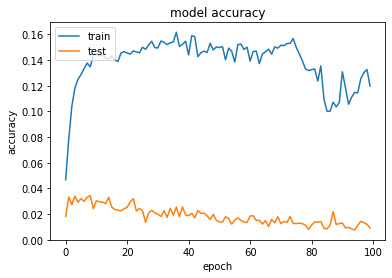

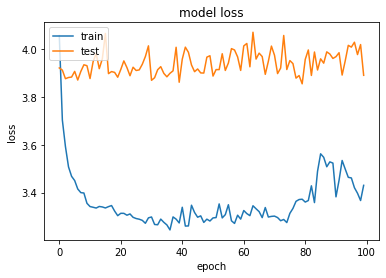

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

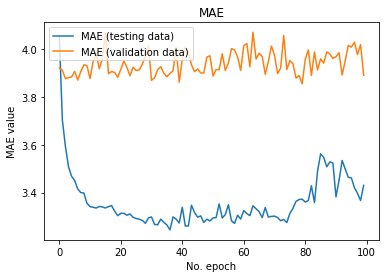

In [35]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

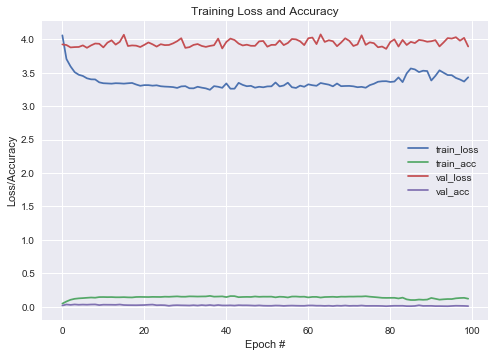

In [36]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochDenseNet121_OF.png')
plt.close()